# Introduction
The project below investigates 2019 Trends in International Math and Science Study (TIMSS) Data for 8th graders.

_Source: [2019 TIMSS Database](https://timss2019.org/international-database/)_

<div id='top'></div>

# Table of Contents
* [Business Understanding](#business_understanding)
* [Data Understanding](#data_understanding)
* [Data Preparation](#data_preparation)
* [Data Modeling](#data_modeling)
* [Evaluate Results](#evaluate_results)
* [Deploy Model](#deploy_model)

<div id='business_understanding'></div>

# Business Understanding

### Questions of Interest
1. How does a student's enviroment at home, in the classroom, and at school affect academic understanding?
2. Are there specific teacher behaviors that lead to improved understanding in specific disciplines?
3. What can students and teachers do to improve student academic understanding?

The project will cover a variety of analyses regarding vast data collected. The project will include:
* prediction of student score based on student attitudes and demographics, school characteristics
* prediction of student scores based on teacher attitudes and practices
* recommendation engine for additional study problems for a given student (or group of students from a school or country)
* recommendation engine for areas of investment or professional development for a given teacher (or group of teachers from a school or country)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [6]:
# import the country codes into a dataframe
country_codes = pd.read_csv('data/country_codes.csv').dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes

Country  IDCNTRY
0                   Australia       36
1                     Bahrain       48
2                       Chile      152
3              Chinese Taipei      158
4                      Cyprus      196
5                       Egypt      818
6                     England      926
7                     Finland      246
8                      France      250
9                     Georgia      268
10              Hong Kong SAR      344
11                    Hungary      348
12      Iran, Islamic Rep. of      364
13                    Ireland      372
14                     Israel      376
15                      Italy      380
16                      Japan      392
17                     Jordan      400
18                 Kazakhstan      398
19             Korea, Rep. of      410
20                     Kuwait      414
21                    Lebanon      422
22                  Lithuania      440
23                   Malaysia      458
24                    Morocco      504
25                New Zealand      554
26                     Norway      578
27                       Oman      512
28                   Portugal      620
29                      Qatar      634
30                    Romania      642
31         Russian Federation      643
32               Saudi Arabia      682
33                  Singapore      702
34               South Africa      710
35                     Sweden      752
36                     Turkey      792
37       United Arab Emirates      784
38              United States      840
39            Ontario, Canada     9132
40             Quebec, Canada     9133
41  Moscow City, Russian Fed.   643001
42             Abu Dhabi, UAE     7842
43                 Dubai, UAE     7841

<div id='data_understanding'></div>

[Return to Top](#top)

# Data Understanding

### Load Data
Import the 2019 TIMSS Data into six separate dataframes

In [3]:
# gather the metadata (column names) for the student assessment data
meta = pyreadstat.read_sav('T19_G8_SPSS Data/bsaaadm7.sav', metadataonly=True)
# select a subset of the columns for analysis
stud_ach_cols = meta[0].columns[:1265]

In [4]:
# initialize variables for reading in the TIMSS data
school = 0
stud_ach = 0
student = 0
stud_teach = 0
math_teach = 0
sci_teach = 0

# loop through each SPSS file
for file in glob.glob('T19_G8_SPSS Data/*.sav'):
    # print the file name to monitor progress
    print(file)
    # if file name contains "bcg" then it is a file with school level information
    if re.search('bcg',file) != None:
        # identify the subset of columns necessary for school level analysis
        school_cols = ['IDCNTRY','IDSCHOOL','IDPOP','IDGRADER','IDGRADE','ITLANG_C','LCID_C','BCBGDAS','BCBGEAS','BCBGMRS','BCBGSRS','BCDGDAS','BCDGEAS','BCDGMRS','BCDGSRS','BCDGSBC','BCDGTIHY']
        try:
            # append the new file onto the existing school level data (if exists)
            school = school.append(pd.read_spss(file, usecols=school_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the school level data
            school = pd.read_spss(file, usecols=school_cols)
    # if file name contains "bsa" then it is a file with student achievement level information
    elif re.search('bsa',file) != None:
        try:
            # append the new file onto the existing student achievement level data (if exists)
            stud_ach = stud_ach.append(pd.read_spss(file, usecols=stud_ach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student achievement level data
            stud_ach = pd.read_spss(file, usecols=stud_ach_cols)
    # if file name contains "bsg" then it is a file with student level information
    elif re.search('bsg',file) != None:
        # identify the subset of columns necessary for student level analysis
        student_cols = ['IDCNTRY','IDBOOK','IDSCHOOL','IDCLASS','IDSTUD','BSBG01','BSBG03','BSBG04','BSBG05A','BSBG05B','BSBG05C','BSBG05D','BSBG05E','BSBG05F','BSBG05G','BSBG05H','BSBG05I','BSBG06A','BSBG06B','BSBG07','BSBG08A','BSBG08B','BSBG09A','BSBG09B','BSBG10','BSBG11A','BSBG11B','BSBG12A','BSBG12B','BSBG12C','BSBG12D','BSBG12E','BSBG12F','IDPOP','IDGRADE','ITLANG_SQ','LCID_SQ','ITLANG_SA','LCID_SA','ITSEX','BSDAGE','BSBGHER','BSDGHER','BSBGSSB','BSDGSSB','BSBGSB','BSDGSB','BSBGSLM','BSDGSLM','BSBGICM','BSDGICM','BSBGDML','BSDGDML','BSBGSCM','BSDGSCM','BSBGSVM','BSDGSVM','BSBGSLS','BSDGSLS','BSBGICS','BSDGICS','BSBGSCS','BSDGSCS','BSBGSVS','BSDGSVS','BSBGSLB','BSDGSLB','BSBGICB','BSDGICB','BSBGSCB','BSDGSCB','BSBGSLE','BSDGSLE','BSBGICE','BSDGICE','BSBGSCE','BSDGSCE','BSBGSLC','BSDGSLC','BSBGICC','BSDGICC','BSBGSCC','BSDGSCC','BSBGSLP','BSDGSLP','BSBGICP','BSDGICP','BSBGSCP','BSDGSCP','BSBGSEC','BSDGSEC', 'BSDG05S','BSDGEDUP']
        try:
            # append the new file onto the existing student level data (if exists)
            student = student.append(pd.read_spss(file, usecols=student_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student level data
            student = pd.read_spss(file, usecols=student_cols)
    # if file name contains "bst" then it is a file with student-teacher level information
    elif re.search('bst',file) != None:
        try:
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # append the new file onto the existing student-teacher level data (if exists)
            stud_teach = stud_teach.append(pd.read_spss(file, usecols=stud_teach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student-teacher level data
            stud_teach = pd.read_spss(file)
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # select the appropriate columns from the available data
            stud_teach = stud_teach.loc[:,stud_teach_cols]
    # if file name contains "btm" then it is a file with math teacher level information
    elif re.search('btm',file) != None:
        try:
            # append the new file onto the existing math teacher level data (if exists)
            math_teach = math_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the math teacher level data
            math_teach = pd.read_spss(file)
    # if file name contains "bts" then it is a file with science teacher level information
    elif re.search('bts',file) != None:
        try:
            # append the new file onto the existing science teacher level data (if exists)
            sci_teach = sci_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the science teacher level data
            sci_teach = pd.read_spss(file)

T19_G8_SPSS Data\bcgaadm7.sav
T19_G8_SPSS Data\bcgadum7.sav
T19_G8_SPSS Data\bcgareb7.sav
T19_G8_SPSS Data\bcgarem7.sav
T19_G8_SPSS Data\bcgausm7.sav
T19_G8_SPSS Data\bcgbhrm7.sav
T19_G8_SPSS Data\bcgchlb7.sav
T19_G8_SPSS Data\bcgchlm7.sav
T19_G8_SPSS Data\bcgcotm7.sav
T19_G8_SPSS Data\bcgcqum7.sav
T19_G8_SPSS Data\bcgcypm7.sav
T19_G8_SPSS Data\bcgegym7.sav
T19_G8_SPSS Data\bcgengb7.sav
T19_G8_SPSS Data\bcgengm7.sav
T19_G8_SPSS Data\bcgfinm7.sav
T19_G8_SPSS Data\bcgfram7.sav
T19_G8_SPSS Data\bcggeob7.sav
T19_G8_SPSS Data\bcggeom7.sav
T19_G8_SPSS Data\bcghkgb7.sav
T19_G8_SPSS Data\bcghkgm7.sav
T19_G8_SPSS Data\bcghunb7.sav
T19_G8_SPSS Data\bcghunm7.sav
T19_G8_SPSS Data\bcgirlm7.sav
T19_G8_SPSS Data\bcgirnm7.sav
T19_G8_SPSS Data\bcgisrb7.sav
T19_G8_SPSS Data\bcgisrm7.sav
T19_G8_SPSS Data\bcgitab7.sav
T19_G8_SPSS Data\bcgitam7.sav
T19_G8_SPSS Data\bcgjorm7.sav
T19_G8_SPSS Data\bcgjpnm7.sav
T19_G8_SPSS Data\bcgkazm7.sav
T19_G8_SPSS Data\bcgkorb7.sav
T19_G8_SPSS Data\bcgkorm7.sav
T19_G8_SPS

In [5]:
# column prefixes to drop from math teacher data
math_teach_drop_cols = ['BTBM18','BTBM22','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in math_teach_drop_cols:
    drop_cols = [col for col in math_teach.columns if drop_head in col]
# drop all matching columns
math_teach.drop(columns=drop_cols,inplace=True)

In [6]:
# column prefixes to drop from science teacher data
sci_teach_drop_cols = ['BTBS17','BTBS21','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in sci_teach_drop_cols:
    drop_cols = [col for col in sci_teach.columns if drop_head in col]
# drop all matching columns
sci_teach.drop(columns=drop_cols,inplace=True)

In [7]:
# identify the file containing all of the code interpretations
file_name = 'T19_G8_Codebooks/T19_G8_Codebook.xlsx'
# store all codes into respectively named _codes dataframes
school_codes = pd.read_excel(file_name, sheet_name='BCGM7').set_index('Variable').iloc[:,:1]
stud_ach_codes = pd.read_excel(file_name, sheet_name='BSAM7').set_index('Variable').iloc[:,:1]
student_codes = pd.read_excel(file_name, sheet_name='BSGM7').set_index('Variable').iloc[:,:1]
stud_teach_codes = pd.read_excel(file_name, sheet_name='BSTM7').set_index('Variable').iloc[:,:1]
math_teach_codes = pd.read_excel(file_name, sheet_name='BTMM7').set_index('Variable').iloc[:,:1]
sci_teach_codes = pd.read_excel(file_name, sheet_name='BTSM7').set_index('Variable').iloc[:,:1]

In [8]:
# confirm codes were correctly stored
stud_teach_codes.head()

Label
Variable                               
IDCNTRY   Country ID - Numeric ISO Code
IDBOOK             Student Test Booklet
IDSCHOOL                      School ID
IDCLASS                        Class ID
IDSTUD                       Student ID

### Preprocessing Data
Preprocess the data to remove non-relevant information and variables

In [9]:
def binary_scores(answer): 
    '''
    converts each assessment item response into a binary number
    
    INPUT:
    answer - (str) the answer to the assessment item
                CORRECT RESPONSE, INCORRECT RESPONSE or a multiple choice response (* denotes correct answer)
          
    OUTPUT:
    a binary score for where:
            1 - correct response
            0 - incorrect response
    '''
    # keep NaN responses as NaN
    try: 
        float(answer)
        return np.nan
    except:
        # if response is correct, return 1
        if '*' in answer or ('CORRECT' in answer and 'INCORRECT' not in answer):
            return 1
        # otherwise, if the response is incorrect, return 0
        elif '*' not in answer or ('INCORRECT' in answer):
            return 0
        # in any other situation, return NaN
        else:
            return np.nan

In [10]:
def nanor(t):
    '''
    identifies if any correct answers are in the list
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - correct response found
            0 - no correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for any correct responses, 0 for no correct responses
    else:
        return int(any(t))
    
def nanand(t):
    '''
    identifies if all answers in the list are correct
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - all correct responses found
            0 - not all correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for all correct responses, 0 for not all correct responses
    else:
        return int(all(t))

In [11]:
# combine results from paper and electronic assessments to avoid redundant and ambiguous assessment comparisons

# create a list of all assessment columns from paper assessments (marked with a P) and that have not already been reduced to a single column
paper_cols_all = [col1 for col1 in list(stud_ach.columns) if (col1[1] == 'P' and col1[-4:] != '_val')]

# go through each columns
for col1 in paper_cols_all:
    # find all paper assessment columns that match the current column
    paper_cols = [str(col2) for col2 in list(stud_ach.columns) if (col1[:7] in col2 and col2[-4:] != '_val')]
    # find all electronic assessment columns that match the current column
    elec_cols = [col3 for col3 in list(stud_ach.columns) if (col1[2:7] in col3 and col1[0] == col3[0] and col3[1] == 'E')]
    # print the current columns being combined to monitor progress
    print(col1, paper_cols + elec_cols)
    # go through each of the matching paper or electronic assessment columns
    for col in paper_cols+elec_cols:
        # convert all answers to binary correct/incorrect values
        stud_ach[col] = stud_ach[col].apply(binary_scores)
    # if there are columns to be combined
    if len(paper_cols) > 0:
        # only count it as correct with all assessments were answered correctly (TIMSS assessment criteria)
        # store the result in the first of the matching columns
        stud_ach[paper_cols[0]] = stud_ach.loc[:,paper_cols].apply(nanand, axis=1)
        stud_ach[elec_cols[0]] = stud_ach.loc[:,elec_cols].apply(nanand, axis=1)
        # take the final results and combine the paper and electronic results into one column (marked with _val)
        stud_ach[col1[:7]+'_val'] = stud_ach.loc[:,[paper_cols[0],elec_cols[0]]].apply(nanor, axis=1)
        # drop previous paper and electronic assessment data to simplify the data set
        stud_ach.drop(columns=paper_cols+elec_cols, inplace=True)

MP52024 ['MP52024', 'ME52024']
MP52058A ['MP52058A', 'MP52058B', 'ME52058A', 'ME52058B']
MP52058B []
MP52125 ['MP52125', 'ME52125']
MP52229 ['MP52229', 'ME52229']
MP52063 ['MP52063', 'ME52063']
MP52072 ['MP52072', 'ME52072']
MP52146A ['MP52146A', 'MP52146B', 'ME52146A', 'ME52146B']
MP52146B []
MP52092 ['MP52092', 'ME52092']
MP52046 ['MP52046', 'ME52046']
MP52083 ['MP52083', 'ME52083']
MP52082 ['MP52082', 'ME52082']
MP52161 ['MP52161', 'ME52161']
MP52418A ['MP52418A', 'MP52418B', 'ME52418A', 'ME52418B']
MP52418B []
MP72007A ['MP72007A', 'MP72007B', 'MP72007C', 'MP72007D', 'MP72007E', 'MP72007', 'ME72007A', 'ME72007B', 'ME72007C', 'ME72007D', 'ME72007E', 'ME72007']
MP72007B []
MP72007C []
MP72007D []
MP72007E []
MP72007 []
MP72025 ['MP72025', 'ME72025']
MP72017 ['MP72017', 'ME72017']
MP72190 ['MP72190', 'ME72190']
MP72068 ['MP72068', 'ME72068']
MP72076 ['MP72076', 'ME72076']
MP72056 ['MP72056', 'ME72056']
MP72098 ['MP72098', 'ME72098']
MP72103 ['MP72103', 'ME72103']
MP72121 ['MP72121', '

In [12]:
# create a list of all math and science assessments
scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']

# go through each math and science score category
for item in scores:
    # find all assessments of that category (TIMSS offers 5 estimate of each category per student)
    sub_col = [col for col in stud_ach.columns if item in col]
    # print the columns to show progress
    print(sub_col)
    # find the average assessment of the category from all estimates
    stud_ach[item.lower()+'_avg'] = stud_ach.loc[:,sub_col].mean(axis=1)
    stud_teach[item.lower()+'_avg'] = stud_teach.loc[:,sub_col].mean(axis=1)
    # find the standard deviation of the estimates for that category
    stud_ach[item.lower()+'_sd'] = stud_ach.loc[:,sub_col].std(axis=1)
    # drop the previous five estimates to simplify to the average value
    stud_ach.drop(sub_col, axis = 1, inplace=True)
    stud_teach.drop(sub_col, axis = 1, inplace=True)

['BSMMAT01', 'BSMMAT02', 'BSMMAT03', 'BSMMAT04', 'BSMMAT05']
['BSSSCI01', 'BSSSCI02', 'BSSSCI03', 'BSSSCI04', 'BSSSCI05']
['BSMALG01', 'BSMALG02', 'BSMALG03', 'BSMALG04', 'BSMALG05']
['BSMAPP01', 'BSMAPP02', 'BSMAPP03', 'BSMAPP04', 'BSMAPP05']
['BSMDAT01', 'BSMDAT02', 'BSMDAT03', 'BSMDAT04', 'BSMDAT05']
['BSMGEO01', 'BSMGEO02', 'BSMGEO03', 'BSMGEO04', 'BSMGEO05']
['BSMKNO01', 'BSMKNO02', 'BSMKNO03', 'BSMKNO04', 'BSMKNO05']
['BSMNUM01', 'BSMNUM02', 'BSMNUM03', 'BSMNUM04', 'BSMNUM05']
['BSMREA01', 'BSMREA02', 'BSMREA03', 'BSMREA04', 'BSMREA05']
['BSSAPP01', 'BSSAPP02', 'BSSAPP03', 'BSSAPP04', 'BSSAPP05']
['BSSBIO01', 'BSSBIO02', 'BSSBIO03', 'BSSBIO04', 'BSSBIO05']
['BSSCHE01', 'BSSCHE02', 'BSSCHE03', 'BSSCHE04', 'BSSCHE05']
['BSSEAR01', 'BSSEAR02', 'BSSEAR03', 'BSSEAR04', 'BSSEAR05']
['BSSKNO01', 'BSSKNO02', 'BSSKNO03', 'BSSKNO04', 'BSSKNO05']
['BSSPHY01', 'BSSPHY02', 'BSSPHY03', 'BSSPHY04', 'BSSPHY05']
['BSSREA01', 'BSSREA02', 'BSSREA03', 'BSSREA04', 'BSSREA05']


In [13]:
# drop all weight and jackknife columns that are not relevant to the analysis
stud_ach.drop(columns=[col for col in stud_ach.columns if 'WGT' in col or 'JK' in col], inplace=True)

In [14]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

In [15]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (14,15,16,58,60,62,66,68,70,72,74,76,78,80,82,84,86,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Explore Data
Explore the structure and values of the data

In [16]:
# explore the school dataframe
school.head()

IDCNTRY  IDSCHOOL  IDPOP     IDGRADER  IDGRADE ITLANG_C  \
0   7842.0    5001.0  Pop 2  Upper Grade  Grade 8  English   
1   7842.0    5004.0  Pop 2  Upper Grade  Grade 8  English   
2   7842.0    5006.0  Pop 2  Upper Grade  Grade 8  English   
3   7842.0    5007.0  Pop 2  Upper Grade  Grade 8  English   
4   7842.0    5008.0  Pop 2  Upper Grade  Grade 8  English   

                       LCID_C   BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS  \
0  English (U.A.E. Abu Dhabi)   9.79606   7.03177  14.25596  14.57241   
1  English (U.A.E. Abu Dhabi)  10.10482   9.56054  12.92960  14.57241   
2  English (U.A.E. Abu Dhabi)  10.43939  11.35999   8.03304   7.45575   
3  English (U.A.E. Abu Dhabi)  12.80218  13.19357  12.29366  12.50979   
4  English (U.A.E. Abu Dhabi)  14.02858  13.19357   4.23486   4.07624   

               BCDGDAS             BCDGEAS         BCDGMRS         BCDGSRS  \
0       Minor Problems     Medium Emphasis    Not Affected    Not Affected   
1       Minor Problems     Medium Emphasis    Not Affected    Not Affected   
2       Minor Problems       High Emphasis        Affected  Affected A Lot   
3  Hardly Any Problems  Very High Emphasis    Not Affected    Not Affected   
4  Hardly Any Problems  Very High Emphasis  Affected A Lot  Affected A Lot   

                                        BCDGSBC  BCDGTIHY  
0  Neither More Affluent nor More Disadvantaged    1350.0  
1                                 More Affluent    1680.0  
2                                 More Affluent    1281.0  
3                                 More Affluent    1311.5  
4  Neither More Affluent nor More Disadvantaged       NaN

In [17]:
# inspect all TIMSS participating countries
school['IDCNTRY'].astype(int).unique()

array([  7842,   7841,    784,     36,     48,    152,   9132,   9133,
          196,    818,    926,    246,    250,    268,    344,    348,
          372,    364,    376,    380,    400,    392,    398,    410,
          414,    422,    440,    504,    458,    578,    554,    512,
          620,    634, 643001,    642,    643,    682,    702,    752,
          792,    158,    840,    710, 710003, 710004])

In [18]:
# list all participating countries (excluding benchmarking countries - codes >= 1000)
country_codes.set_index('IDCNTRY').loc[list(filter(lambda x: x<1000,list(school['IDCNTRY'].astype(int).unique()))),'Country'].tolist()

['United Arab Emirates',
 'Australia',
 'Bahrain',
 'Chile',
 'Cyprus',
 'Egypt',
 'Kosovo',
 'Finland',
 'France',
 'Georgia',
 'Hong Kong',
 'Hungary',
 'Ireland',
 'Iran',
 'Israel',
 'Italy',
 'Jordan',
 'Japan',
 'Kazakhstan',
 'South Korea',
 'Kuwait',
 'Lebanon',
 'Lithuania',
 'Morocco',
 'Malaysia',
 'Norway',
 'New Zealand',
 'Oman',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'Sweden',
 'Turkey',
 'Taiwan',
 'US',
 'South Africa']

In [19]:
# make a list to drop all columns that are empty or only contain one unqiue value
school_drop_new = list(school.columns[school.isna().all()])+list(school.columns[school.nunique()==1])

In [20]:
# display summary information for school dataframe
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9925 entries, 0 to 9924
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   9925 non-null   float64
 1   IDSCHOOL  9925 non-null   float64
 2   IDPOP     9925 non-null   object 
 3   IDGRADER  9925 non-null   object 
 4   IDGRADE   9925 non-null   object 
 5   ITLANG_C  9484 non-null   object 
 6   LCID_C    9484 non-null   object 
 7   BCBGDAS   9373 non-null   float64
 8   BCBGEAS   9373 non-null   float64
 9   BCBGMRS   9378 non-null   float64
 10  BCBGSRS   9379 non-null   float64
 11  BCDGDAS   9373 non-null   object 
 12  BCDGEAS   9373 non-null   object 
 13  BCDGMRS   9378 non-null   object 
 14  BCDGSRS   9379 non-null   object 
 15  BCDGSBC   8684 non-null   object 
 16  BCDGTIHY  8445 non-null   float64
dtypes: float64(7), object(10)
memory usage: 1.3+ MB


In [21]:
# display descriptive statistics for school dataframe
school.describe()

IDCNTRY     IDSCHOOL      BCBGDAS      BCBGEAS      BCBGMRS  \
count    9925.000000  9925.000000  9373.000000  9373.000000  9378.000000   
mean    32131.930982  5139.955264    10.371160    10.213209    10.182964   
std    142863.345610   121.183429     2.100143     2.114471     1.999650   
min        36.000000  5001.000000     4.100070     2.205220     4.234860   
25%       380.000000  5056.000000     9.014930     8.673410     9.008160   
50%       578.000000  5112.000000    10.439390    10.159690     9.970565   
75%       784.000000  5180.000000    11.628840    11.359990    11.265110   
max    710004.000000  5631.000000    14.028580    16.362220    14.255960   

           BCBGSRS     BCDGTIHY  
count  9379.000000  8445.000000  
mean     10.271956  1032.532627  
std       2.148128   216.999857  
min       4.076240   435.000000  
25%       8.925820   895.000000  
50%      10.047270  1002.000000  
75%      11.425290  1127.666670  
max      14.572410  2500.000000

In [22]:
# display context/label information for the school variables
school_codes.loc[school.columns,:]

Label
IDCNTRY                    Country ID - Numeric ISO Code
IDSCHOOL                                       School ID
IDPOP                                      Population ID
IDGRADER                           Standardized Grade ID
IDGRADE                                         Grade ID
ITLANG_C                Language of School Questionnaire
LCID_C                 Locale ID of School Questionnaire
BCBGDAS            School Discipline Problems-Prncpl/SCL
BCBGEAS           School Emph on Acad Success-Prncpl/SCL
BCBGMRS         Instr Aff by Mat Res Shortage-Prncpl/SCL
BCBGSRS         Instr Aff by Sci Res Shortage-Prncpl/SCL
BCDGDAS            School Discipline Problems-Prncpl/IDX
BCDGEAS           School Emph on Acad Success-Prncpl/IDX
BCDGMRS         Instr Aff by Mat Res Shortage-Prncpl/IDX
BCDGSRS         Instr Aff by Sci Res Shortage-Prncpl/IDX
BCDGSBC   School Composition by Socioeconomic Background
BCDGTIHY              Total Instructional Hours per Year

In [23]:
# examine the columns containing "BC" more closely for better understanding
school.sample(5).loc[:,[col for col in school.columns if "BC" in col]]

BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS                      BCDGDAS  \
9637   9.79606   9.56054   9.21409   9.14554               Minor Problems   
22    14.02858  16.36222  12.92960  13.17876          Hardly Any Problems   
8433  14.02858  10.15969   8.31802   8.31328          Hardly Any Problems   
5726   6.79025   7.03177   9.62794   9.80545  Moderate to Severe Problems   
1538   9.79606  11.06274   8.44578   8.44672               Minor Problems   

                 BCDGEAS       BCDGMRS       BCDGSRS             BCDGSBC  \
9637     Medium Emphasis      Affected      Affected  More Disadvantaged   
22    Very High Emphasis  Not Affected  Not Affected  More Disadvantaged   
8433       High Emphasis      Affected      Affected       More Affluent   
5726     Medium Emphasis      Affected      Affected  More Disadvantaged   
1538       High Emphasis      Affected      Affected  More Disadvantaged   

        BCDGTIHY  
9637  1100.00000  
22    1110.00000  
8433  1260.00000  
5726  1283.33333  
1538  1200.00000

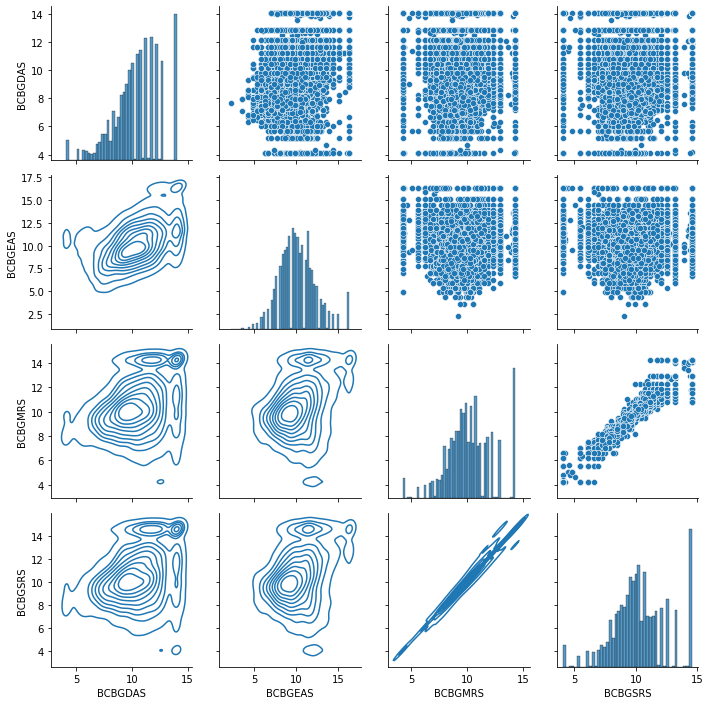

In [24]:
# plot the relationships between discipline, academics, and shortages
g = sns.PairGrid(school.loc[:,[col for col in school.columns if 'BCBG' in col]])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower maps show concentration of relational information
g.map_lower(sns.kdeplot)
# examine distribution of scores along the diagonal
g.map_diag(sns.histplot)

**Initial Observations about `school` dataset:**
* School discipline problems and focus on academic success do not seem correlated with each other or resource shortages
* Math and science resource shortages are strongly correlated; schools seem to be investing or struggling in both math and science equally
* There are many schools with hardly any struggles with discipline or resources, while most other schools are spread equally across the spectrum

**`school` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL to integers
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals
* rename all columns to be more descriptive
* merge with student performance by school

In [25]:
# investigate student assessment (stud_ach) dataframe
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1 BNRGCAL2  \
0   7842.0  Booklet 11    5001.0  500102.0  50010201.0      NaN      NaN   
1   7842.0  Booklet 12    5001.0  500102.0  50010202.0      NaN      NaN   
2   7842.0  Booklet 13    5001.0  500102.0  50010203.0      NaN      NaN   
3   7842.0  Booklet 14    5001.0  500102.0  50010204.0      NaN      NaN   
4   7842.0  Booklet 02    5001.0  500102.0  50010207.0      NaN      NaN   

   IDPOP     IDGRADER  IDGRADE ITLANG_SA                     LCID_SA ITSEX  \
0  Pop 2  Upper Grade  Grade 8   English  English (U.A.E. Abu Dhabi)  Male   
1  Pop 2  Upper Grade  Grade 8   English  English (U.A.E. Abu Dhabi)  Male   
2  Pop 2  Upper Grade  Grade 8   English  English (U.A.E. Abu Dhabi)  Male   
3  Pop 2  Upper Grade  Grade 8   English  English (U.A.E. Abu Dhabi)  Male   
4  Pop 2  Upper Grade  Grade 8   English  English (U.A.E. Abu Dhabi)  Male   

   BSDAGE             ITADMINI  \
0   13.58  Teacher from School   
1   13.75  Teacher from School   
2   13.50  Teacher from School   
3   14.00  Teacher from School   
4   13.33  Teacher from School   

                                            ILRELIAB  MP52024_val  \
0  Students Booklet was used for Reliability Scoring          NaN   
1  Students Booklet was used for Reliability Scoring          NaN   
2  Students Booklet was used for Reliability Scoring          NaN   
3  Students Booklet was used for Reliability Scoring          0.0   
4  Students Booklet not used for Reliability Scoring          NaN   

   MP52058_val  MP52125_val  MP52229_val  MP52063_val  MP52072_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          0.0          1.0          0.0          1.0          1.0   
4          NaN          NaN          NaN          NaN          NaN   

   MP52146_val  MP52092_val  MP52046_val  MP52083_val  MP52082_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          1.0          0.0          1.0          0.0          1.0   
4          NaN          NaN          NaN          NaN          NaN   

   MP52161_val  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          0.0          0.0          NaN          NaN          NaN   
4          NaN          NaN          1.0          0.0          0.0   

   MP72190_val  MP72068_val  MP72076_val  MP72056_val  MP72098_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          1.0          0.0          1.0          1.0          1.0   

   MP72103_val  MP72121_val  MP72180_val  MP72198_val  MP72227_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          1.0          1.0          1.0          1.0          1.0   

   MP72170_val  MP72209_val  MP62005_val  MP62139_val  MP62164_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4 

In [26]:
# create a list to drop all null columns and any columns that online contain one unique entry
stud_ach_drop_new = list(stud_ach.columns[stud_ach.isna().all()])+list(stud_ach.columns[stud_ach.nunique()==1])

In [27]:
# display descriptive statisticis for quantitative columns in the dataframe
stud_ach.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  295453.000000  295453.000000  295453.000000  2.954530e+05   
mean    35669.770887    5147.488924  514752.442145  5.147526e+07   
std    150889.861246     129.955610   12995.298104  1.299530e+06   
min        36.000000    5001.000000  500101.000000  5.001010e+07   
25%       380.000000    5057.000000  505701.000000  5.057011e+07   
50%       578.000000    5114.000000  511402.000000  5.114023e+07   
75%       784.000000    5189.000000  518902.000000  5.189020e+07   
max    710004.000000    5631.000000  563102.000000  5.631021e+07   

              BSDAGE   MP52024_val   MP52058_val   MP52125_val   MP52229_val  \
count  295007.000000  44576.000000  43270.000000  44614.000000  41948.000000   
mean       14.293059      0.486831      0.260319      0.403707      0.509726   
std         0.816446      0.499832      0.438814      0.490646      0.499911   
min         9.080000      0.000000      0.000000      0.000000      0.000000   
25%        13.750000      0.000000      0.000000      0.000000      0.000000   
50%        14.170000      0.000000      0.000000      0.000000      1.000000   
75%        14.670000      1.000000      1.000000      1.000000      1.000000   
max        19.000000      1.000000      1.000000      1.000000      1.000000   

        MP52063_val   MP52072_val   MP52146_val   MP52092_val   MP52046_val  \
count  44563.000000  44900.000000  42787.000000  44096.000000  44124.000000   
mean       0.449207      0.568753      0.195363      0.266782      0.286647   
std        0.497419      0.495256      0.396485      0.442282      0.452200   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP52083_val   MP52082_val   MP52161_val  MP52418_val   MP72007_val  \
count  43376.000000  44500.000000  44132.000000  44023.00000  36582.000000   
mean       0.370182      0.535326      0.634415      0.26602      0.164425   
std        0.482859      0.498756      0.481599      0.44188      0.370666   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        0.000000      0.000000      0.000000      0.00000      0.000000   
50%        0.000000      1.000000      1.000000      0.00000      0.000000   
75%        1.000000      1.000000      1.000000      1.00000      0.000000   
max        1.000000      1.000000      1.000000      1.00000      1.000000   

        MP72025_val   MP72017_val   MP72190_val   MP72068_val   MP72076_val  \
count  36261.000000  31224.000000  34927.000000  36694.000000  36255.000000   
mean       0.440308      0.194466      0.522776      0.591841      0.410426   
std        0.496431      0.395795      0.499488      0.491500      0.491918   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      1.000000      0.000000   
75%        1.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        MP72056_val   MP72098_val   MP72103_val   MP72121_val   MP72180_val  \
count  33137.000000  33145.000000  35739.000000  35081.000000  35548.000000   
mean       0.379183      0.269845      0.423963      0.554089      0.404411   
std        0.485191      0.443886      0.494191      0.497073      0.490785   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      1.000000      0.000000   

In [28]:
# display the datatype for all columsn that are not averages or standard deviations of scores
stud_ach.loc[:,[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col]].dtypes

IDCNTRY      float64
IDBOOK        object
IDSCHOOL     float64
IDCLASS      float64
IDSTUD       float64
BNRGCAL1      object
BNRGCAL2      object
IDPOP         object
IDGRADER      object
IDGRADE       object
ITLANG_SA     object
LCID_SA       object
ITSEX         object
BSDAGE       float64
ITADMINI      object
ILRELIAB      object
dtype: object

In [29]:
# display the label information for every code that is not an assessment item
stud_ach_codes.loc[[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col],:]

Label
Variable                                                  
IDCNTRY                      Country ID - Numeric ISO Code
IDBOOK                                Student Test Booklet
IDSCHOOL                                         School ID
IDCLASS                                           Class ID
IDSTUD                                          Student ID
BNRGCAL1               CALCULATOR SURVEY\USE OF CALCULATOR
BNRGCAL2   CALCULATOR SURVEY\FREQUENCY OF USING CALCULATOR
IDPOP                                        Population ID
IDGRADER                             Standardized Grade ID
IDGRADE                                           Grade ID
ITLANG_SA             Language of Student Achievement Test
LCID_SA              Locale ID of Student Achievement Test
ITSEX                                      Sex of Students
BSDAGE                                        Students Age
ITADMINI                       Test Administrator Position
ILRELIAB                         Reliability Coding Status

In [30]:
# add additional nonrelevant information to be dropped
stud_ach_drop_new = stud_ach_drop_new+['BNRGCAL1','BNRGCAL2','ITADMINI','ILRELIAB']
stud_ach_drop_new

['MP62342_val',
 'MP72038_val',
 'MP62048_val',
 'SP62272_val',
 'SP52221_val',
 'SP72133_val',
 'SP72048_val',
 'SP62036_val',
 'SP72906_val',
 'SP72329_val',
 'SP62266_val',
 'IDPOP',
 'IDGRADER',
 'BNRGCAL1',
 'BNRGCAL2',
 'ITADMINI',
 'ILRELIAB']

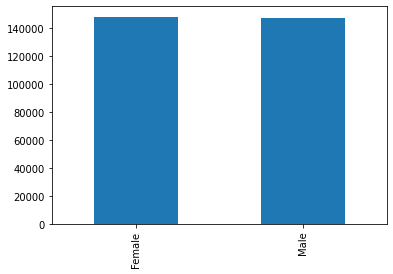

In [31]:
# graph the different counts of gender in the dataset
stud_ach['ITSEX'].value_counts().plot(kind='bar');

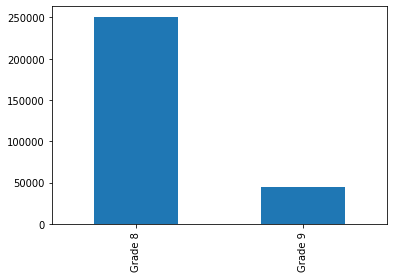

In [32]:
# graph the different counts of 8th graders vs. 9th graders
stud_ach['IDGRADE'].value_counts().plot(kind='bar');

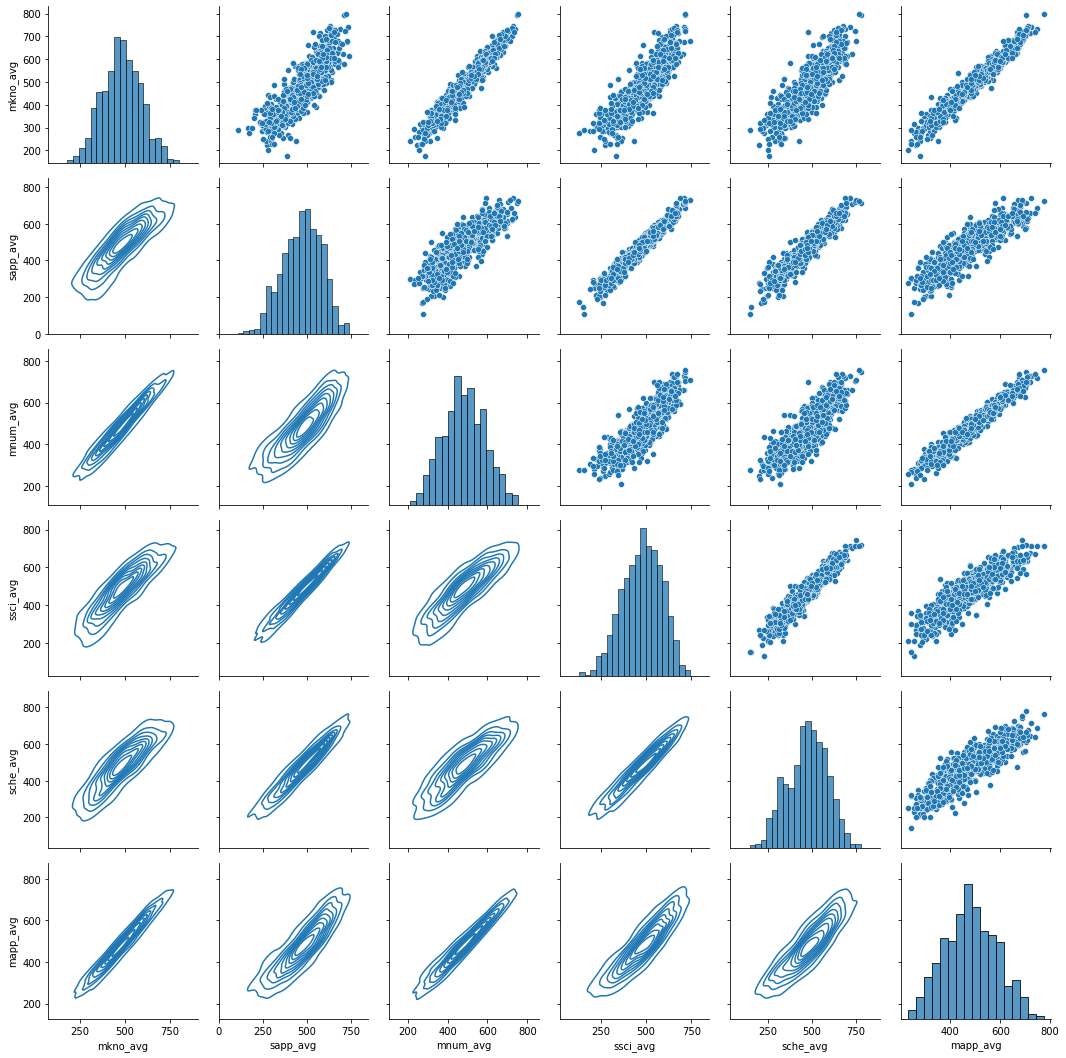

In [33]:
# plot distributions and relationships for a random sample of 1000 students and scores in 6 random categories
g = sns.PairGrid(stud_ach.sample(1000).loc[:,random.sample([col for col in stud_ach.columns if '_avg' in col],6)])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower graphs show concentration of the correlation data
g.map_lower(sns.kdeplot)
# the diagonal graphs show the distribution of the scores in the 6 categories
g.map_diag(sns.histplot)

**Initial Observations about `stud_ach` dataset:**
* All mathematical understanding is closely related (strong correlation)
* All science understanding is closely related (strong correlation)
* The relationship between science and math has more variance - is this due to subject differences or the difference in teaching?

**`stud_ach` Data Preparation**
* drop unnecessary (or null) columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integer
* rename all columns to be more descriptive

In [34]:
# explore the basic info for teh student dataframe
student.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01         BSBG03  \
0   7842.0  Booklet 11    5001.0  500102.0  50010201.0    Boy  Almost always   
1   7842.0  Booklet 12    5001.0  500102.0  50010202.0    Boy  Almost always   
2   7842.0  Booklet 13    5001.0  500102.0  50010203.0    Boy         Always   
3   7842.0  Booklet 14    5001.0  500102.0  50010204.0    Boy  Almost always   
4   7842.0  Booklet 02    5001.0  500102.0  50010207.0    Boy  Almost always   

                                   BSBG04 BSBG05A BSBG05B BSBG05C BSBG05D  \
0  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
1  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
2           None or very few (0–10 books)     Yes      No     Yes      No   
3  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
4  Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   

  BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
0     Yes     Yes     Yes     Yes     Yes   
1     Yes     Yes     Yes     Yes     Yes   
2     Yes      No     Yes      No     Yes   
3     Yes     Yes     Yes     Yes     Yes   
4     Yes     Yes     Yes     Yes     Yes   

                                             BSBG06A  \
0  <Post-secondary, non-tertiary education—ISCED ...   
1     <Short-cycle tertiary education—ISCED Level 5>   
2                                                NaN   
3     <Short-cycle tertiary education—ISCED Level 5>   
4     <Short-cycle tertiary education—ISCED Level 5>   

                                             BSBG06B  \
0     <Bachelor’s or equivalent level—ISCED Level 6>   
1     <Short-cycle tertiary education—ISCED Level 5>   
2     <Short-cycle tertiary education—ISCED Level 5>   
3     <Short-cycle tertiary education—ISCED Level 5>   
4  <Post-secondary, non-tertiary education—ISCED ...   

                                              BSBG07 BSBG08A BSBG08B BSBG09A  \
0  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
1  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
2   Finish <Lower secondary education—ISCED Level 2>     Yes      No     Yes   
3  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
4  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   

  BSBG09B                 BSBG10    BSBG11A    BSBG11B BSBG12A BSBG12B  \
0     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
1     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
2     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
3     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   
4     NaN  Never or almost never  Sometimes  Sometimes     Yes     Yes   

  BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP  IDGRADE ITLANG_SQ  \
0     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   
1     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   
2     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   
3     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   
4     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   

                      LCID_SQ ITLANG_SA                     LCID_SA ITSEX  \
0  English (U.A.E. Abu Dhabi)   English  English (U.A.E. Abu Dhabi)  Male   
1  English (U.A.E. Abu Dhabi)   English  English (U.A.E. Abu Dhabi)  Male   
2  English (U.A.E. Abu Dhabi)   English  English (U.A.E. Abu Dhabi)  Male   
3  English (U.A.E. Abu Dhabi)   English  English (U.A.E. Abu Dhabi)  Male   
4  English (U.A.E. Abu Dhabi)   English  English (U.A.E. Abu Dhabi)  Male   

   BSDAGE   BSBGHER         BSDGHER   BSBGSSB                         BSDGSSB  \
0   13.58  10.84499  Some Resources  12.80573  High Sense of School Belonging   
1   13.75  10.23835  Some Resources  13.27199  High Sense of School Belonging   
2   13.50   9.03613  Some Resources  13.27199  High Sense of School Belonging   
3   14.00  10.23835  S

In [35]:
# create a list to drop all empty or unnecessary columns (containing only one value)
student_drop_new = list(student.columns[student.isna().all()])+list(student.columns[student.nunique()==1])

In [36]:
# display the basic quality information for the student dataframe
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295453 entries, 0 to 295452
Data columns (total 93 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   IDCNTRY    295453 non-null  float64
 1   IDBOOK     295453 non-null  object 
 2   IDSCHOOL   295453 non-null  float64
 3   IDCLASS    295453 non-null  float64
 4   IDSTUD     295453 non-null  float64
 5   BSBG01     292598 non-null  object 
 6   BSBG03     290052 non-null  object 
 7   BSBG04     290351 non-null  object 
 8   BSBG05A    290843 non-null  object 
 9   BSBG05B    290610 non-null  object 
 10  BSBG05C    285147 non-null  object 
 11  BSBG05D    289807 non-null  object 
 12  BSBG05E    290379 non-null  object 
 13  BSBG05F    266242 non-null  object 
 14  BSBG05G    237077 non-null  object 
 15  BSBG05H    223433 non-null  object 
 16  BSBG05I    203576 non-null  object 
 17  BSBG06A    283039 non-null  object 
 18  BSBG06B    282538 non-null  object 
 19  BSBG07     284088 non-n

In [37]:
# display descriptive statistics of the quantitative information of the student dataframe
student.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  295453.000000  295453.000000  295453.000000  2.954530e+05   
mean    35669.770887    5147.488924  514752.442145  5.147526e+07   
std    150889.861246     129.955610   12995.298104  1.299530e+06   
min        36.000000    5001.000000  500101.000000  5.001010e+07   
25%       380.000000    5057.000000  505701.000000  5.057011e+07   
50%       578.000000    5114.000000  511402.000000  5.114023e+07   
75%       784.000000    5189.000000  518902.000000  5.189020e+07   
max    710004.000000    5631.000000  563102.000000  5.631021e+07   

              BSDAGE        BSBGHER       BSBGSSB         BSBGSB  \
count  295007.000000  289242.000000  290131.00000  284744.000000   
mean       14.293059      10.251069       9.86241       9.776433   
std         0.816446       1.684202       1.95809       2.017834   
min         9.080000       4.552080       3.92440       1.953440   
25%        13.750000       9.036130       8.46096       8.357840   
50%        14.170000      10.238350       9.40801       9.569750   
75%        14.670000      11.487120      11.62252      11.187840   
max        19.000000      13.515430      13.27199      12.937340   

             BSBGSLM        BSBGICM        BSBGDML        BSBGSCM  \
count  290408.000000  289976.000000  282896.000000  289359.000000   
mean        9.961073      10.072908       9.916083      10.019942   
std         1.903557       1.997334       1.992961       2.089437   
min         5.094840       3.695680       5.566330       3.277930   
25%         8.761390       8.518960       8.705590       8.997360   
50%         9.866380       9.926750       9.941130       9.804960   
75%        11.148590      11.651150      11.103430      11.104060   
max        13.848490      13.018850      14.673710      15.851880   

             BSBGSVM        BSBGSLS        BSBGICS        BSBGSCS  \
count  288760.000000  220370.000000  219680.000000  219342.000000   
mean        9.840356      10.117461      10.072631      10.079303   
std         2.054977       2.027841       1.979049       2.007870   
min         3.036820       3.846500       4.022730       3.249920   
25%         8.346150       8.696610       8.528200       8.873810   
50%         9.654380       9.817230      10.306400       9.615810   
75%        11.301900      11.533000      11.431060      11.024140   
max        13.482930      13.517780      12.633860      14.841820   

             BSBGSVS       BSBGSLB       BSBGICB       BSBGSCB       BSBGSLE  \
count  285862.000000  66641.000000  66479.000000  66416.000000  54472.000000   
mean       10.086556      9.969839      9.932821      9.982285      9.961898   
std         1.910471      2.006163      2.003414      1.984479      2.005631   
min         4.283400      3.770330      3.805730      3.049750      4.020150   
25%         8.817250      8.646750      8.476250      8.768360      8.720260   
50%         9.895320      9.576050      9.939960      9.628410      9.614740   
75%        11.354160     11.404230     11.547870     10.979050     11.265810   
max        12.936700     13.864760     12.776070     14.925630     14.057380   

            BSBGICE       BSBGSCE       BSBGSLC       BSBGICC       BSBGSCC  \
count  54320.000000  54252.000000  65734.000000  65556.000000  65417.000000   
mean       9.964434      9.998950      9.970825      9.948196      9.937674   
std        1.998236      1.993684      2.017648      2.002994      1.990926   
min        4.198000      3.210940      4.381810      4.449820      3.896350   
25%        8.604940      8.807510      8.772590      8.694020      8.784090   
50%       10.090050      9.665740      9.709260      9.753180      9.732660   
75%       11.608490     11.013050     11.138650     11.561420     10.855390   
max       12.753610     14.910220     13.776840     12.636810     14.721900   

            BSBGSLP       BSBGICP       BSBGSCP        BSBGSEC  
count  65719.000000  65491.000000  65368.0000

In [38]:
# display the contextual information for each column
student_codes.loc[student.columns,:]

Label
IDCNTRY                        Country ID - Numeric ISO Code
IDBOOK                                  Student Test Booklet
IDSCHOOL                                           School ID
IDCLASS                                             Class ID
IDSTUD                                            Student ID
BSBG01                                    GEN\SEX OF STUDENT
BSBG03                GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
BSBG04                      GEN\AMOUNT OF BOOKS IN YOUR HOME
BSBG05A                     GEN\HOME POSSESS\COMPUTER TABLET
BSBG05B                          GEN\HOME POSSESS\STUDY DESK
BSBG05C                            GEN\HOME POSSESS\OWN ROOM
BSBG05D                 GEN\HOME POSSESS\INTERNET CONNECTION
BSBG05E                    GEN\HOME POSSESS\OWN MOBILE PHONE
BSBG05F                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05G                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05H                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05I                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG06A        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
BSBG06B        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN B>
BSBG07                GEN\HOW FAR IN EDU DO YOU EXPECT TO GO
BSBG08A            GEN\<PARENT/GUARDIAN A> BORN IN <COUNTRY>
BSBG08B            GEN\<PARENT/GUARDIAN B> BORN IN <COUNTRY>
BSBG09A                                GEN\BORN IN <COUNTRY>
BSBG09B            GEN\BORN IN <COUNTRY>\AGE CAME TO COUNTRY
BSBG10                GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
BSBG11A                                  GEN\HOW OFTEN\TIRED
BSBG11B                                 GEN\HOW OFTEN\HUNGRY
BSBG12A                    GEN\INTERNET USE\ACCESS TEXTBOOKS
BSBG12B                  GEN\INTERNET USE\ACCESS ASSIGNMENTS
BSBG12C         GEN\INTERNET USE\COLLABORATE WITH CLASSMATES
BSBG12D            GEN\INTERNET USE\COMMUNICATE WITH TEACHER
BSBG12E     GEN\INTERNET USE\FIND INFO TO AID IN MATH OR SCI
BSBG12F               GEN\INTERNET USE\ACCESS LEARNING GAMES
IDPOP                                          Population ID
IDGRADE                                             Grade ID
ITLANG_SQ          Language of Student Context Questionnaire
LCID_SQ           Locale ID of Student Context Questionnaire
ITLANG_SA               Language of Student Achievement Test
LCID_SA                Locale ID of Student Achievement Test
ITSEX                                        Sex of Students
BSDAGE                                          Students Age
BSBGHER                       Home Educational Resources/SCL
BSDGHER                       Home Educational Resources/IDX
BSBGSSB               Students Sense of School Belonging/SCL
BSDGSSB               Students Sense of School Belonging/IDX
BSBGSB                                  Student Bullying/SCL
BSDGSB                                  Student Bullying/IDX
BSBGSLM       Students Like Learning Mathematics Lessons/SCL
BSDGSLM       Students Like Learning Mathematics Lessons/IDX
BSBGICM     Instructional Clarity in Mathematics Lessons/SCL
BSDGICM     Instructional Clarity in Mathematics Lessons/IDX
BSBGDML          Disorderly Behavior during Math Lessons/SCL
BSDGDML          Disorderly Behavior during Math Lessons/IDX
BSBGSCM                 Student Confident in Mathematics/SCL
BSDGSCM                 Student Confident in Mathematics/IDX
BSBGSVM                       Students Value Mathematics/SCL
BSDGSVM                       Students Value Mathematics/IDX
BSBGSLS                   Students Like Learning Science/SCL
BSDGSLS                   Students Like Learning Science/IDX
BSBGICS         Instructional Clarity in Science Lessons/SCL
BSDGICS         Instructional Clarity in Science Lessons/IDX
BSBGSCS                     Student Confident in Science/SCL
BSDGSCS                     Student Confident in Science/IDX
BSBGSVS                           Students Value Science/SCL
BSDGSVS                           Students Value Science/IDX
BSBGSLB                   Stu

In [39]:
# investigate the unique entries on some of the qualitative data
student['BSDGSB'].unique()

array(['Never or Almost Never', 'About Monthly', 'About Weekly', nan],
      dtype=object)

In [40]:
# investigate some of the data that appears to have two different languages
student.query('ITLANG_SQ != ITLANG_SA and ITLANG_SQ == ITLANG_SQ')

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  BSBG03  \
8393      7841.0  Booklet 10    5035.0  503502.0  50350201.0   Girl  Always   
8394      7841.0  Booklet 11    5035.0  503502.0  50350202.0   Girl  Always   
8395      7841.0  Booklet 12    5035.0  503502.0  50350203.0   Girl  Always   
8396      7841.0  Booklet 13    5035.0  503502.0  50350204.0   Girl  Always   
8397      7841.0  Booklet 14    5035.0  503502.0  50350205.0   Girl  Always   
...          ...         ...       ...       ...         ...    ...     ...   
187001     578.0  Booklet 08    5206.0  520602.0  52060215.0   Girl  Always   
187046     578.0  Booklet 10    5210.0  521001.0  52100108.0    Boy  Always   
216492     642.0  Booklet 10    5172.0  517201.0  51720115.0   Girl  Always   
270224     710.0  Booklet 10    5170.0  517003.0  51700317.0    Boy  Always   
291835  710004.0  Booklet 10    5170.0  517003.0  51700317.0    Boy  Always   

                                              BSBG04 BSBG05A BSBG05B BSBG05C  \
8393      Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes   
8394      Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes   
8395      Enough to fill one bookcase (26–100 books)     Yes      No      No   
8396          Enough to fill one shelf (11–25 books)     Yes      No      No   
8397                   None or very few (0–10 books)     Yes     Yes      No   
...                                              ...     ...     ...     ...   
187001  Enough to fill two bookcases (101–200 books)     Yes     Yes     Yes   
187046    Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes   
216492  Enough to fill two bookcases (101–200 books)     Yes     Yes      No   
270224                 None or very few (0–10 books)      No     Yes     Yes   
291835                 None or very few (0–10 books)      No     Yes     Yes   

       BSBG05D BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
8393       Yes     Yes     Yes      No      No      No   
8394       Yes     Yes      No      No      No     Yes   
8395       Yes     Yes      No     Yes     Yes     Yes   
8396       Yes     Yes     Yes     Yes      No      No   
8397       Yes     Yes     Yes     Yes     Yes      No   
...        ...     ...     ...     ...     ...     ...   
187001     Yes     Yes      No     Yes     NaN     NaN   
187046     Yes     Yes      No     Yes     NaN     NaN   
216492     Yes     Yes      No     Yes      No     Yes   
270224      No     Yes      No     Yes     Yes      No   
291835      No     Yes      No     Yes     Yes      No   

                                                  BSBG06A  \
8393            <Upper secondary education—ISCED Level 3>   
8394            <Lower secondary education—ISCED Level 2>   
8395                                         I don’t know   
8396    <Postgraduate degree: Master’s—ISCED Level 7 o...   
8397    <Postgraduate degree: Master’s—ISCED Level 7 o...   
...                                                   ...   
187001          <Upper secondary education—ISCED Level 3>   
187046                                     Not applicable   
216492                                       I don’t know   
270224          <Lower secondary education—ISCED Level 2>   
291835          <Lower secondary education—ISCED Level 2>   

                                                  BSBG06B  \
8393    Some <Primary education—ISCED Level 1 or Lower...   
8394    Some <Primary education—ISCED Level 1 or Lower...   
8395            <Upper secondary education—ISCED Level 3>   
8396    <Postgraduate degree: Master’s—ISCED Level 7 o...   
8397                                         I don’t know   
...                                                   ...   
187001                                       I don’t know   
187046                                                NaN   
216492                                       I don’t know   
270224          <Lower secondary education—ISCED Level 2>  

In [41]:
# add additional nonrelevant data to be dropped from the dataframe
student_drop_new = student_drop_new + ['BSBG01','LCID_SQ','LCID_SA']

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


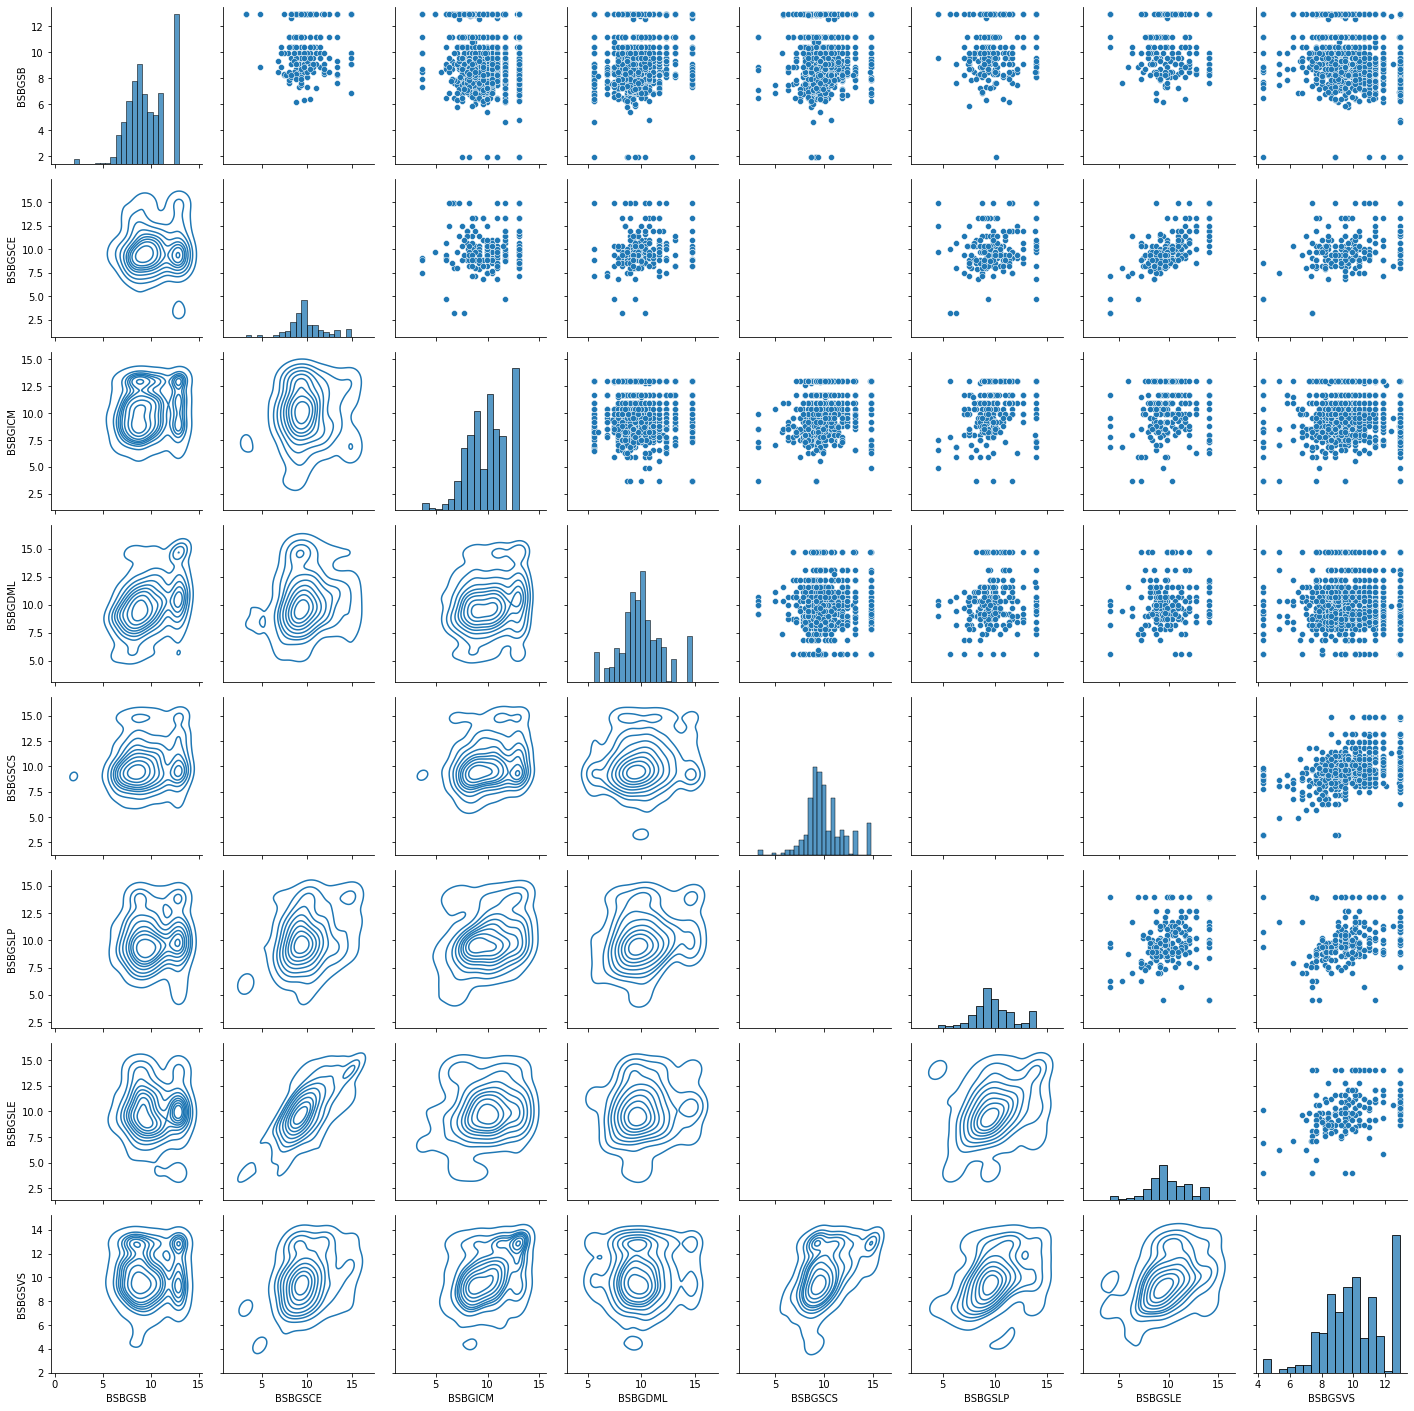

In [42]:
# visualize the relationships between a selection of the available scores for student demographics (1000 randomly sampled students, 8 random sampled variables)
g = sns.PairGrid(student.sample(1000).loc[:,random.sample([col for col in student.columns if 'BSBG' in col and student[col].dtype == 'float64'],8)])
# upper graphs will show correlation
g.map_upper(sns.scatterplot)
# lower graphs will show data concentration
g.map_lower(sns.kdeplot)
# diagonal graphs will show the distribution of each variable
g.map_diag(sns.histplot)

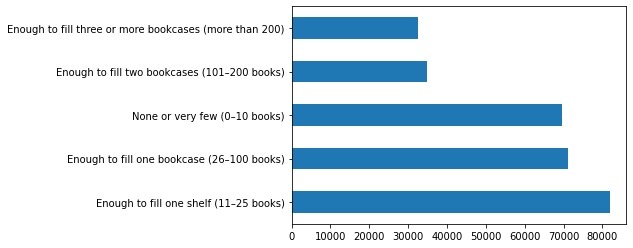

In [43]:
# visualize the number of books at home for each student
student['BSBG04'].value_counts().plot(kind='barh');

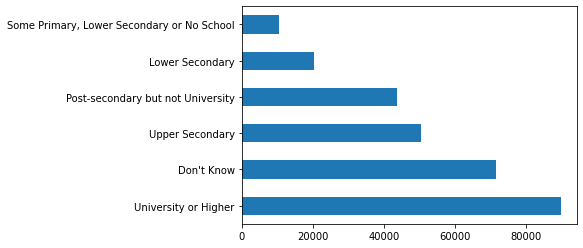

In [44]:
# visualize the highest level of education achieved by the parents of the student
student['BSDGEDUP'].value_counts().plot(kind='barh');

**Initial Observations about `student` dataset:**
* Apparent correlation between instructional clarity across all science classes (possible link to instructional quality at the school level)
* Wide variance in the number of books in the home
* Wide variance in highest parental education, but university is most common

**`student` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG09* columns to age_immigration column
* convert to integer and combine BSBG12* columns to internet_access column
* convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)
* convert BSBG08* to boolean
* rename all columns to be more descriptive
* merge with student performance

In [45]:
# explore basic structure of stud_teach dataset
stud_teach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD    IDTEALIN   IDTEACH  \
0   7842.0  Booklet 11    5001.0  500102.0  50010201.0  50010101.0  500101.0   
1   7842.0  Booklet 11    5001.0  500102.0  50010201.0  50010203.0  500102.0   
2   7842.0  Booklet 12    5001.0  500102.0  50010202.0  50010203.0  500102.0   
3   7842.0  Booklet 12    5001.0  500102.0  50010202.0  50010101.0  500101.0   
4   7842.0  Booklet 13    5001.0  500102.0  50010203.0  50010101.0  500101.0   

   IDLINK  IDPOP  IDGRADE       IDSUBJ            ITCOURSE  NMTEACH  NSTEACH  \
0     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
1     3.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
2     3.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
3     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
4     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   

     mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg    mgeo_avg  \
0  550.550842  480.099946  517.042408  502.836180  485.677994  508.168950   
1  550.550842  480.099946  517.042408  502.836180  485.677994  508.168950   
2  326.129702  318.662552  323.233832  356.545632  302.030198  328.756934   
3  326.129702  318.662552  323.233832  356.545632  302.030198  328.756934   
4  393.169444  328.771868  420.589982  389.112222  371.349082  391.344424   

     mkno_avg    mnum_avg    mrea_avg    sapp_avg    sbio_avg    sche_avg  \
0  527.618686  535.162198  517.203196  459.227332  404.517518  443.350576   
1  527.618686  535.162198  517.203196  459.227332  404.517518  443.350576   
2  352.864178  355.017696  385.102162  315.159308  295.509340  324.683132   
3  352.864178  355.017696  385.102162  315.159308  295.509340  324.683132   
4  417.370708  386.164962  407.777500  310.335522  279.297756  321.583934   

     sear_avg    skno_avg    sphy_avg    srea_avg  
0  412.148076  471.580088  450.679538  464.316504  
1  412.148076  471.580088  450.679538  464.316504  
2  343.312374  323.550294  343.942730  315.274280  
3  343.312374  323.550294  343.942730  315.274280  
4  291.039122  313.976578  350.246454  315.896516

In [46]:
# create a list of columns to drop because they are null or have only one value
stud_teach_drop_new = list(stud_teach.columns[stud_teach.isna().all()])+list(stud_teach.columns[stud_teach.nunique()==1])

In [47]:
# also drop IDBOOK column
stud_teach_drop_new = stud_teach_drop_new + ['IDBOOK']

In [48]:
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY         46
IDBOOK          22
IDSCHOOL       631
IDCLASS       3311
IDSTUD       96976
IDTEALIN      8674
IDTEACH       3995
IDLINK          34
IDPOP            1
IDGRADE          2
IDSUBJ           2
ITCOURSE         9
NMTEACH          7
NSTEACH          9
mmat_avg    270402
ssci_avg    270380
malg_avg    217888
mapp_avg    214582
mdat_avg    217903
mgeo_avg    217868
mkno_avg    214587
mnum_avg    217887
mrea_avg    214563
sapp_avg    227727
sbio_avg    227746
sche_avg    227735
sear_avg    227724
skno_avg    227725
sphy_avg    227734
srea_avg    227723
dtype: int64

In [49]:
# display summary information about stud_teach dataframe
stud_teach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775679 entries, 0 to 775678
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   IDCNTRY   775679 non-null  float64
 1   IDBOOK    775679 non-null  object 
 2   IDSCHOOL  775679 non-null  float64
 3   IDCLASS   775679 non-null  float64
 4   IDSTUD    775679 non-null  float64
 5   IDTEALIN  775679 non-null  float64
 6   IDTEACH   775679 non-null  float64
 7   IDLINK    775679 non-null  float64
 8   IDPOP     775679 non-null  object 
 9   IDGRADE   775679 non-null  object 
 10  IDSUBJ    775679 non-null  object 
 11  ITCOURSE  775679 non-null  object 
 12  NMTEACH   775679 non-null  float64
 13  NSTEACH   774759 non-null  float64
 14  mmat_avg  775679 non-null  float64
 15  ssci_avg  775679 non-null  float64
 16  malg_avg  620626 non-null  float64
 17  mapp_avg  603971 non-null  float64
 18  mdat_avg  620626 non-null  float64
 19  mgeo_avg  620626 non-null  float64
 20  mkno

In [50]:
# display summary statistics about the quantitative variables of stud_teach
stud_teach.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  775679.000000  775679.000000  775679.000000  7.756790e+05   
mean    37465.527130    5140.928510  514096.189617  5.140963e+07   
std    153150.434185     123.909897   12390.828566  1.239084e+06   
min        36.000000    5001.000000  500101.000000  5.001010e+07   
25%       376.000000    5055.000000  505503.000000  5.055031e+07   
50%       554.000000    5111.000000  511101.000000  5.111011e+07   
75%       784.000000    5182.000000  518201.000000  5.182010e+07   
max    710004.000000    5631.000000  563102.000000  5.631021e+07   

           IDTEALIN        IDTEACH         IDLINK        NMTEACH  \
count  7.756790e+05  775679.000000  775679.000000  775679.000000   
mean   5.140959e+07  514095.866035       3.895333       1.053588   
std    1.239079e+06   12390.789203       7.323645       0.345699   
min    5.001010e+07  500101.000000       1.000000       0.000000   
25%    5.055021e+07  505502.000000       1.000000       1.000000   
50%    5.111010e+07  511101.000000       2.000000       1.000000   
75%    5.182010e+07  518201.000000       4.000000       1.000000   
max    5.631030e+07  563103.000000      53.000000       6.000000   

             NSTEACH       mmat_avg       ssci_avg       malg_avg  \
count  774759.000000  775679.000000  775679.000000  620626.000000   
mean        2.028420     489.088003     488.528813     495.967189   
std         1.280168     101.753267     105.866719     104.567953   
min         0.000000      56.752538      61.388014      47.723008   
25%         1.000000     413.918210     417.174551     421.560000   
50%         1.000000     487.704820     496.994006     494.991487   
75%         3.000000     561.778150     566.059370     569.174582   
max         8.000000     877.182974     845.540666     891.283348   

            mapp_avg       mdat_avg       mgeo_avg       mkno_avg  \
count  603971.000000  620626.000000  620626.000000  603971.000000   
mean      491.867137     483.006341     491.025065     494.050350   
std       101.875097     109.829002     104.770478     105.595112   
min       133.534768      25.659660      78.946176      59.474710   
25%       417.720334     404.340813     415.441624     419.084818   
50%       491.974032     485.223588     489.248777     494.495776   
75%       564.612218     562.484304     564.684318     568.066600   
max       874.593228     860.045736     880.636346     893.665148   

            mnum_avg       mrea_avg       sapp_avg       sbio_avg  \
count  620626.000000  603971.000000  662865.000000  662865.000000   
mean      491.570938     494.484773     485.310309     485.113651   
std       102.670330     101.734562     108.677419     112.423132   
min         7.549074      65.597132      35.718462      21.659244   
25%       417.611784     422.181186     411.691938     410.253980   
50%       490.941730     494.347230     492.957422     495.421520   
75%       564.244025     565.972959     565.215432     567.720074   
max       896.908096     875.585480     844.549682     863.381694   

            sche_avg       sear_avg       skno_avg       sphy_avg  \
count  662865.000000  662865.000000  662865.000000  662865.000000   
mean      484.675805     479.326665     484.771978     484.623848   
std       111.495880     117.027184     111.524588     108.344964   
min         5.000000      14.672014       5.000000       5.000000   
25%       409.224164     400.050162     409.040816     410.573510   
50%       491.995086     489.809962     492.806826     490.710546   
75%       565.168684     565.963584     565.647358     563.467620   
max       878.615532     883.370896     875.553876     864.926514   

            srea_avg  
count  662865.000000  
mean      482.984125  
std       111.353839  
min        39.114636  
25%       408.690756  
50%       493.974166  
75%       566.072986  
max       820.829710

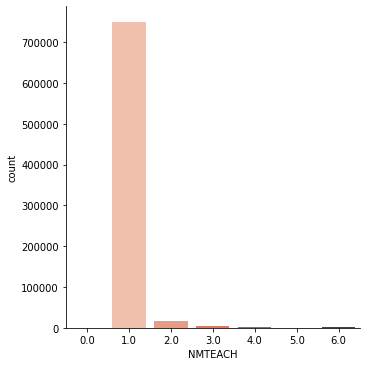

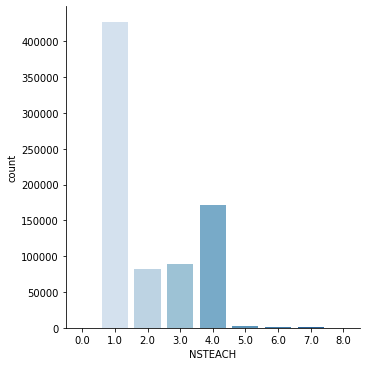

In [51]:
# plot the frequency of number of math and science teachers per individual student
sns.catplot(x='NMTEACH', kind='count', palette='Reds', data=stud_teach);
sns.catplot(x='NSTEACH', kind='count', palette='Blues', data=stud_teach);

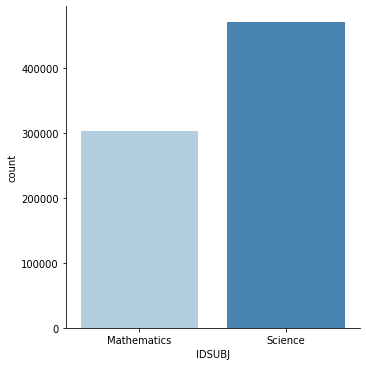

In [52]:
# plot the count of math and science teachers in the dataset
sns.catplot(x="IDSUBJ", kind="count", palette="Blues", data=stud_teach);

**Initial Observations about `stud_teach` dataset:**
* students are morel likey to have multiple science teachers than multiple math teachers
* there are more science teachers in the study than math teachers

**`stud_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers
* trim and convert IDGRADE to integers

In [53]:
# explore basic structure of the math_teach dataframe
math_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK     ITCOURSE  BTBG01  \
0   7842.0    5001.0  50010101.0  500101.0     1.0  Mathematics    17.0   
1   7842.0    5001.0  50010102.0  500101.0     2.0  Mathematics    17.0   
2   7842.0    5004.0  50040101.0  500401.0     1.0  Mathematics     1.0   
3   7842.0    5004.0  50040303.0  500403.0     3.0  Mathematics     6.0   
4   7842.0    5006.0  50060101.0  500601.0     1.0  Mathematics    10.0   

   BTBG02    BTBG03                                          BTBG04 BTBG05A  \
0    Male     40–49    <Master’s or equivalent level—ISCED Level 7>     Yes   
1    Male     40–49    <Master’s or equivalent level—ISCED Level 7>     Yes   
2    Male  Under 25  <Bachelor’s or equivalent level—ISCED Level 6>      No   
3    Male     30–39    <Master’s or equivalent level—ISCED Level 7>     Yes   
4  Female     40–49  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   

  BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I    BTBG06A  \
0      No     Yes     Yes      No     Yes     Yes      No      No  Very high   
1      No     Yes     Yes      No     Yes     Yes      No      No  Very high   
2      No      No      No      No      No      No      No     Yes  Very high   
3      No     Yes      No      No      No      No      No     Yes       High   
4      No      No      No      No     Yes      No      No      No  Very high   

     BTBG06B    BTBG06C    BTBG06D    BTBG06E    BTBG06F    BTBG06G  \
0  Very high       High  Very high        Low        Low        Low   
1  Very high       High  Very high        Low        Low        Low   
2  Very high  Very high  Very high  Very high  Very high  Very high   
3       High     Medium     Medium        Low        Low     Medium   
4       High  Very high       High       High       High       High   

     BTBG06H    BTBG06I    BTBG06J    BTBG06K    BTBG06L      BTBG07A  \
0     Medium     Medium     Medium       High  Very high  Agree a lot   
1     Medium     Medium     Medium       High  Very high  Agree a lot   
2  Very high  Very high  Very high  Very high  Very high  Agree a lot   
3        Low     Medium     Medium     Medium       High  Agree a lot   
4       High       High       High  Very high     Medium  Agree a lot   

       BTBG07B      BTBG07C         BTBG07D         BTBG07E         BTBG07F  \
0  Agree a lot  Agree a lot  Agree a little     Agree a lot  Agree a little   
1  Agree a lot  Agree a lot  Agree a little     Agree a lot  Agree a little   
2  Agree a lot  Agree a lot     Agree a lot     Agree a lot     Agree a lot   
3  Agree a lot  Agree a lot  Agree a little  Agree a little  Agree a little   
4  Agree a lot  Agree a lot     Agree a lot     Agree a lot     Agree a lot   

          BTBG07G         BTBG07H     BTBG08A     BTBG08B     BTBG08C  \
0     Agree a lot     Agree a lot  Very often  Very often  Very often   
1     Agree a lot     Agree a lot  Very often  Very often  Very often   
2     Agree a lot     Agree a lot  Very often  Very often  Very often   
3  Agree a little  Agree a little  Very often  Very often       Often   
4     Agree a lot     Agree a lot  Very often       Often  Very often   

      BTBG08D     BTBG08E         BTBG09A            BTBG09B  \
0  Very often  Very often  Disagree a lot  Disagree a little   
1  Very often  Very often  Disagree a lot  Disagree a little   
2  Very often  Very often  Agree a little        Agree a lot   
3       Often       Often  Agree a little     Agree a little   
4  Very often  Very often  Agree a little        Agree a lot   

             BTBG09C            BTBG09D         BTBG09E            BTBG09F  \
0     Agree a little     Disagree a lot  Disagree a lot     Disagree a lot   
1     Agree a little     Disagree a lot  Disagree a lot     Disagree a lot   
2  Disagree a little  Disagree a little     Agree a lot  Disagree a little   
3  Disagree a little  Disagree a little     Agree a lot  Disagree a little   
4     Agree a little     Agree a little  

In [54]:
# create list of math_teach columns to drop (null or single unique value)
math_teach_drop_new = list(math_teach.columns[math_teach.isna().all()])+list(math_teach.columns[math_teach.nunique()==1])

In [55]:
# add a redundant language column to be dropped
math_teach_drop_new = math_teach_drop_new + ['LCID_T']

In [56]:
# display the summary statistics for the quantitative values
math_teach.describe()

IDCNTRY      IDSCHOOL      IDTEALIN        IDTEACH        IDLINK  \
count   14571.000000  14571.000000  1.457100e+04   14571.000000  14571.000000   
mean    25861.760483   5139.824583  5.139846e+07  513984.606959      2.316039   
std    127761.944314    125.107698  1.251051e+06   12510.510896      4.010638   
min        36.000000   5001.000000  5.001010e+07  500101.000000      1.000000   
25%       372.000000   5055.000000  5.055010e+07  505501.000000      1.000000   
50%       554.000000   5108.000000  5.108050e+07  510805.000000      1.000000   
75%       784.000000   5177.000000  5.177010e+07  517701.000000      3.000000   
max    710004.000000   5631.000000  5.631020e+07  563102.000000     51.000000   

             BTBG01        BTBG10        BTBG11        BTBM14       BTBGEAS  \
count  13427.000000  13090.000000  12817.000000  12736.000000  13443.000000   
mean      15.726000     26.273415      3.074744    228.827418     10.264284   
std       10.505881     10.450771      6.940515     78.152219      2.174719   
min        0.000000      1.000000      0.000000      0.000000      0.873410   
25%        7.000000     20.000000      0.000000    180.000000      8.846900   
50%       14.000000     26.000000      0.000000    225.000000     10.051020   
75%       23.000000     31.000000      3.000000    270.000000     11.550050   
max       59.000000    118.000000    105.000000    700.000000     17.780680   

            BTBGLSN       BTBGSOS       BTBGTJS       BTDMNUM       BTDMALG  \
count  13198.000000  13376.000000  13421.000000  13195.000000  13189.000000   
mean       9.850015     10.420642      9.971230     98.147026     70.822475   
std        1.996385      2.154510      1.793995      8.467915     24.651900   
min        3.623690      4.426320      5.281180      0.000000      0.000000   
25%        8.632380      8.783370      8.482860    100.000000     57.142860   
50%        9.619100     10.072630     10.258740    100.000000     71.428570   
75%       11.288280     11.789980     11.745590    100.000000    100.000000   
max       15.295110     13.870350     11.745590    100.000000    100.000000   

            BTDMGEO       BTDMDAT  VERSION  
count  13174.000000  13149.000000  14571.0  
mean      76.294342     59.566127      4.0  
std       23.014936     35.533852      0.0  
min        0.000000      0.000000      4.0  
25%       66.666670     33.333330      4.0  
50%       83.333330     66.666670      4.0  
75%      100.000000    100.000000      4.0  
max      100.000000    100.000000      4.0

In [57]:
# display contextual information for a subset of the math_teach columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG' not in col],:]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
ITCOURSE                         Subject Code in instrument
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM15A               MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B              MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C                    MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D               MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E                MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F               MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G              MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H               MATH\ASK STUDENTS\SAME ABILITY GROUPS
BTBM16                    MATH\PERMITTED TO USE CALCULATORS
BTBM17A       MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA    MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB        MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC       MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA       MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB    MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC   MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD     MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBM18AA                        MATH\TOPIC\NUMBER\COMPUTING
BTBM18AB             MATH\TOPIC\NUMBER\CONCEPT OF FRACTIONS
BTBM18AC         MATH\TOPIC\NUMBER\SOLVING PROB PROPORTIONS
BTBM18BA                     MATH\TOPIC\ALGEBRA\SIMPLIFYING
BTBM18BB                MATH\TOPIC\ALGEBRA\LINEAR EQUATIONS
BTBM18BC             MATH\TOPIC\ALGEBRA\LINEAR INEQUALITIES
BTBM18BD           MATH\TOPIC\ALGEBRA\SIMULTANEOUS EQUATION
BTBM18BE                       MATH\TOPIC\ALGEBRA\FUNCTIONS
BTBM18BF             MATH\TOPIC\ALGEBRA\PROPERTIES OF FUNCS
BTBM18BG                         MATH\TOPIC\ALGEBRA\NUMERIC
BTBM18CA           MATH\TOPIC\GEOMETRY\GEOMETRIC PROPERTIES
BTBM18CB        MATH\TOPIC\GEOMETRY\SOLVING PROB PERIMETERS
BTBM18CC       MATH\TOPIC\GEOMETRY\SOLVING PROB PYTHAGOREAN
BTBM18CD                    MATH\TOPIC\GEOMETRY\TRANSLATION
BTBM18CE              MATH\TOPIC\GEOMETRY\CONGRUENT FIGURES
BTBM18CF        MATH\TOPIC\GEOMETRY\THREE-DIMENSIONAL SHAPE
BTBM18DA      MATH\TOPIC\DATA\READING AND INTERPRETING DATA
BTBM18DB             MATH\TOPIC\DATA\IDENTIFYING PROCEDURES
BTBM18DC   MATH\TOPIC\DATA\ORGANIZING AND REPRESENTING DATA
BTBM18DD  MATH\TOPIC\DATA\CALCULATING AND INTERPRETING S...
BTBM18DE          MATH\TOPIC\DATA\PROBABILITY SIMPLE EVENTS
BTBM18DF        MATH\TOPIC\DATA\PROBABILITY COMPOUND EVENTS
BTBM19A               MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B                         MATH\TIME SPENT ON HOMEWORK
BTBM19CA                  MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB                 MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC                     MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD                 MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE                       MATH\HOMEWORK\USE FOR GRADES
BTBM20A       MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B          MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C        MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D             MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E       MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBM21                    MATH\TESTS ON COMPUTER OR TABLETS
BTBM22AA            MATH\PROF DEVELOPMENT PAST\MATH CONTENT
BTBM22BA          MATH\PROF DEVELOPMENT FUTURE\MATH CONTENT
BTBM22AB           MATH\PROF DEVELOPMENT PAST\MATH PEDAGOGY
BTBM22BB         MATH\PROF DEVELOPMENT FUTURE\MATH PEDAGOGY
BTBM22AC         MATH\PROF DEVELOPMENT PAST\MATH CURRICULUM
BTBM22BC       MATH\PROF DEVELOPMENT FUTURE\MATH CURRICULUM
BTBM22AD  MATH\PROF DEVELOPMENT PA

In [58]:
# investigate datatypes in the dataframe
math_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDMNUM     float64
BTDMALG     float64
BTDMGEO     float64
BTDMDAT     float64
VERSION     float64
Length: 157, dtype: object

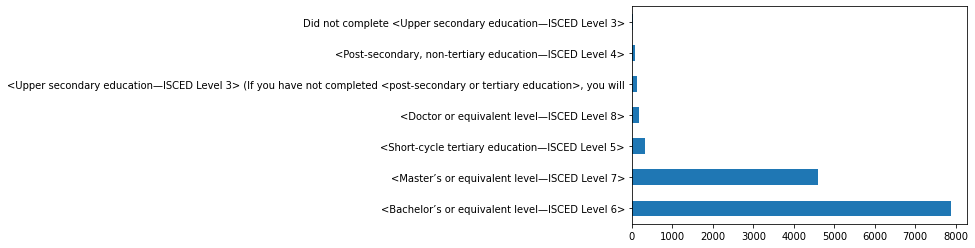

In [59]:
# graph frequency of educational achievement by the teachers in the dataframe
math_teach['BTBG04'].value_counts().plot(kind='barh');

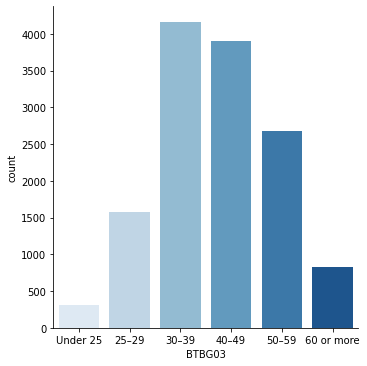

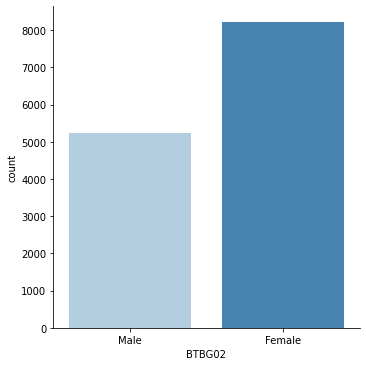

In [60]:
# create an ordinal categorical variable for the age of the teacher
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# impute the age as the ordinal type created above
math_teach['BTBG03'] = math_teach['BTBG03'].astype(cat_type)

# graph the age distribution of math teachers in the data
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
# graph the gender distribution of math teachers in the data
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);

**Initial Observations about `math_teach` dataset:**
* Approximately Normal distribution of teacher ages
* Teach education is highly concentrated in the Bachelor's and Master's level
* Significantly more female teacher than males

**`math_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
* drop BTBM22* columns because alreadys summarized in BTBM23
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

In [61]:
# explore basic structure of science teacher data
sci_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK            ITCOURSE  \
0   7842.0    5001.0  50010203.0  500102.0     3.0  Integrated science   
1   7842.0    5001.0  50010204.0  500102.0     4.0  Integrated science   
2   7842.0    5004.0  50040202.0  500402.0     2.0  Integrated science   
3   7842.0    5004.0  50040404.0  500404.0     4.0  Integrated science   
4   7842.0    5006.0  50060202.0  500602.0     2.0  Integrated science   

   BTBG01  BTBG02 BTBG03                                          BTBG04  \
0    30.0    Male  50–59    <Master’s or equivalent level—ISCED Level 7>   
1    30.0    Male  50–59    <Master’s or equivalent level—ISCED Level 7>   
2    10.0    Male  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   
3     4.0  Female  25–29    <Master’s or equivalent level—ISCED Level 7>   
4    11.0  Female  40–49  <Bachelor’s or equivalent level—ISCED Level 6>   

  BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I  \
0      No     Yes     Yes     Yes     Yes      No     Yes      No      No   
1      No     Yes     Yes     Yes     Yes      No     Yes      No      No   
2      No      No      No      No      No      No     Yes     Yes     Yes   
3      No     Yes     Yes     Yes      No      No     Yes      No     Yes   
4     Yes     Yes     Yes     Yes      No      No      No      No      No   

     BTBG06A    BTBG06B BTBG06C    BTBG06D BTBG06E   BTBG06F    BTBG06G  \
0       High       High  Medium       High  Medium       Low       High   
1       High       High  Medium       High  Medium       Low       High   
2       High       High    High       High     Low  Very low        Low   
3       High     Medium  Medium       High  Medium    Medium       High   
4  Very high  Very high    High  Very high    High      High  Very high   

     BTBG06H    BTBG06I BTBG06J BTBG06K    BTBG06L      BTBG07A      BTBG07B  \
0        Low     Medium  Medium  Medium  Very high  Agree a lot  Agree a lot   
1        Low     Medium  Medium  Medium  Very high  Agree a lot  Agree a lot   
2   Very low        Low  Medium     Low       High  Agree a lot  Agree a lot   
3     Medium       High  Medium    High       High  Agree a lot  Agree a lot   
4  Very high  Very high    High    High       High  Agree a lot  Agree a lot   

          BTBG07C            BTBG07D            BTBG07E         BTBG07F  \
0     Agree a lot     Agree a little     Agree a little     Agree a lot   
1     Agree a lot     Agree a little     Agree a little     Agree a lot   
2  Agree a little  Disagree a little  Disagree a little  Disagree a lot   
3     Agree a lot        Agree a lot        Agree a lot     Agree a lot   
4     Agree a lot        Agree a lot        Agree a lot     Agree a lot   

          BTBG07G            BTBG07H     BTBG08A     BTBG08B     BTBG08C  \
0     Agree a lot        Agree a lot  Very often  Very often  Very often   
1     Agree a lot        Agree a lot  Very often  Very often  Very often   
2  Agree a little  Disagree a little  Very often       Often       Often   
3     Agree a lot        Agree a lot  Very often  Very often  Very often   
4     Agree a lot        Agree a lot  Very often  Very often  Very often   

      BTBG08D     BTBG08E            BTBG09A            BTBG09B  \
0  Very often  Very often     Agree a little        Agree a lot   
1  Very often  Very often     Agree a little        Agree a lot   
2       Often       Often        Agree a lot        Agree a lot   
3  Very often  Very often     Agree a little  Disagree a little   
4  Very often  Very often  Disagree a little     Agree a little   

             BTBG09C         BTBG09D         BTBG09E         BTBG09F  \
0        Agree a lot  Agree a little     Agree a lot     Agree a lot   
1        Agree a lot  Agree a little     Agree a lot     Agree a lot   
2  Disagree a little  Agree a little  Agree a little  Disagree a lot   
3  Disagree a little  Agree a little  Agree a little  Disagree a lot   
4  Disagree a little     Agree a lo

In [62]:
# create a list of columns to drop (null or single unique value)
sci_teach_drop_new = list(sci_teach.columns[sci_teach.isna().all()])+list(sci_teach.columns[sci_teach.nunique()==1])

In [63]:
# add redundant languge column to be dropped
sci_teach_drop_new = sci_teach_drop_new + ['LCID_T']

In [64]:
# display contextual information for some of the data
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG' not in col],:].iloc[5:,:]

Label
Variable                                                   
ITCOURSE                         Subject Code in instrument
BTBS14                     SCI\TIME SPENT SCI INSTR MINUTES
BTBS15A                SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B                  SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C             SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D                   SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E                SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F                       SCI\ASK STUDENTS\PRESENT DATA
BTBS15G                     SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H            SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I                     SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J                     SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K                       SCI\ASK STUDENTS\USE FORMULAS
BTBS15L                      SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M               SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N                SCI\ASK STUDENTS\SAME ABILITY GROUPS
BTBS16A         SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA     SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB         SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC        SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA        SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB     SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC    SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD      SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBS17AA         SCI\TOPIC\BIO\DIFFERENCES TAXONOMIC GROUPS
BTBS17AB                         SCI\TOPIC\BIO\MAJOR ORGANS
BTBS17AC             SCI\TOPIC\BIO\CELLS AND THEIR FUNCTION
BTBS17AD                         SCI\TOPIC\BIO\REPRODUCTION
BTBS17AE                    SCI\TOPIC\BIO\ROLE OF VARIATION
BTBS17AF        SCI\TOPIC\BIO\INTERDEPENDENCE OF POPULATION
BTBS17AG                         SCI\TOPIC\BIO\HUMAN HEALTH
BTBS17BA               SCI\TOPIC\CHEM\PARTICULATE STRUCTURE
BTBS17BB                      SCI\TOPIC\CHEM\PERIODIC TABLE
BTBS17BC            SCI\TOPIC\CHEM\PHY CHEM PROPERTY MATTER
BTBS17BD              SCI\TOPIC\CHEM\MIXTURES AND SOLUTIONS
BTBS17BE                     SCI\TOPIC\CHEM\ACIDS AND BASES
BTBS17BF                  SCI\TOPIC\CHEM\CHEMICAL REACTIONS
BTBS17BG                   SCI\TOPIC\CHEM\MATTER AND ENERGY
BTBS17BH                   SCI\TOPIC\CHEM\ROLE OF ELECTRONS
BTBS17CA                      SCI\TOPIC\PHY\PHYSICAL STATES
BTBS17CB                SCI\TOPIC\PHY\ENERGY TRANSFORMATION
BTBS17CC            SCI\TOPIC\PHY\BASIC PROPERTIES OF LIGHT
BTBS17CD            SCI\TOPIC\PHY\BASIC PROPERTIES OF SOUND
BTBS17CE                    SCI\TOPIC\PHY\ELECTRIC CIRCUITS
BTBS17CF                   SCI\TOPIC\PHY\PROPERTIES MAGNETS
BTBS17CG                    SCI\TOPIC\PHY\MOTION AND FORCES
BTBS17DA                   SCI\TOPIC\EARTH\EARTHS STRUCTURE
BTBS17DB                   SCI\TOPIC\EARTH\EARTHS PROCESSES
BTBS17DC                   SCI\TOPIC\EARTH\EARTHS RESOURCES
BTBS17DD              SCI\TOPIC\EARTH\EARTH IN SOLAR SYSTEM
BTBS18A                 SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B                          SCI\TIME SPENT ON HOMEWORK
BTBS18CA                   SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB                  SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC                      SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD                  SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE                        SCI\HOMEWORK\USE FOR GRADES
BTBS19A        SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B           SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C         SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D              SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E        SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBS20                     SCI\TESTS ON COMPUTER OR TABLETS
BTBS21AA          SCI\PROF DEVELOPMENT PAST\SCIENCE CONTENT
BTBS21BA        SCI\PROF DEVELOPMENT FUTURE\SCIENCE CONTENT
BTBS21AB         SCI\PROF DEVELOPM

In [65]:
# display descriptive statistics for quantitative variables in the dataset
sci_teach.describe()

IDCNTRY      IDSCHOOL      IDTEALIN        IDTEACH        IDLINK  \
count   22648.000000  22648.000000  2.264800e+04   22648.000000  22648.000000   
mean    31454.742759   5130.338661  5.130378e+07  513037.700371      5.529981   
std    139064.866672    112.485862  1.124852e+06   11248.526185      8.923136   
min        36.000000   5001.000000  5.001010e+07  500101.000000      1.000000   
25%       348.000000   5053.000000  5.053071e+07  505307.000000      2.000000   
50%       458.000000   5106.000000  5.106030e+07  510603.000000      3.000000   
75%       752.000000   5169.000000  5.169020e+07  516902.000000      5.000000   
max    710004.000000   5631.000000  5.631030e+07  563103.000000     53.000000   

             BTBG01        BTBG10        BTBG11        BTBS14       BTBGEAS  \
count  20738.000000  20234.000000  19792.000000  19816.000000  20855.000000   
mean      16.965956     25.370515      2.941188    139.375101     10.238353   
std       11.146168      9.939160      7.179479     78.428047      2.104111   
min        0.000000      1.000000      0.000000      0.000000      0.873410   
25%        8.000000     20.000000      0.000000     90.000000      8.846900   
50%       15.000000     25.000000      0.000000    120.000000     10.051020   
75%       25.000000     30.000000      3.000000    180.000000     11.550050   
max       60.000000    117.000000    111.000000    700.000000     17.780680   

            BTBGLSN       BTBGSOS       BTBGTJS       BTBSESI       BTDSBIO  \
count  20440.000000  20700.000000  20794.000000  20561.000000  12694.000000   
mean      10.030577     10.444209      9.826156      9.646790     74.968790   
std        1.979319      2.116645      1.815395      2.190059     23.169797   
min        3.623690      4.426320      5.281180      6.513090      0.000000   
25%        8.632380      8.783370      8.482860      8.038700     57.142860   
50%       10.145090     10.072630     10.258740      9.836960     71.428570   
75%       11.288280     11.789980     11.745590     10.968860    100.000000   
max       15.295110     13.870350     11.745590     16.032560    100.000000   

            BTDSCHE       BTDSPHY       BTDSEAR  VERSION  
count  12809.000000  12849.000000  11876.000000  22648.0  
mean      75.931311     70.421378     73.435921      4.0  
std       23.687424     25.143445     34.276024      0.0  
min        0.000000      0.000000      0.000000      4.0  
25%       62.500000     57.142860     50.000000      4.0  
50%       75.000000     71.428570    100.000000      4.0  
75%      100.000000    100.000000    100.000000      4.0  
max      100.000000    100.000000    100.000000      4.0

In [66]:
# display datatypes
sci_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDSBIO     float64
BTDSCHE     float64
BTDSPHY     float64
BTDSEAR     float64
VERSION     float64
Length: 168, dtype: object

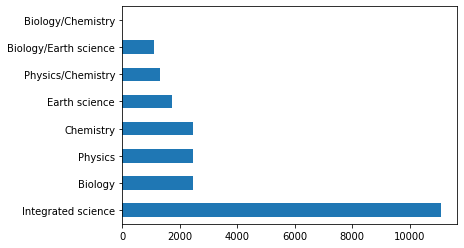

In [67]:
# graph the frequency of each science course taught
sci_teach['ITCOURSE'].value_counts().plot(kind='barh');

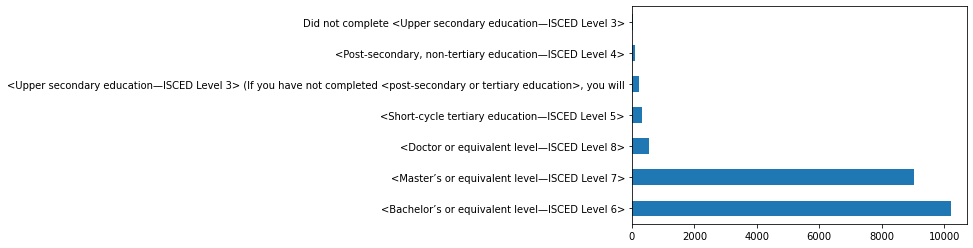

In [68]:
# visualize the frequency of educational achievement for science teachers
sci_teach['BTBG04'].value_counts().plot(kind='barh');

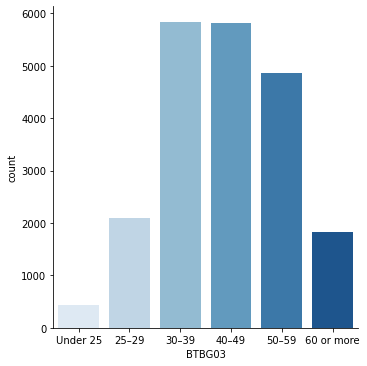

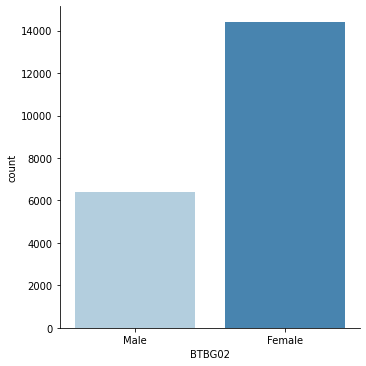

In [69]:
# create an ordinal categorical varialge for age groups
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# apply ordinal categorical to age data
sci_teach['BTBG03'] = sci_teach['BTBG03'].astype(cat_type)

# graph the age distribution for science teachers
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
# graph the gender distribution for science teachers
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);

**Initial Observations about `sci_teach` dataset:**
* Approximately Normal distribution of teacher ages (slightly older than math teachers)
* Teach education is highly concentrated in the Bachelor's and Master's level (slightly more educated that math teachers)
* Significantly more female teacher than males (more significant difference than math teachers)
* Most schools offer Integrated Science as compared to specific disciplines

**`sci_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
* drop BTBS21* columns because alreadys summarized in BTBM22
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

[Return to Top](#top)

<div id='data_preparation'></div>

# Data Preparation

Jump to:
1. [`stud_ach Preparation`](#prep1)
1. [`school Preparation`](#prep2)
1. [`student Preparation`](#prep3)
1. [`stud_teach Preparation`](#prep4)
1. [`math_teach Preparation`](#prep5)
1. [`sci_teach Preparation`](#prep6)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep1'></div>

**`stud_ach` Data Preparation**
* ~~drop unnecessary (or null) columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integer~~
* ~~rename all columns to be more descriptive~~

#### Define
* drop unnecessary (or null) columns

#### Code

In [70]:
# drop the null and single-value columns
stud_ach.drop(columns=stud_ach_drop_new, inplace=True)
# drop the redundant language column
stud_ach.drop(columns=['LCID_SA'], inplace=True)

#### Test

In [71]:
# check for no overlap between the dropped columns and the remaining columns
set(stud_ach_drop_new) & set(stud_ach.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers

#### Code

In [72]:
# convert each of the columns into integer type
stud_ach['IDCNTRY'] = stud_ach['IDCNTRY'].astype(int)
stud_ach['IDSCHOOL'] = stud_ach['IDSCHOOL'].astype(int)
stud_ach['IDCLASS'] = stud_ach['IDCLASS'].astype(int)
stud_ach['IDSTUD'] = stud_ach['IDSTUD'].astype(int)

#### Test

In [73]:
# confirm change in datatype
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK          object
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE         object
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* trim and convert IDBOOK, IDGRADE to integer

#### Code

In [74]:
# take only the digits from the strings and convert to integer
stud_ach['IDBOOK'] = stud_ach['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
stud_ach['IDGRADE'] = stud_ach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [75]:
# confirm change in datatype 
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK           int32
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE          int32
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [76]:
# create dictionary for renaming the columns
stud_ach_col_dict = {'ITLANG_SA':'language','IDGRADE':'grade','ITSEX':'sex','BSDAGE':'age','IDBOOK':'test_book'}
# rename the columns
stud_ach.rename(columns=stud_ach_col_dict, inplace=True)

#### Test

In [77]:
# check all columns that are not assessment item scores, category averages or standard deviations
[col for col in stud_ach.columns if '_avg' not in col and '_val' not in col and '_sd' not in col]

['IDCNTRY',
 'test_book',
 'IDSCHOOL',
 'IDCLASS',
 'IDSTUD',
 'grade',
 'language',
 'sex',
 'age']

[Return to Top of Data Preparation](#data_preparation)

<div id='prep2'></div>

**`school` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL to integers~~
* ~~trim and convert IDGRADE to integer~~
* ~~convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance by school~~

#### Define
* Drop repetitive columns from the dataset

#### Code

In [78]:
# drop the null or single-value columns
school.drop(columns=school_drop_new,inplace=True)
# drop the redundant language column
school.drop(columns=['LCID_C'], inplace=True)

#### Test

In [79]:
# verify dropped columns
set(school_drop_new) & set(school.columns)

set()

#### Define
* Convert IDCNTRY, IDSCHOOL to integers

#### Code

In [80]:
school['IDCNTRY'] = school['IDCNTRY'].astype(int)
school['IDSCHOOL'] = school['IDSCHOOL'].astype(int)

#### Test

In [81]:
# confirm change in datatype
school.dtypes[:5]

IDCNTRY       int32
IDSCHOOL      int32
IDGRADE      object
ITLANG_C     object
BCBGDAS     float64
dtype: object

#### Define
* Trim and convert IDGRADE to integer (8 or 9)

#### Code

In [82]:
# grab the digit from the string and convert it to integer
school['IDGRADE'] = school['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [83]:
# verify the unique values in IDGRADE
school['IDGRADE'].unique()

array([8, 9])

#### Define
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals

#### Code

In [84]:
# create a list of all indices measuring school traits
school_indices = ['BCDGDAS', 'BCDGEAS', 'BCDGMRS', 'BCDGSRS', 'BCDGSBC']
# go through each of the indices
for col in school_indices:
    # print the contextual information for the index
    print(school_codes.loc[col,:])
    # print the unique values for the index
    print(school[col].unique())

Label    School Discipline Problems-Prncpl/IDX
Name: BCDGDAS, dtype: object
['Minor Problems' 'Hardly Any Problems' nan 'Moderate to Severe Problems']
Label    School Emph on Acad Success-Prncpl/IDX
Name: BCDGEAS, dtype: object
['Medium Emphasis' 'High Emphasis' 'Very High Emphasis' nan]
Label    Instr Aff by Mat Res Shortage-Prncpl/IDX
Name: BCDGMRS, dtype: object
['Not Affected' 'Affected' 'Affected A Lot' nan]
Label    Instr Aff by Sci Res Shortage-Prncpl/IDX
Name: BCDGSRS, dtype: object
['Not Affected' 'Affected A Lot' nan 'Affected']
Label    School Composition by Socioeconomic Background
Name: BCDGSBC, dtype: object
['Neither More Affluent nor More Disadvantaged' 'More Affluent'
 'More Disadvantaged' nan]


In [85]:
# create an ordinal categorical variable for discipline problems
disc_prob_type = CategoricalDtype(categories=['Hardly Any Problems','Minor Problems','Moderate to Severe Problems'], ordered=True)
# create new column with ordinal type
school['disc_prob'] = school['BCDGDAS'].astype(disc_prob_type)
# create an ordinal categorical variable for academic emphasis
acad_emph_type = CategoricalDtype(categories=['Medium Emphasis', 'High Emphasis', 'Very High Emphasis'], ordered=True)
# create new column with ordinal type
school['acad_emph'] = school['BCDGEAS'].astype(acad_emph_type)
# create an ordinal categorical variable for affect of shortages
shortage_affect_type = CategoricalDtype(categories=['Not Affected', 'Affected', 'Affected A Lot'], ordered=True)
# create new columns with ordinal type
school['math_shortage'] = school['BCDGMRS'].astype(shortage_affect_type)
school['sci_shortage'] = school['BCDGSRS'].astype(shortage_affect_type)
# create an ordinal categorical variable for socioeconomic background
school_socio_type = CategoricalDtype(categories=['More Disadvantaged', 'Neither More Affluent nor More Disadvantaged', 'More Affluent'], ordered=True)
# create new column with ordinal type
school['socio_background'] = school['BCDGSBC'].astype(school_socio_type)
# drop the previous columns, leaving the ordinal columns
school.drop(columns=school_indices, inplace=True)

#### Test

In [86]:
# confirm datatypes
school.dtypes

IDCNTRY                int32
IDSCHOOL               int32
IDGRADE                int32
ITLANG_C              object
BCBGDAS              float64
BCBGEAS              float64
BCBGMRS              float64
BCBGSRS              float64
BCDGTIHY             float64
disc_prob           category
acad_emph           category
math_shortage       category
sci_shortage        category
socio_background    category
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [87]:
# create a dictionary for renaming columns
school_col_dict = {'BCBGDAS':'disc_prob_score','BCBGEAS':'acad_emph_score','BCBGMRS':'math_shortage_score','BCBGSRS':'sci_shortage_score','BCDGTIHY':'acad_hours','ITLANG_C':'language','IDGRADE':'grade'}
# rename columns
school.rename(columns=school_col_dict,inplace=True)

#### Test

In [88]:
# confirm rename of columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background'],
      dtype='object')

#### Define
* merge with student performance by school

#### Code

In [89]:
# confirm student achievement data grouped by IDCNTRY and IDSCHOOL
stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      512.160420  528.909690  498.302685  521.510511  531.893457   
        5002      500.057398  525.348892  480.069888  501.129069  521.833812   
        5003      525.973490  533.678966  511.335672  529.865375  544.964311   
        5004      568.834716  582.543276  557.924186  572.206090  585.849087   
        5005      458.656151  478.569777  444.118141  460.885134  471.541118   
...                      ...         ...         ...         ...         ...   
710004  5506      452.359804  468.081983  462.101839  455.212580  438.792544   
        5516      602.888115  632.628227  626.841950  597.759074  583.927258   
        5517      419.186459  395.377530  429.928165  421.909539  415.132096   
        5518      386.538689  389.442015  388.189399  390.103950  381.652148   
        5520      540.502919  564.136019  545.918544  536.166104  528.333465   

                    mgeo_avg    mkno_avg    mnum_avg    mrea_avg    sapp_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      510.723844  506.440412  516.348085  513.322954  536.406658   
        5002      495.260373  493.117152  505.968088  495.033254  533.047731   
        5003      519.626145  517.451107  531.761602  521.959500  538.120939   
        5004      566.528514  552.770096  580.028650  567.582195  587.872312   
        5005      452.514983  450.811446  456.019090  451.648922  481.027424   
...                      ...         ...         ...         ...         ...   
710004  5506      439.539107  445.538925  455.938441  460.605905  473.185123   
        5516      588.903224  607.187292  609.126282  599.514280  629.275423   
        5517      411.644396  413.414427  428.663409  426.951825  410.715863   
        5518      375.569264  366.523464  391.213308  401.814731  394.776448   
        5520      531.399344  534.928037  537.833104  543.095488  579.713074   

                    sbio_avg    sche_avg    sear_avg    skno_avg    sphy_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      530.658886  514.227199  535.867503  507.441620  528.110842   
        5002      532.758198  512.284051  541.315108  514.368975  529.544135   
        5003      532.310956  526.377450  542.737756  525.064673  537.782550   
        5004      587.439474  577.372379  586.673154  575.790927  580.311813   
        5005      472.061751  452.380780  477.753128  461.967294  475.214976   
...                      ...         ...         ...         ...         ...   
710004  5506      454.353800  471.234008  465.058587  454.253831  465.100969   
        5516      634.215849  644.136851  635.950862  624.911290  613.534277   
        5517      396.357939  404.610874  408.782505  391.827735  407.385845   
        5518      380.595840  378.696205  401.607907  373.246617  386.977013   
        5520      563.955841  571.377793  577.770288  564.587764  559.173107   

                    srea_avg  
IDCNTRY IDSCHOOL              
36      5001      532.552107  
        5002      534.525980  
        5003      537.392486  
        5004      590.738231  
        5005      495.105472  
...                      ...  
710004  5506      473.847294  
        5516      636.991715  
        5517      391.658714  
        5518      383.254652  
        5520      561.533043  

[9397 rows x 16 columns]

In [90]:
# confirm school data indexed by IDCNTRY and IDSCHOOL
school.set_index(['IDCNTRY','IDSCHOOL'])

grade   language  disc_prob_score  acad_emph_score  \
IDCNTRY IDSCHOOL                                                       
7842    5001          8    English          9.79606          7.03177   
        5004          8    English         10.10482          9.56054   
        5006          8    English         10.43939         11.35999   
        5007          8    English         12.80218         13.19357   
        5008          8    English         14.02858         13.19357   
...                 ...        ...              ...              ...   
710004  5506          9    English          8.24184          7.03177   
        5516          9    English         14.02858         16.36222   
        5517          9  Afrikaans          8.41206          8.67341   
        5518          9  Afrikaans          8.08398          7.39368   
        5520          9  Afrikaans         14.02858         16.36222   

                  math_shortage_score  sci_shortage_score  acad_hours  \
IDCNTRY IDSCHOOL                                                        
7842    5001                 14.25596            14.57241  1350.00000   
        5004                 12.92960            14.57241  1680.00000   
        5006                  8.03304             7.45575  1281.00000   
        5007                 12.29366            12.50979  1311.50000   
        5008                  4.23486             4.07624         NaN   
...                               ...                 ...         ...   
710004  5506                  9.41874             9.46956  1172.50000   
        5516                 14.25596            14.57241  1013.25000   
        5517                 10.21426            10.17656  1100.00000   
        5518                  9.62794             9.57915  1061.33333   
        5520                 14.25596            14.57241  1200.00000   

                            disc_prob           acad_emph   math_shortage  \
IDCNTRY IDSCHOOL                                                            
7842    5001           Minor Problems     Medium Emphasis    Not Affected   
        5004           Minor Problems     Medium Emphasis    Not Affected   
        5006           Minor Problems       High Emphasis        Affected   
        5007      Hardly Any Problems  Very High Emphasis    Not Affected   
        5008      Hardly Any Problems  Very High Emphasis  Affected A Lot   
...                               ...                 ...             ...   
710004  5506           Minor Problems     Medium Emphasis        Affected   
        5516      Hardly Any Problems  Very High Emphasis    Not Affected   
        5517           Minor Problems     Medium Emphasis        Affected   
        5518           Minor Problems     Medium Emphasis        Affected   
        5520      Hardly Any Problems  Very High Emphasis    Not Affected   

                    sci_shortage                              socio_background  
IDCNTRY IDSCHOOL                                                                
7842    5001        Not Affected  Neither More Affluent nor More Disadvantaged  
        5004        Not Affected                                 More Affluent  
        5006      Affected A Lot                                 More Affluent  
        5007        Not Affected                                 More Affluent  
        5008      Affected A Lot  Neither More Affluent nor More Disadvantaged  
...                          ...                                           ...  
710004  5506            Affected                            More Disadvantaged  
        5516        Not Affected                                 More Affluent  
        5517            Affected                            More Disadvantaged  
        5518            Affected                            More Disadvantaged  
        5520        Not Affected                                 More Affluent  

[9925 rows x 12 columns]

In [91]:
# combine the student achievement data to the school dataframe
school = school.set_index(['IDCNTRY','IDSCHOOL']).join(stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [92]:
# confirm that school dataframe now has assessment columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

[Return to Top of Data Preparation](#data_preparation)

<div id='prep3'></div>

**`student` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integers~~
* ~~convert to integer and combine BSBG05* columns to home_possession column~~
* ~~convert to string and combine BSBG09* columns to ordered categorical age_immigration column~~
* ~~convert to integer and combine BSBG12* columns to internet_access column~~
* ~~convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals~~
* ~~trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)~~
* ~~convert BSBG08* to boolean~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance~~

#### Define
* drop unnecessary columns

#### Code

In [93]:
student_drop_new = student_drop_new + ['LCID_SQ','ITLANG_SA','LCID_SA']
student.drop(columns=student_drop_new, inplace=True)

#### Test

In [94]:
# confirm columns dropped
set(student_drop_new) & set(student.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers

#### Code

In [95]:
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']] = student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']].astype(int)
# take the digits from IDBOOK and IDGRADE
student['IDBOOK'] = student['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
student['IDGRADE'] = student['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [96]:
# confirm change in datatypes
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD','IDBOOK','IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDCLASS     int32
IDSTUD      int32
IDBOOK      int32
IDGRADE     int32
dtype: object

#### Define
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG12* columns to internet_access column

#### Code

In [97]:
# dictionary for creating the new combined columns
conv_col = {'BSBG05':'home_possession','BSBG12':'internet_access'}
# go through each set of columns
for base_col in conv_col.keys():
    # gather the list of all columns matching the prefix
    all_cols = [col for col in student.columns if base_col in col]
    # go through each matching column
    for i, single_col in enumerate(all_cols):
        # if it is is the first column
        if i == 0:
            # create the new column with 1 for Yes, 0 for No, or NaN for null
            student[conv_col[base_col]] = student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
        # otherwise, add any subsequent values to the previous sum
        else:
            # add any subsequent values to the previous sum (1 for Yes, 0 for No, or NaN for null)
            student[conv_col[base_col]] = student[conv_col[base_col]] + student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
    # drop all matching columns for the new combined columns
    student.drop(columns=all_cols, inplace=True)

#### Test

In [98]:
# confirm new columns
student.columns

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'BSBG03',
       'BSBG04', 'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B',
       'BSBG09A', 'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'IDGRADE',
       'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSDGHER', 'BSBGSSB',
       'BSDGSSB', 'BSBGSB', 'BSDGSB', 'BSBGSLM', 'BSDGSLM', 'BSBGICM',
       'BSDGICM', 'BSBGDML', 'BSDGDML', 'BSBGSCM', 'BSDGSCM', 'BSBGSVM',
       'BSDGSVM', 'BSBGSLS', 'BSDGSLS', 'BSBGICS', 'BSDGICS', 'BSBGSCS',
       'BSDGSCS', 'BSBGSVS', 'BSDGSVS', 'BSBGSLB', 'BSDGSLB', 'BSBGICB',
       'BSDGICB', 'BSBGSCB', 'BSDGSCB', 'BSBGSLE', 'BSDGSLE', 'BSBGICE',
       'BSDGICE', 'BSBGSCE', 'BSDGSCE', 'BSBGSLC', 'BSDGSLC', 'BSBGICC',
       'BSDGICC', 'BSBGSCC', 'BSDGSCC', 'BSBGSLP', 'BSDGSLP', 'BSBGICP',
       'BSDGICP', 'BSBGSCP', 'BSDGSCP', 'BSBGSEC', 'BSDGSEC', 'BSDG05S',
       'BSDGEDUP', 'home_possession', 'internet_access'],
      dtype='object')

In [99]:
# confirm datatypes
student[['home_possession','internet_access']].dtypes

home_possession    float64
internet_access    float64
dtype: object

#### Define
* convert to string and combine BSBG09* columns to ordered categorical age_immigration column

#### Code

In [100]:
# print the different values for each BSBG09 column
for col in [col for col in student.columns if 'BSBG09' in col]:
    print(student[col].unique())

['Yes' 'No' nan]
[nan '5 to 10 years old' 'Younger than 5 years old'
 'Older than 10 years old']


In [101]:
def age_immigration_col(x):
    '''
    combines both immigration columns into a single values
    
    INPUT:
    x - (list with two values)   Yes/No for born in country
                                 Age range when immigrated in country
    
    OUTPUT:
    a value representing age range when immigrated ('Birth' for born in country)
    '''
    # if born in country, return 'Birth'
    if x[0] == 'Yes':
        return('Birth')
    # otherwise, return age range of immigration
    else:
        return(x[1])

In [102]:
# use the age_immigration_col function to combine the two immigration columns
student['age_immigration'] = student[['BSBG09A','BSBG09B']].apply(age_immigration_col, axis = 1)
# delete the previous immigration columns
student.drop(columns=['BSBG09A','BSBG09B'], inplace=True)

In [103]:
# create ordinal categorical type for immigration age
immigration_type = CategoricalDtype(categories=['Birth','Younger than 5 years old','5 to 10 years old', 'Older than 10 years old'], ordered=True)
student['age_immigration'] = student['age_immigration'].astype(immigration_type)

#### Test

In [104]:
# confirm change in datatype
student[[col for col in student.columns if 'BSBG09' in col or 'immigration' in col]].dtypes

age_immigration    category
dtype: object

#### Define
* convert BSBG03, BSBG04, BSBG10, BSBG11, BSDG columns to ordered categoricals

#### Code

In [105]:
# print the context label and unique values for each column matching the column prefixes
new_cat_cols = ['BSBG03', 'BSBG04', 'BSBG10', 'BSBG11', 'BSDG']
for col_root in new_cat_cols:
    for col in student.columns:
        if col_root in col:
            print(student[col].unique())
            print(student_codes.loc[col,:])

['Almost always' 'Always' nan 'Sometimes' 'Never']
Label    GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
Name: BSBG03, dtype: object
['Enough to fill one shelf (11–25 books)' 'None or very few (0–10 books)'
 nan 'Enough to fill one bookcase (26–100 books)'
 'Enough to fill two bookcases (101–200 books)'
 'Enough to fill three or more bookcases (more than 200)']
Label    GEN\AMOUNT OF BOOKS IN YOUR HOME
Name: BSBG04, dtype: object
['Never or almost never' 'Once a week' 'Once every two month'
 'Once a month' 'Once every two weeks' nan]
Label    GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
Name: BSBG10, dtype: object
['Sometimes' 'Every day' 'Almost every day' 'Never' nan]
Label    GEN\HOW OFTEN\TIRED
Name: BSBG11A, dtype: object
['Sometimes' nan 'Every day' 'Never' 'Almost every day']
Label    GEN\HOW OFTEN\HUNGRY
Name: BSBG11B, dtype: object
['Some Resources' 'Few Resources' 'Many Resources' nan]
Label    Home Educational Resources/IDX
Name: BSDGHER, dtype: object
['High Sense of School Belonging' 

In [106]:
# create a blank dictionary to store all of the changes to the columns summarized above
info = {}
# each entry in the dictionary contains the column prefix as the key, then a new name for the column, then the ordinal values of the categories
info['BSBG03'] = {'new_name':'acad_lang_home','ordered_cols':['Never','Sometimes','Almost always','Always']}
info['BSBG04'] = {'new_name':'books','ordered_cols':['None or very few (0–10 books)','Enough to fill one shelf (11–25 books)',
                                                     'Enough to fill one bookcase (26–100 books)','Enough to fill two bookcases (101–200 books)',
                                                     'Enough to fill three or more bookcases (more than 200)']}
info['BSBG10'] = {'new_name':'absent_freq','ordered_cols':['Never or almost never','Once every two month','Once a month','Once every two weeks','Once a week']}
info['BSBG11A'] = {'new_name':'tired_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSBG11B'] = {'new_name':'hungry_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSDGHER'] = {'new_name':'home_res','ordered_cols':['Few Resources','Some Resources','Many Resources']}
info['BSDGSSB'] = {'new_name':'belonging','ordered_cols':['Little Sense of School Belonging','Some Sense of School Belonging','High Sense of School Belonging']}
info['BSDGSB'] = {'new_name':'bullying','ordered_cols':['Never or Almost Never','About Monthly','About Weekly']}
info['BSDGSLM'] = {'new_name':'like_math','ordered_cols':['Do Not Like Learning Mathematics','Somewhat Like Learning Mathematics','Very Much Like Learning Mathematics']}
info['BSDGICM'] = {'new_name':'clear_math','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGDML'] = {'new_name':'disorder_math','ordered_cols':['Few or No Lessons','Some Lessons','Most Lessons']}
info['BSDGSCM'] = {'new_name':'confident_math','ordered_cols':['Not Confident in Mathematics','Somewhat Confident in Mathematics','Very Confident in Mathematics']}
info['BSDGSVM'] = {'new_name':'value_math','ordered_cols':['Do Not Value Mathematics','Somewhat Value Mathematics','Strongly Value Mathematics']}
info['BSDGSLS'] = {'new_name':'like_science','ordered_cols':['Do Not Like Learning Science','Somewhat Like Learning Science','Very Much Like Learning Science']}
info['BSDGICS'] = {'new_name':'clear_science','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCS'] = {'new_name':'confident_science','ordered_cols':['Not Confident in Science','Somewhat Confident in Science','Very Confident in Science']}
info['BSDGSVS'] = {'new_name':'value_science','ordered_cols':['Do Not Value Science','Somewhat Value Science','Strongly Value Science']}
info['BSDGSLB'] = {'new_name':'like_bio','ordered_cols':['Do Not Like Learning Biology','Somewhat Like Learning Biology','Very Much Like Learning Biology']}
info['BSDGICB'] = {'new_name':'clear_bio','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCB'] = {'new_name':'confident_bio','ordered_cols':['Not Confident in Biology','Somewhat Confident in Biology','Very Confident in Biology']}
info['BSDGSLE'] = {'new_name':'like_earth','ordered_cols':['Do Not Like Learning Earth Science','Somewhat Like Learning Earth Science','Very Much Like Learning Earth Science']}
info['BSDGICE'] = {'new_name':'clear_earth','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCE'] = {'new_name':'confident_earth','ordered_cols':['Not Confident in Earth Science','Somewhat Confident in Earth Science','Very Confident in Earth Science']}
info['BSDGSLC'] = {'new_name':'like_chem','ordered_cols':['Do Not Like Learning Chemistry','Somewhat Like Learning Chemistry','Very Much Like Learning Chemistry']}
info['BSDGICC'] = {'new_name':'clear_chem','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCC'] = {'new_name':'confident_chem','ordered_cols':['Not Confident in Chemistry','Somewhat Confident in Chemistry','Very Confident in Chemistry']}
info['BSDGSLP'] = {'new_name':'like_phys','ordered_cols':['Do Not Like Learning Physics','Somewhat Like Learning Physics','Very Much Like Learning Physics']}
info['BSDGICP'] = {'new_name':'clear_phys','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCP'] = {'new_name':'confident_phys','ordered_cols':['Not Confident in Physics','Somewhat Confident in Physics','Very Confident in Physics']}
info['BSDGSEC'] = {'new_name':'confident_computer','ordered_cols':['Low Self-Efficacy','Medium Self-Efficacy','High Self-Efficacy']}
info['BSDG05S'] = {'new_name':'study_support','ordered_cols':['Neither Own Room nor Internet Connection','Either Own Room or Internet Connection','Both Own Room and Internet Connection']}
info['BSDGEDUP'] = {'new_name':'','ordered_cols':['Some Primary, Lower Secondary or No School',
                                                 'Lower Secondary','Upper Secondary','Post-secondary but not University',
                                                 'University or Higher']}

In [107]:
# go through each item in the dictionary above
for item in info.keys():
    # create the ordinal categorical type with the respective values
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # apply the new type to the column
    student[item] = student[item].astype(cat_type)
    # rename the column to new name
    student.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [108]:
# investigate the datatypes of the new columns (by sampling 10 lowercase columns)
student.loc[:,[col for col in student.columns if col.islower()]].dtypes.sample(10)

home_res              category
value_math            category
clear_earth           category
confident_math        category
tired_freq            category
belonging             category
confident_computer    category
like_chem             category
disorder_math         category
acad_lang_home        category
dtype: object

In [109]:
# verify the ordinal categorical of a randomly selected column
student[random.choice([col for col in student.columns if col.islower()])].unique()

['Strongly Value Science', 'Somewhat Value Science', 'Do Not Value Science', NaN]
Categories (3, object): ['Do Not Value Science' < 'Somewhat Value Science' < 'Strongly Value Science']

#### Define
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)

#### Code

In [110]:
# check the context info for the column
student_codes.loc['BSBG06A']

Label    GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
Name: BSBG06A, dtype: object

In [111]:
def edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # if the string contains a digit
        level = re.search('[0-9]',val).group(0)
        # return the respective ISCED Level
        return 'ISCED Level '+level
    except:
        # otherwise, return NaN
        return np.NaN

In [112]:
# create three new educational columns by applying edu_level function
student['parent_edu_1'] = student['BSBG06A'].apply(edu_level)
student['parent_edu_2'] = student['BSBG06B'].apply(edu_level)
student['desired_edu'] = student['BSBG07'].apply(edu_level)
# drop the previous columns
student.drop(columns=['BSBG06A', 'BSBG06B', 'BSBG07'],inplace=True)

In [113]:
# use the unique entries of education to create a list
edu_list = list(filter(lambda x: str(x) != 'nan',student['parent_edu_1'].unique()))
# sort the list
edu_list.sort()
# use the sorted list to create an ordinal category
edu_type = CategoricalDtype(categories=edu_list, ordered=True)
# apply the ordinal category to the three educational variables
student['parent_edu_1'] = student['parent_edu_1'].astype(edu_type)
student['parent_edu_2'] = student['parent_edu_2'].astype(edu_type)
student['desired_edu'] = student['desired_edu'].astype(edu_type)

#### Test

In [114]:
# test that all educaitonal columns are now ordinal
for col in [col for col in student.columns if '_edu' in col]:
    print(student.loc[:,col].unique())

['ISCED Level 4', 'ISCED Level 5', NaN, 'ISCED Level 2', 'ISCED Level 6', 'ISCED Level 3', 'ISCED Level 1', 'ISCED Level 7']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 5', 'ISCED Level 4', NaN, 'ISCED Level 3', 'ISCED Level 7', 'ISCED Level 2', 'ISCED Level 1']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 2', NaN, 'ISCED Level 3', 'ISCED Level 7', 'ISCED Level 5', 'ISCED Level 4']
Categories (6, object): ['ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


#### Define
* convert BSBG08* to float

#### Code

In [115]:
def immig_status(val):
    '''
    makes immigration status into binary value
    
    INPUT:
    val - (str)   Yes/No/NaN
    
    OUTPUT:
    a binary integer value representing immigration status
    '''
    if val == "Yes":
        return 1
    elif val == "No":
        return 0
    else:
        return np.nan

In [116]:
# create an immigration status column for each parent by apply immig_status function
student['parent_immig_1'] = student['BSBG08A'].apply(immig_status)
student['parent_immig_2'] = student['BSBG08B'].apply(immig_status)
# delete previous two columns
student.drop(columns=['BSBG08A','BSBG08B'],inplace=True)

#### Test

In [117]:
# verify valid values in the immigration status
student['parent_immig_1'].unique()

array([ 1.,  0., nan])

#### Define
* rename all columns to be more descriptive

#### Code

In [118]:
# generate a list of columns that are not yet lowercase (have not yet been renamed)
str(list([col for col in student.columns if not col.islower()]))

"['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSBGSSB', 'BSBGSB', 'BSBGSLM', 'BSBGICM', 'BSBGDML', 'BSBGSCM', 'BSBGSVM', 'BSBGSLS', 'BSBGICS', 'BSBGSCS', 'BSBGSVS', 'BSBGSLB', 'BSBGICB', 'BSBGSCB', 'BSBGSLE', 'BSBGICE', 'BSBGSCE', 'BSBGSLC', 'BSBGICC', 'BSBGSCC', 'BSBGSLP', 'BSBGICP', 'BSBGSCP', 'BSBGSEC', '']"

In [119]:
# create a dictionary to rename columns with more descriptive names
student_col_dict = {'ITLANG_SQ':'language',
                     'IDGRADE':'grade',
                     'ITSEX':'sex',
                     'BSDAGE':'age',
                     'IDBOOK':'test_book',
                    'BSBGHER':'home_res_score',
                    'BSBGSSB':'belonging_score',
                    'BSBGSB':'bullying_score',
                    'BSBGSLM':'like_math_score',
                    'BSBGICM':'clear_math_score',
                    'BSBGDML':'disorder_math_score',
                    'BSBGSCM':'confident_math_score',
                    'BSBGSVM':'value_math_score',
                    'BSBGSLS':'like_science_score',
                    'BSBGICS':'clear_science_score',
                    'BSBGSCS':'confident_science_score',
                    'BSBGSVS':'value_science_score',
                    'BSBGSLB':'like_bio_score', 
                    'BSBGICB':'clear_bio_score',
                    'BSBGSCB':'confident_bio_score',
                    'BSBGSLE':'like_earth_score',
                    'BSBGICE':'clear_earth_score',
                    'BSBGSCE':'confident_earth_score',
                    'BSBGSLC':'like_chem_score',
                    'BSBGICC':'clear_chem_score',
                    'BSBGSCC':'confident_chem_score',
                    'BSBGSLP':'like_phys_score',
                    'BSBGICP':'clear_phys_score',
                    'BSBGSCP':'confident_phys_score',
                    'BSBGSEC':'confident_computer_score',
                    '':'parent_edu_max'}
# rename the columns
student.rename(columns=student_col_dict, inplace=True)

#### Test

In [120]:
# verify renamed columns
student.columns

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

#### Define
* merge with student performance

#### Code

In [121]:
# check first 8 columns in student dataframe
student.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq'],
      dtype='object')

In [122]:
# check first 8 columns in stud_ach dataframe
stud_ach.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'grade',
       'language', 'sex'],
      dtype='object')

In [123]:
# combine the assessment data to the student dataframe
student = student.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).join(stud_ach.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [124]:
# verify that the student dataframe now contains assessment data
student.head()

IDCNTRY  IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0     7842      5001   500102  50010201         11  Almost always   
1     7842      5001   500102  50010202         12  Almost always   
2     7842      5001   500102  50010203         13         Always   
3     7842      5001   500102  50010204         14  Almost always   
4     7842      5001   500102  50010207          2  Almost always   

                                    books            absent_freq tired_freq  \
0  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
1  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
2           None or very few (0–10 books)  Never or almost never  Sometimes   
3  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   
4  Enough to fill one shelf (11–25 books)  Never or almost never  Sometimes   

  hungry_freq  grade language   sex    age  home_res_score        home_res  \
0   Sometimes      8  English  Male  13.58        10.84499  Some Resources   
1   Sometimes      8  English  Male  13.75        10.23835  Some Resources   
2   Sometimes      8  English  Male  13.50         9.03613  Some Resources   
3   Sometimes      8  English  Male  14.00        10.23835  Some Resources   
4   Sometimes      8  English  Male  13.33        10.23835  Some Resources   

   belonging_score                       belonging  bullying_score  \
0         12.80573  High Sense of School Belonging        12.93734   
1         13.27199  High Sense of School Belonging        12.93734   
2         13.27199  High Sense of School Belonging        12.93734   
3         13.27199  High Sense of School Belonging        12.93734   
4         13.27199  High Sense of School Belonging        12.85595   

                bullying  like_math_score  \
0  Never or Almost Never         11.75478   
1  Never or Almost Never         11.42832   
2  Never or Almost Never         11.75478   
3  Never or Almost Never         10.89898   
4  Never or Almost Never         11.14859   

                             like_math  clear_math_score  \
0  Very Much Like Learning Mathematics          10.38389   
1  Very Much Like Learning Mathematics          10.38389   
2  Very Much Like Learning Mathematics          10.38389   
3   Somewhat Like Learning Mathematics           9.52219   
4   Somewhat Like Learning Mathematics          10.41510   

                        clear_math  disorder_math_score disorder_math  \
0      High Clarity of Instruction             11.40970  Some Lessons   
1      High Clarity of Instruction             11.10343  Some Lessons   
2      High Clarity of Instruction             11.40970  Some Lessons   
3  Moderate Clarity of Instruction             11.10343  Some Lessons   
4      High Clarity of Instruction              9.45061  Some Lessons   

   confident_math_score                     confident_math  value_math_score  \
0              10.35323  Somewhat Confident in Mathematics          10.34734   
1              10.35323  Somewhat Confident in Mathematics          10.34734   
2               8.51433       Not Confident in Mathematics           6.48714   
3              10.12116  Somewhat Confident in Mathematics          10.34734   
4              10.12116  Somewhat Confident in Mathematics          10.34734   

                   value_math  like_science_score  \
0  Strongly Value Mathematics            10.10421   
1  Strongly Value Mathematics            10.68878   
2    Do Not Value Mathematics            10.36663   
3  Strongly Value Mathematics             9.97380   
4  Strongly Value Mathematics             8.91433   

                      like_science  clear_science_score  \
0   Somewhat Like Learning Science             10.78969   
1  Very Much Like Learning Science             10.78969   
2   Somewhat Like Learning Science             10.78969   
3   Somewhat Like Learning Science             11.43106   
4   Somewhat Like Learning Science             10.78969  

[Return to Top of Data Preparation](#data_preparation)

<div id='prep4'></div>

**`stud_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers~~
* ~~trim and convert IDGRADE to integers~~

#### Define
* drop unnecessary columns

#### Code

In [125]:
stud_teach.drop(columns=stud_teach_drop_new, inplace=True)

#### Test

In [126]:
set(stud_teach_drop_new) & set(stud_teach.columns)

set()

#### Define
* trim and convert IDGRADE to integers

#### Code

In [127]:
# gather the digit from the grade data and convert to an integer
stud_teach['IDGRADE'] = stud_teach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [128]:
# verify valid values
stud_teach['IDGRADE'].unique()

array([8, 9])

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDGRADE, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers

#### Code

In [129]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'NMTEACH', 'NSTEACH']
# go through each column
for col in int_cols:
    # replace any missing values with a 0 (only applies to number of teachers - NMTEACH/NSTEACH)
    stud_teach[col] = stud_teach[col].apply(lambda x: int(x) if x==x else 0)

#### Test

In [130]:
# confirm converted datatypes
stud_teach.loc[:,int_cols].dtypes

IDCNTRY     int64
IDSCHOOL    int64
IDCLASS     int64
IDSTUD      int64
IDGRADE     int64
IDTEALIN    int64
IDTEACH     int64
IDLINK      int64
NMTEACH     int64
NSTEACH     int64
dtype: object

[Return to Top of Data Preparation](#data_preparation)

<div id='prep5'></div>

**`math_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBM17* columns for tracking effectiveness of computer access~~
* ~~drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT~~
* ~~convert to integer scale BTBM19* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBM22* columns because alreadys summarized in BTBM23~~
* ~~convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with average student performance by teacher~~

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* drop BTBM22* columns because alreadys summarized in BTBM23

#### Code

In [131]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBM18','BTBM22']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    math_teach_drop_new += [col for col in math_teach.columns if head in col]

In [132]:
# drop all unnecessary columns
math_teach.drop(columns=math_teach_drop_new, inplace=True)

#### Test

In [133]:
# confirm columns were dropped
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBM14',
       'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D', 'BTBM15E', 'BTBM15F',
       'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A', 'BTBM17BA', 'BTBM17BB',
       'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC', 'BTBM17CD', 'BTBM19A',
       'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC', 'BTBM19CD', 'BTBM19CE',
       'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D', 'BTBM20E', 'BTBM21',
       'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS',
       'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS', 'BTDMMME',
       'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDA

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers

#### Code

In [134]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    math_teach[col] = math_teach[col].astype(int)

#### Test

In [135]:
# confirm converted columns
math_teach.loc[:,int_cols].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [136]:
def teacher_edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # find a digit in the string
        level = re.search('[0-9]',val).group(0)
        # if the string says level 3 was incomplete
        if level == '3' and 'Did not complete' in val:
            # assign level 2
            return 'ISCED Level 2'
        # return the respective educational level
        return 'ISCED Level '+level
    except:
        return np.NaN

In [137]:
# create new educational level column for math teacher by applying teacher_edu_level function
math_teach['edu_level'] = math_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
math_teach.drop(columns=['BTBG04'],inplace=True)

#### Test

In [138]:
# confirm appropriate conversion of values
math_teach['edu_level'].value_counts()

ISCED Level 6    7879
ISCED Level 7    4600
ISCED Level 5     320
ISCED Level 8     175
ISCED Level 3     135
ISCED Level 4      67
ISCED Level 2      16
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [139]:
# examine format of all BTBG05 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0         Yes      No     Yes     Yes      No     Yes     Yes
1         Yes      No     Yes     Yes      No     Yes     Yes
2          No      No      No      No      No      No      No
3         Yes      No     Yes      No      No      No      No
4         Yes      No      No      No      No     Yes      No
...       ...     ...     ...     ...     ...     ...     ...
14566     Yes      No     Yes      No      No      No      No
14567     Yes     Yes     Yes     Yes      No     Yes      No
14568     Yes      No      No      No      No      No      No
14569     Yes      No      No      No      No      No      No
14570     Yes      No     Yes     Yes      No     Yes     Yes

[14571 rows x 7 columns]

In [140]:
# examine context of the columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [141]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
math_teach['study_stem'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [142]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
math_teach['study_edu'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [143]:
# drop all previous columns in favor of new education columns
math_teach.drop(columns=[col for col in math_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [144]:
# confirm column updates
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D',
       'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11',
       'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F',
       'BTBG12G', 'BTBM14', 'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D',
       'BTBM15E', 'BTBM15F', 'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A',
       'BTBM17BA', 'BTBM17BB', 'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC',
       'BTBM17CD', 'BTBM19A', 'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC',
       'BTBM19CD', 'BTBM19CE', 'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D',
       'BTBM20E', 'BTBM21', 'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS',
       'BTDGTJS', 'BTDMMME', 'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDAT',
       'edu_level', 'study_stem', 'study_edu'],
      dtype='object')

In [145]:
# confirm datatype
math_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [146]:
# examine format of BTBG09 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0         Disagree a lot  Disagree a little     Agree a little   
1         Disagree a lot  Disagree a little     Agree a little   
2         Agree a little        Agree a lot  Disagree a little   
3         Agree a little     Agree a little  Disagree a little   
4         Agree a little        Agree a lot     Agree a little   
...                  ...                ...                ...   
14566     Disagree a lot     Disagree a lot     Agree a little   
14567     Disagree a lot  Disagree a little  Disagree a little   
14568  Disagree a little     Agree a little     Agree a little   
14569     Agree a little  Disagree a little  Disagree a little   
14570  Disagree a little     Agree a little  Disagree a little   

                 BTBG09D         BTBG09E            BTBG09F  \
0         Disagree a lot  Disagree a lot     Disagree a lot   
1         Disagree a lot  Disagree a lot     Disagree a lot   
2      Disagree a little     Agree a lot  Disagree a little   
3      Disagree a little     Agree a lot  Disagree a little   
4         Agree a little     Agree a lot  Disagree a little   
...                  ...             ...                ...   
14566     Disagree a lot  Agree a little        Agree a lot   
14567  Disagree a little  Disagree a lot  Disagree a little   
14568  Disagree a little  Agree a little  Disagree a little   
14569  Disagree a little     Agree a lot  Disagree a little   
14570     Agree a little  Agree a little  Disagree a little   

                 BTBG09G            BTBG09H  
0         Disagree a lot  Disagree a little  
1         Disagree a lot  Disagree a little  
2      Disagree a little  Disagree a little  
3      Disagree a little  Disagree a little  
4      Disagree a little        Agree a lot  
...                  ...                ...  
14566     Agree a little     Agree a little  
14567  Disagree a little  Disagree a little  
14568  Disagree a little     Agree a little  
14569     Agree a little     Agree a little  
14570  Disagree a little     Agree a little  

[14571 rows x 8 columns]

In [147]:
# examine values of BTBG09 columns
math_teach['BTBG09A'].unique()

array(['Disagree a lot', 'Agree a little', 'Disagree a little',
       'Agree a lot', nan], dtype=object)

In [148]:
# examine context information of BTBG09 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [149]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [150]:
def agreement_int(val):
    '''
    converts agreement into a numerical value
    
    INPUT:
    val - (str)   level of agreement with survey statement
    
    OUTPUT:
    an integer value representing agreement level
    '''
    try:
        # find the level of agreement as an integer (index value in list)
        return ['Disagree a lot','Disagree a little','Agree a little','Agree a lot'].index(val)
    except:
        # if no agreement value denoted, leave as null
        return np.nan

In [151]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    math_teach[col] = math_teach[col].apply(agreement_int)
# rename the columns
math_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [152]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [153]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              0.0                 1.0             2.0             0.0   
1              0.0                 1.0             2.0             0.0   
2              2.0                 3.0             1.0             1.0   
3              2.0                 2.0             1.0             1.0   
4              2.0                 3.0             2.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   0.0                 0.0                   0.0   
1                   0.0                 0.0                   0.0   
2                   3.0                 1.0                   1.0   
3                   3.0                 1.0                   1.0   
4                   3.0                 1.0                   1.0   

   prob_admin_tasks  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               3.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [154]:
# examine format of all BTBG12 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2      Every or almost every lesson  Every or almost every lesson   
3                      Some lessons  Every or almost every lesson   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
14566                  Some lessons  Every or almost every lesson   
14567                  Some lessons        About half the lessons   
14568  Every or almost every lesson  Every or almost every lesson   
14569        About half the lessons                  Some lessons   
14570                  Some lessons                  Some lessons   

                            BTBG12C                       BTBG12D  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2      Every or almost every lesson  Every or almost every lesson   
3            About half the lessons  Every or almost every lesson   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
14566        About half the lessons  Every or almost every lesson   
14567                  Some lessons                  Some lessons   
14568  Every or almost every lesson        About half the lessons   
14569        About half the lessons                  Some lessons   
14570                  Some lessons                  Some lessons   

                            BTBG12E                       BTBG12F  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2      Every or almost every lesson  Every or almost every lesson   
3            About half the lessons                  Some lessons   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
14566  Every or almost every lesson        About half the lessons   
14567                  Some lessons                  Some lessons   
14568        About half the lessons        About half the lessons   
14569                  Some lessons                  Some lessons   
14570        About half the lessons        About half the lessons   

                            BTBG12G  
0      Every or almost every lesson  
1                               NaN  
2      Every or almost every lesson  
3            About half the lessons  
4      Every or almost every lesson  
...                             ...  
14566  Every or almost every lesson  
14567                  Some lessons  
14568        About half the lessons  
14569        About half the lessons  
14570        About half the lessons  

[14571 rows x 7 columns]

In [155]:
# examine values of all BTBG12 columns
math_teach['BTBG12A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [156]:
# examine context information of all BTBG12 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [157]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [158]:
def implement_int(val):
    '''
    converts implementation into a numerical value
    
    INPUT:
    val - (str)   level of implementation of survey statement
    
    OUTPUT:
    an integer value representing implementation level
    '''
    try:
        # find the level of implementation as an integer (index value in list)
        return ['Never','Some lessons','About half the lessons','Every or almost every lesson'].index(val)
    except:
        # if no implementation value denoted, leave as null
        return np.nan

In [159]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [160]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [161]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 3.0              3.0               3.0   
1                NaN                 NaN              NaN               NaN   
2                3.0                 3.0              3.0               3.0   
3                1.0                 3.0              2.0               3.0   
4                3.0                 3.0              3.0               3.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  NaN               NaN                  NaN  
2                  3.0               3.0                  3.0  
3                  2.0               1.0                  2.0  
4                  3.0               3.0                  3.0

#### Define
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices

#### Code

In [162]:
# examine format for all BTBM15 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM15' in col]]

BTBM15A                       BTBM15B  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2      Every or almost every lesson  Every or almost every lesson   
3      Every or almost every lesson        About half the lessons   
4                      Some lessons                  Some lessons   
...                             ...                           ...   
14566  Every or almost every lesson  Every or almost every lesson   
14567  Every or almost every lesson  Every or almost every lesson   
14568  Every or almost every lesson  Every or almost every lesson   
14569        About half the lessons        About half the lessons   
14570                  Some lessons                  Some lessons   

                            BTBM15C                       BTBM15D  \
0            About half the lessons                         Never   
1                               NaN                           NaN   
2            About half the lessons        About half the lessons   
3                      Some lessons        About half the lessons   
4                      Some lessons  Every or almost every lesson   
...                             ...                           ...   
14566                  Some lessons                  Some lessons   
14567                  Some lessons  Every or almost every lesson   
14568  Every or almost every lesson  Every or almost every lesson   
14569                  Some lessons                  Some lessons   
14570        About half the lessons        About half the lessons   

                            BTBM15E                       BTBM15F  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2      Every or almost every lesson  Every or almost every lesson   
3            About half the lessons        About half the lessons   
4      Every or almost every lesson                  Some lessons   
...                             ...                           ...   
14566                  Some lessons                  Some lessons   
14567  Every or almost every lesson                  Some lessons   
14568  Every or almost every lesson  Every or almost every lesson   
14569                  Some lessons                  Some lessons   
14570        About half the lessons        About half the lessons   

                            BTBM15G                       BTBM15H  
0      Every or almost every lesson                         Never  
1                               NaN                           NaN  
2      Every or almost every lesson  Every or almost every lesson  
3            About half the lessons        About half the lessons  
4            About half the lessons        About half the lessons  
...                             ...                           ...  
14566  Every or almost every lesson  Every or almost every lesson  
14567                  Some lessons  Every or almost every lesson  
14568                         Never                         Never  
14569                  Some lessons        About half the lessons  
14570                         Never                         Never  

[14571 rows x 8 columns]

In [163]:
# examine values for all BTBM15 columns
math_teach['BTBM15A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [164]:
# examine context information for all BTBM15 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM15' in col]]

Label
Variable                                        
BTBM15A    MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B   MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C         MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D    MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E     MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F    MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G   MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H    MATH\ASK STUDENTS\SAME ABILITY GROUPS

In [165]:
# create dict to rename all BTBM15 columns
teach_stud_map = {'BTBM15A':'stud_explain_new',
                 'BTBM15B':'stud_explain_solve',
                 'BTBM15C':'stud_memorize',
                 'BTBM15D':'stud_practice',
                 'BTBM15E':'stud_apply',
                 'BTBM15F':'stud_class_work',
                 'BTBM15G':'stud_heterogeneous',
                 'BTBM15H':'stud_homogenous'}

In [166]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [167]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].dtypes

stud_explain_new      float64
stud_explain_solve    float64
stud_memorize         float64
stud_practice         float64
stud_apply            float64
stud_class_work       float64
stud_heterogeneous    float64
stud_homogenous       float64
dtype: object

In [168]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_explain_solve  stud_memorize  stud_practice  \
0               3.0                 3.0            2.0            0.0   
1               NaN                 NaN            NaN            NaN   
2               3.0                 3.0            2.0            2.0   
3               3.0                 2.0            1.0            2.0   
4               1.0                 1.0            1.0            3.0   

   stud_apply  stud_class_work  stud_heterogeneous  stud_homogenous  
0         3.0              3.0                 3.0              0.0  
1         NaN              NaN                 NaN              NaN  
2         3.0              3.0                 3.0              3.0  
3         2.0              2.0                 2.0              2.0  
4         3.0              1.0                 2.0              2.0

#### Define
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access

#### Code

In [169]:
# examine format of all BTBM17 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM17' in col]]

BTBM17A BTBM17BA BTBM17BB BTBM17BC                   BTBM17CA  \
0          No      NaN      NaN      NaN                        NaN   
1         NaN      NaN      NaN      NaN                        NaN   
2         Yes      Yes      Yes      Yes  Every or almost every day   
3         Yes      Yes       No       No       Once or twice a week   
4          No      NaN      NaN      NaN                        NaN   
...       ...      ...      ...      ...                        ...   
14566     Yes       No       No      Yes      Once or twice a month   
14567     Yes      Yes       No      Yes      Never or almost never   
14568      No      NaN      NaN      NaN                        NaN   
14569      No      NaN      NaN      NaN                        NaN   
14570      No      NaN      NaN      NaN                        NaN   

                        BTBM17CB                   BTBM17CC  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2      Every or almost every day  Every or almost every day   
3           Once or twice a week       Once or twice a week   
4                            NaN                        NaN   
...                          ...                        ...   
14566      Once or twice a month      Once or twice a month   
14567      Never or almost never      Never or almost never   
14568                        NaN                        NaN   
14569                        NaN                        NaN   
14570                        NaN                        NaN   

                        BTBM17CD  
0                            NaN  
1                            NaN  
2      Every or almost every day  
3          Once or twice a month  
4                            NaN  
...                          ...  
14566      Once or twice a month  
14567      Never or almost never  
14568                        NaN  
14569                        NaN  
14570                        NaN  

[14571 rows x 8 columns]

In [170]:
# examine values of all BTBM17C columns
math_teach['BTBM17CA'].unique()

array([nan, 'Every or almost every day', 'Once or twice a week',
       'Once or twice a month', 'Never or almost never'], dtype=object)

In [171]:
# examine context information of all BTBM17 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM17' in col]]

Label
Variable                                                  
BTBM17A      MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA   MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB       MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC      MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA      MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB   MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC  MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD    MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [172]:
# create dict to rename all BTBM17 columns
teach_comp_map = {'BTBM17A':'computer_math',
                 'BTBM17BA':'computer_stud',
                 'BTBM17BB':'computer_class',
                 'BTBM17BC':'computer_school',
                 'BTBM17CA':'computer_class_freq',
                 'BTBM17CB':'computer_low_freq',
                 'BTBM17CC':'computer_high_freq',
                 'BTBM17CD':'computer_spec_freq'}

In [173]:
def computer_int(val):
    '''
    converts computer access into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about computer access
    
    OUTPUT:
    an integer value representing access level
    '''
    try:
        # if response is longer than "Yes"
        if len(val) > 3:
            # convert to integer for frequency of access (index of the response in the list)
            return ['Never or almost never','Once or twice a month','Once or twice a week','Every or almost every day'].index(val)
        # convert to integer for access (index of the response in the list)
        return ['No','Yes'].index(val)
    except:
        # no responses display as NaN
        return np.nan

In [174]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    math_teach[col] = math_teach[col].apply(computer_int)
# rename the columns
math_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [175]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].dtypes

computer_math          float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [176]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].head()

computer_math  computer_stud  computer_class  computer_school  \
0            0.0            NaN             NaN              NaN   
1            NaN            NaN             NaN              NaN   
2            1.0            1.0             1.0              1.0   
3            1.0            1.0             0.0              0.0   
4            0.0            NaN             NaN              NaN   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  NaN                NaN                 NaN   
1                  NaN                NaN                 NaN   
2                  3.0                3.0                 3.0   
3                  2.0                2.0                 2.0   
4                  NaN                NaN                 NaN   

   computer_spec_freq  
0                 NaN  
1                 NaN  
2                 3.0  
3                 1.0  
4                 NaN

#### Define
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices

#### Code

In [177]:
# examine the format of all BTBM19 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM19' in col]]

BTBM19A             BTBM19B                 BTBM19CA  \
0                Every day  15 minutes or less  Always or almost always   
1                      NaN                 NaN                      NaN   
2      1 or 2 times a week       16–30 minutes  Always or almost always   
3      3 or 4 times a week       16–30 minutes  Always or almost always   
4      3 or 4 times a week       16–30 minutes                Sometimes   
...                    ...                 ...                      ...   
14566  3 or 4 times a week       16–30 minutes  Always or almost always   
14567  3 or 4 times a week  15 minutes or less                Sometimes   
14568            Every day       31–60 minutes  Always or almost always   
14569            Every day  15 minutes or less                Sometimes   
14570            Every day       16–30 minutes  Always or almost always   

                    BTBM19CB                 BTBM19CC  \
0      Never or almost never                Sometimes   
1                        NaN                      NaN   
2                  Sometimes  Always or almost always   
3                  Sometimes                Sometimes   
4                  Sometimes  Always or almost always   
...                      ...                      ...   
14566              Sometimes  Always or almost always   
14567              Sometimes  Always or almost always   
14568              Sometimes  Always or almost always   
14569              Sometimes                Sometimes   
14570              Sometimes  Always or almost always   

                      BTBM19CD                 BTBM19CE  
0      Always or almost always                Sometimes  
1                          NaN                      NaN  
2      Always or almost always  Always or almost always  
3      Always or almost always                Sometimes  
4      Always or almost always  Always or almost always  
...                        ...                      ...  
14566                Sometimes    Never or almost never  
14567                Sometimes    Never or almost never  
14568  Always or almost always  Always or almost always  
14569                Sometimes    Never or almost never  
14570                Sometimes    Never or almost never  

[14571 rows x 7 columns]

In [178]:
# examine values of BTBM19A column
math_teach['BTBM19A'].unique()

array(['Every day', nan, '1 or 2 times a week', '3 or 4 times a week',
       'Less than once a week', 'I do not assign mathematics homework'],
      dtype=object)

In [179]:
# examine values of BTBM19B column
math_teach['BTBM19B'].unique()

array(['15 minutes or less', nan, '16–30 minutes', '31–60 minutes',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [180]:
# examine values of all BTBM19C columns
math_teach['BTBM19CA'].unique()

array(['Always or almost always', nan, 'Sometimes',
       'Never or almost never'], dtype=object)

In [181]:
# examine context information of all BTBM19 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM19' in col]]

Label
Variable                                       
BTBM19A   MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B             MATH\TIME SPENT ON HOMEWORK
BTBM19CA      MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB     MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC         MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD     MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE           MATH\HOMEWORK\USE FOR GRADES

In [182]:
# create dict to rename BTBM19 columns
teach_hw_map = {'BTBM19A':'hw_freq',
                 'BTBM19B':'hw_time',
                 'BTBM19CA':'hw_correct',
                 'BTBM19CB':'hw_self_correct',
                 'BTBM19CC':'hw_discuss',
                 'BTBM19CD':'hw_complete',
                 'BTBM19CE':'hw_graded'}

In [183]:
def hw_int(val):
    '''
    converts homework information into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about homework
    
    OUTPUT:
    an integer value representing an aspect of homework
    '''
    try:
        # if string contains minutes, grab the highest numerical value
        index = val.find('minutes')
        return int(val[index-3:index-1])
    except:
        try:
            # if response is about homework frequency, convert to numerical value for frequency (roughly times per week)
            return ['I do not assign mathematics homework','Less than once a week','1 or 2 times a week','3 or 4 times a week','Every day'].index(val)
        except:
            try:
                # if response is about homework strategy, convert to numerical value for frequency
                return ['Never or almost never','Sometimes','Always or almost always'].index(val)
            except:
                return np.nan

In [184]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(hw_int)
# rename the columns
math_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [185]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [186]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      4.0     15.0         2.0              0.0         1.0          2.0   
1      NaN      NaN         NaN              NaN         NaN          NaN   
2      2.0     30.0         2.0              1.0         2.0          2.0   
3      3.0     30.0         2.0              1.0         1.0          2.0   
4      3.0     30.0         1.0              1.0         2.0          2.0   

   hw_graded  
0        1.0  
1        NaN  
2        2.0  
3        1.0  
4        2.0

#### Define
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
#### Code

In [187]:
# examine format of all BTBM20 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM20' in col]]

BTBM20A BTBM20B BTBM20C BTBM20D BTBM20E
0       A lot   A lot    Some    Some    Some
1         NaN     NaN     NaN     NaN     NaN
2       A lot   A lot   A lot   A lot   A lot
3       A lot   A lot    Some   A lot    Some
4       A lot   A lot   A lot    Some    Some
...       ...     ...     ...     ...     ...
14566   A lot   A lot   A lot   A lot    Some
14567   A lot   A lot    Some   A lot    None
14568    Some   A lot    Some    Some    Some
14569    Some   A lot    Some    Some    Some
14570   A lot    Some    Some   A lot    Some

[14571 rows x 5 columns]

In [188]:
# examine values of all BTBM20 columns
math_teach['BTBM20A'].unique()

array(['A lot', nan, 'Some', 'None'], dtype=object)

In [189]:
# examine context information of all BTBM20 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM20' in col]]

Label
Variable                                               
BTBM20A   MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B      MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C    MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D         MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E   MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [190]:
# create dict to rename all BTBM20 columns
teach_assess_map = {'BTBM20A':'assess_observe',
                 'BTBM20B':'assess_ask',
                 'BTBM20C':'assess_short',
                 'BTBM20D':'assess_long',
                 'BTBM20E':'assess_projects'}

In [191]:
def assess_int(val):
    '''
    converts assessment response into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about assessment
    
    OUTPUT:
    an integer value representing assessment style frequency
    '''
    try:
        # find the frequency of assessment style as an integer (index value in list)
        return ['None','Some','A lot'].index(val)
    except:
        # if no assessment frequency value denoted, leave as null
        return np.nan

In [192]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(assess_int)
# rename the columns
math_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [193]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [194]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           1.0          1.0              1.0
1             NaN         NaN           NaN          NaN              NaN
2             2.0         2.0           2.0          2.0              2.0
3             2.0         2.0           1.0          2.0              1.0
4             2.0         2.0           2.0          1.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals

#### Code

In [195]:
# create a list of all indices measuring teacher impression of school traits
ordered_math_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS']

In [196]:
# examine format of all index columns
math_teach.loc[:,ordered_math_cols]

BTDGEAS           BTDGLSN                     BTDGSOS  \
0           High Emphasis  Somewhat Limited       Very Safe and Orderly   
1           High Emphasis               NaN       Very Safe and Orderly   
2      Very High Emphasis  Somewhat Limited       Very Safe and Orderly   
3         Medium Emphasis  Somewhat Limited            Safe and Orderly   
4           High Emphasis       Not Limited       Very Safe and Orderly   
...                   ...               ...                         ...   
14566  Very High Emphasis       Not Limited       Very Safe and Orderly   
14567       High Emphasis       Not Limited       Very Safe and Orderly   
14568     Medium Emphasis       Not Limited            Safe and Orderly   
14569     Medium Emphasis  Somewhat Limited  Less than Safe and Orderly   
14570       High Emphasis  Somewhat Limited            Safe and Orderly   

              BTDGTJS  
0      Very Satisfied  
1      Very Satisfied  
2      Very Satisfied  
3           Satisfied  
4      Very Satisfied  
...               ...  
14566  Very Satisfied  
14567  Very Satisfied  
14568       Satisfied  
14569       Satisfied  
14570  Very Satisfied  

[14571 rows x 4 columns]

In [197]:
# go through each of the indices
for col in ordered_math_cols:
    # print the unique values for the index
    print(math_teach[col].unique())

['High Emphasis' 'Very High Emphasis' 'Medium Emphasis' nan]
['Somewhat Limited' nan 'Not Limited' 'Very Limited']
['Very Safe and Orderly' 'Safe and Orderly' nan
 'Less than Safe and Orderly']
['Very Satisfied' 'Satisfied' nan 'Less than Satisfied']


In [198]:
# print the contextual information for the index
math_teach_codes.loc[ordered_math_cols]

Label
Variable                                       
BTDGEAS    School Emph on Acad Success-Tchr/IDX
BTDGLSN   Teaching Limited by Student Needs/IDX
BTDGSOS       Safe and Orderly Schools-Tchr/IDX
BTDGTJS           Teachers Job Satisfaction/IDX

In [199]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}

In [200]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    math_teach[item] = math_teach[item].astype(cat_type)
    # rename the column
    math_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [201]:
# for each of the columns dealt with in this block
for col in math_teach.columns[-12:-8]:
    # confirm ordinal categories
    print(col," ==> ",math_teach[col].unique())

school_acad_focus  ==>  ['High Emphasis', 'Very High Emphasis', 'Medium Emphasis', NaN]
Categories (3, object): ['Medium Emphasis' < 'High Emphasis' < 'Very High Emphasis']
limited_by_needs  ==>  ['Somewhat Limited', NaN, 'Not Limited', 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', NaN, 'Less than Safe and Orderly']
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', 'Satisfied', NaN, 'Less than Satisfied']
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [202]:
# drop remaining columns that are not relevant to analysis
math_teach.drop(columns=['BTBM16','BTBM21','BTDMMME'],inplace=True)

In [203]:
# grab the digit from IDGRADE and convert it to integer
math_teach['IDGRADE'] = math_teach['IDGRADE'].apply(lambda x: int(x[-1]))

In [204]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
math_teach['BTBM23'] = math_teach['BTBM23'].astype(cat_type)

In [205]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in math_teach.columns if not col.islower()]

In [206]:
# display contextual information for all remaining columns
math_teach_codes.loc[remaining_cols]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
BTBG01                              GEN\YEARS BEEN TEACHING
BTBG02                                   GEN\SEX OF TEACHER
BTBG03                                   GEN\AGE OF TEACHER
BTBG10                  GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11                 GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM23                        MATH\<PROF DEVELOPMENT> HOURS
IDGRADE                                            Grade ID
ITLANG_T                  Language of Teacher Questionnaire
BTBGEAS                School Emph on Acad Success-Tchr/SCL
BTBGLSN               Teaching Limited by Student Needs/SCL
BTBGSOS                   Safe and Orderly Schools-Tchr/SCL
BTBGTJS                       Teachers Job Satisfaction/SCL
BTDMNUM            Percent of Students Taught Number Topics
BTDMALG           Percent of Students Taught Algebra Topics
BTDMGEO          Percent of Students Taught Geometry Topics
BTDMDAT   Percent of Students Taught Data/Probability To...

In [207]:
# display datatypes of all remaining columns
math_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBM14       float64
BTBM23      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTDMNUM      float64
BTDMALG      float64
BTDMGEO      float64
BTDMDAT      float64
dtype: object

In [208]:
# create dict to rename all remaining columns
math_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBM14':'class_time',
                          'BTBM23':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTDMNUM':'num_coverage',
                          'BTDMALG':'alg_coverage',
                          'BTDMGEO':'geo_coverage',
                          'BTDMDAT':'data_coverage'}

In [209]:
# rename all remaining columns in need of more descriptive names
math_teach.rename(columns=math_teach_rename_dict, inplace=True)

#### Test

In [210]:
# verify renamed columns
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

#### Define
* merge with average student performance by teacher

#### Code

In [211]:
# verify format of data when indexed by country, school, teacher id link, teacher id, and link
math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK'])

experience     sex       age  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                 
7842    5001     50010101 500101  1             17.0    Male     40–49   
                 50010102 500101  2             17.0    Male     40–49   
        5004     50040101 500401  1              1.0    Male  Under 25   
                 50040303 500403  3              6.0    Male     30–39   
        5006     50060101 500601  1             10.0  Female     40–49   
...                                              ...     ...       ...   
710004  5516     55160505 551605  5             30.0    Male     50–59   
                 55160606 551606  6             15.0  Female     40–49   
        5517     55170101 551701  1              4.0  Female     30–39   
        5518     55180101 551801  1              2.0  Female     25–29   
        5520     55200101 552001  1             11.0    Male     30–39   

                                          prob_class_size  prob_much_material  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                        
7842    5001     50010101 500101  1                   0.0                 1.0   
                 50010102 500101  2                   0.0                 1.0   
        5004     50040101 500401  1                   2.0                 3.0   
                 50040303 500403  3                   2.0                 2.0   
        5006     50060101 500601  1                   2.0                 3.0   
...                                                   ...                 ...   
710004  5516     55160505 551605  5                   0.0                 0.0   
                 55160606 551606  6                   0.0                 1.0   
        5517     55170101 551701  1                   1.0                 2.0   
        5518     55180101 551801  1                   2.0                 1.0   
        5520     55200101 552001  1                   1.0                 2.0   

                                          prob_much_time  prob_need_prep  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                   
7842    5001     50010101 500101  1                  2.0             0.0   
                 50010102 500101  2                  2.0             0.0   
        5004     50040101 500401  1                  1.0             1.0   
                 50040303 500403  3                  1.0             1.0   
        5006     50060101 500601  1                  2.0             2.0   
...                                                  ...             ...   
710004  5516     55160505 551605  5                  2.0             0.0   
                 55160606 551606  6                  1.0             1.0   
        5517     55170101 551701  1                  2.0             1.0   
        5518     55180101 551801  1                  1.0             1.0   
        5520     55200101 552001  1                  1.0             2.0   

                                          prob_need_class_time  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                         
7842    5001     50010101 500101  1                        0.0   
                 50010102 500101  2                        0.0   
        5004     50040101 500401  1                        3.0   
                 50040303 500403  3                        3.0   
        5006     50060101 500601  1                        3.0   
...                                                        ...   
710004  5516     55160505 551605  5                        2.0   
                 55160606 551606  6                        0.0   
        5517     55170101 551701  1                        2.0   
        5518     55180101 551801  1                        3.0   
        5520     55200101 552001  1                        2.0   

                                          prob_much_pressure  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                       
7842    5001     50010101 500101  1              

In [212]:
# verify format of data when grouped by country, school, teacher id link, teacher id, and link
stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       602.588058  612.309120  592.642503   
                 50010202 500102  2       602.588058  612.309120  592.642503   
                 50010303 500103  3       363.220782  391.545924  342.919456   
                 50010304 500103  4       363.220782  391.545924  342.919456   
        5002     50020101 500201  1       500.057398  525.348892  480.069888   
...                                              ...         ...         ...   
710004  5518     55180101 551801  1       386.538689  389.442015  388.189399   
                 55180202 551802  2       386.538689  389.442015  388.189399   
        5520     55200101 552001  1       540.502919  564.136019  545.918544   
                 55200202 552002  2       540.502919  564.136019  545.918544   
                 55200303 552003  3       540.502919  564.136019  545.918544   

                                            mapp_avg    mdat_avg    mgeo_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       607.860554  622.262641  599.189274   
                 50010202 500102  2       607.860554  622.262641  599.189274   
                 50010303 500103  3       379.286911  383.050096  365.016078   
                 50010304 500103  4       379.286911  383.050096  365.016078   
        5002     50020101 500201  1       501.129069  521.833812  495.260373   
...                                              ...         ...         ...   
710004  5518     55180101 551801  1       390.103950  381.652148  375.569264   
                 55180202 551802  2       390.103950  381.652148  375.569264   
        5520     55200101 552001  1       536.166104  528.333465  531.399344   
                 55200202 552002  2       536.166104  528.333465  531.399344   
                 55200303 552003  3       536.166104  528.333465  531.399344   

                                            mkno_avg    mnum_avg    mrea_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       596.347369  607.035718  601.800412   
                 50010202 500102  2       596.347369  607.035718  601.800412   
                 50010303 500103  3       358.358367  366.980218  367.595375   
                 50010304 500103  4       358.358367  366.980218  367.595375   
        5002     50020101 500201  1       493.117152  505.968088  495.033254   
...                                              ...         ...         ...   
710004  5518     55180101 551801  1       366.523464  391.213308  401.814731   
                 55180202 551802  2       366.523464  391.213308  401.814731   
        5520     55200101 552001  1       534.928037  537.833104  543.095488   
                 55200202 552002  2       534.928037  537.833104  543.095488   
                 55200303 552003  3       534.928037  537.833104  543.095488   

                                            sapp_avg    sbio_avg    sche_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       623.660947  612.899452  601.429810   
                 50010202 500102  2       623.660947  612.899452  601.429810   
                 50010303 500103  3       392.693711  395.203837  370.599368   
                 50010304 500103  4       392.693711  395.203837  370.599368   
        5002     50020101 500201  1       533.047731  532.758198  512.284051   
...                                              ...         ...         ...   
710004  5518     55180101 551801  1       394.776448  380.595840  378.696205   
                 55180202 551802  2       394.776448  380.595840  378.696205   
        5520     55200101 552001  1       579.713074  563.955841  571.377793   
                 55200202 552002  2      

In [213]:
# join the average achievement data to the math teacher dataframe
math_teach = math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [214]:
# verify that dataframe now contains average achievement data
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [215]:
# verify additional columns without loss of rows
math_teach.shape

(14571, 88)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep6'></div>

**`sci_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~convert IDGRADE to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBS16* columns for tracking effectiveness of computer access~~
* ~~drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR~~
* ~~convert to integer scale BTBS18* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBS21* columns because alreadys summarized in BTBM22~~
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* drop BTBS21* columns because alreadys summarized in BTBM22

#### Code

In [216]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBS17','BTBS21']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    sci_teach_drop_new += [col for col in sci_teach.columns if head in col]

In [217]:
# drop all unnecessary columns
sci_teach.drop(columns=sci_teach_drop_new, inplace=True)

#### Test

In [218]:
# confirm columns were dropped
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBS14',
       'BTBS15A', 'BTBS15B', 'BTBS15C', 'BTBS15D', 'BTBS15E', 'BTBS15F',
       'BTBS15G', 'BTBS15H', 'BTBS15I', 'BTBS15J', 'BTBS15K', 'BTBS15L',
       'BTBS15M', 'BTBS15N', 'BTBS16A', 'BTBS16BA', 'BTBS16BB', 'BTBS16BC',
       'BTBS16CA', 'BTBS16CB', 'BTBS16CC', 'BTBS16CD', 'BTBS18A', 'BTBS18B',
       'BTBS18CA', 'BTBS18CB', 'BTBS18CC', 'BTBS18CD', 'BTBS18CE', 'BTBS19A',
       'BTBS19B', 'BTBS19C', 'BTBS19D', 'BTBS19E', 'BTBS20', 'BTBS22',
       'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS', 'BTBGTJS',
       'BTBSESI', 'BTDGEAS', 'BTDG

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* convert IDGRADE to integers

#### Code

In [219]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    sci_teach[col] = sci_teach[col].astype(int)
# grab the digit from IDGRADE and convert it to integer
sci_teach['IDGRADE'] = sci_teach['IDGRADE'].apply(lambda x: int(x[-1]))

#### Test

In [220]:
# confirm converted columns
sci_teach.loc[:,int_cols+['IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
IDGRADE     int64
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [221]:
# create new educational level column for math teacher by applying teacher_edu_level function
sci_teach['edu_level'] = sci_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
sci_teach.drop(columns=['BTBG04'], inplace=True)

#### Test

In [222]:
# confirm appropriate conversion of values
sci_teach['edu_level'].value_counts()

ISCED Level 6    10212
ISCED Level 7     9046
ISCED Level 8      533
ISCED Level 5      313
ISCED Level 3      232
ISCED Level 4       85
ISCED Level 2       27
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [223]:
# examine format of all BTBG05 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0          No     Yes     Yes     Yes     Yes      No     Yes
1          No     Yes     Yes     Yes     Yes      No     Yes
2          No      No      No      No      No      No     Yes
3          No     Yes     Yes     Yes      No      No     Yes
4         Yes     Yes     Yes     Yes      No      No      No
...       ...     ...     ...     ...     ...     ...     ...
22643     Yes      No     Yes     Yes     Yes     Yes     Yes
22644      No     Yes      No      No      No      No     Yes
22645      No     Yes      No      No      No      No      No
22646      No     Yes      No      No      No      No      No
22647      No     Yes     Yes     Yes      No      No     NaN

[22648 rows x 7 columns]

In [224]:
# examine context of the columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [225]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
sci_teach['study_stem'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [226]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
sci_teach['study_edu'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [227]:
# drop all previous columns in favor of new education columns
sci_teach.drop(columns=[col for col in sci_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [228]:
# confirm column updates
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C',
       'BTBG09D', 'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10',
       'BTBG11', 'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E',
       'BTBG12F', 'BTBG12G', 'BTBS14', 'BTBS15A', 'BTBS15B', 'BTBS15C',
       'BTBS15D', 'BTBS15E', 'BTBS15F', 'BTBS15G', 'BTBS15H', 'BTBS15I',
       'BTBS15J', 'BTBS15K', 'BTBS15L', 'BTBS15M', 'BTBS15N', 'BTBS16A',
       'BTBS16BA', 'BTBS16BB', 'BTBS16BC', 'BTBS16CA', 'BTBS16CB', 'BTBS16CC',
       'BTBS16CD', 'BTBS18A', 'BTBS18B', 'BTBS18CA', 'BTBS18CB', 'BTBS18CC',
       'BTBS18CD', 'BTBS18CE', 'BTBS19A', 'BTBS19B', 'BTBS19C', 'BTBS19D',
       'BTBS19E', 'BTBS20', 'BTBS22', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTBSESI', 'BTDGEAS', 'BTDGLSN',
       'BTDGSOS', 'BTDGTJS', 'BTDSESI', 'BTDSMSE', 'BTDSBIO', 'BTDSCHE',
       'BTDSPHY', 'BTDSEAR', 'edu_level', 's

In [229]:
# confirm datatype
sci_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [230]:
# examine format of BTBG09 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0         Agree a little        Agree a lot        Agree a lot   
1         Agree a little        Agree a lot        Agree a lot   
2            Agree a lot        Agree a lot  Disagree a little   
3         Agree a little  Disagree a little  Disagree a little   
4      Disagree a little     Agree a little  Disagree a little   
...                  ...                ...                ...   
22643     Disagree a lot     Agree a little     Disagree a lot   
22644  Disagree a little     Agree a little  Disagree a little   
22645        Agree a lot        Agree a lot        Agree a lot   
22646     Agree a little     Agree a little     Agree a little   
22647  Disagree a little     Agree a little     Disagree a lot   

                 BTBG09D         BTBG09E            BTBG09F  \
0         Agree a little     Agree a lot        Agree a lot   
1         Agree a little     Agree a lot        Agree a lot   
2         Agree a little  Agree a little     Disagree a lot   
3         Agree a little  Agree a little     Disagree a lot   
4            Agree a lot     Agree a lot     Disagree a lot   
...                  ...             ...                ...   
22643  Disagree a little  Disagree a lot  Disagree a little   
22644  Disagree a little  Agree a little     Agree a little   
22645        Agree a lot     Agree a lot     Agree a little   
22646     Agree a little     Agree a lot  Disagree a little   
22647     Agree a little  Agree a little     Agree a little   

                 BTBG09G            BTBG09H  
0         Disagree a lot     Agree a little  
1         Disagree a lot     Agree a little  
2         Disagree a lot  Disagree a little  
3      Disagree a little     Disagree a lot  
4         Disagree a lot  Disagree a little  
...                  ...                ...  
22643  Disagree a little     Disagree a lot  
22644     Agree a little        Agree a lot  
22645  Disagree a little        Agree a lot  
22646  Disagree a little        Agree a lot  
22647     Disagree a lot        Agree a lot  

[22648 rows x 8 columns]

In [231]:
# examine values of BTBG09 columns
sci_teach['BTBG09A'].unique()

array(['Agree a little', 'Agree a lot', 'Disagree a little', nan,
       'Disagree a lot'], dtype=object)

In [232]:
# examine context information of BTBG09 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [233]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [234]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    sci_teach[col] = sci_teach[col].apply(agreement_int)
# rename the columns
sci_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [235]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [236]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              2.0                 3.0             3.0             2.0   
1              2.0                 3.0             3.0             2.0   
2              3.0                 3.0             1.0             2.0   
3              2.0                 1.0             1.0             2.0   
4              1.0                 2.0             1.0             3.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   3.0                 3.0                   0.0   
1                   3.0                 3.0                   0.0   
2                   2.0                 0.0                   0.0   
3                   2.0                 0.0                   1.0   
4                   3.0                 0.0                   0.0   

   prob_admin_tasks  
0               2.0  
1               2.0  
2               1.0  
3               0.0  
4               1.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [237]:
# examine format of all BTBG12 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG12' in col]]

BTBG12A                 BTBG12B  \
0      Every or almost every lesson  About half the lessons   
1                               NaN                     NaN   
2                      Some lessons  About half the lessons   
3                      Some lessons  About half the lessons   
4      Every or almost every lesson            Some lessons   
...                             ...                     ...   
22643                  Some lessons  About half the lessons   
22644  Every or almost every lesson  About half the lessons   
22645        About half the lessons            Some lessons   
22646  Every or almost every lesson  About half the lessons   
22647  Every or almost every lesson  About half the lessons   

                            BTBG12C                       BTBG12D  \
0                      Some lessons                  Some lessons   
1                               NaN                           NaN   
2                      Some lessons                  Some lessons   
3      Every or almost every lesson  Every or almost every lesson   
4            About half the lessons  Every or almost every lesson   
...                             ...                           ...   
22643                  Some lessons  Every or almost every lesson   
22644        About half the lessons  Every or almost every lesson   
22645                  Some lessons                  Some lessons   
22646        About half the lessons                  Some lessons   
22647                  Some lessons        About half the lessons   

                            BTBG12E                       BTBG12F  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2            About half the lessons        About half the lessons   
3      Every or almost every lesson  Every or almost every lesson   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
22643  Every or almost every lesson        About half the lessons   
22644  Every or almost every lesson        About half the lessons   
22645                  Some lessons                  Some lessons   
22646        About half the lessons                  Some lessons   
22647  Every or almost every lesson                  Some lessons   

                            BTBG12G  
0      Every or almost every lesson  
1                               NaN  
2            About half the lessons  
3      Every or almost every lesson  
4      Every or almost every lesson  
...                             ...  
22643  Every or almost every lesson  
22644        About half the lessons  
22645                  Some lessons  
22646        About half the lessons  
22647  Every or almost every lesson  

[22648 rows x 7 columns]

In [238]:
# examine values of all BTBG12 columns
sci_teach['BTBG12A'].unique()

array(['Every or almost every lesson', nan, 'Some lessons',
       'About half the lessons', 'Never'], dtype=object)

In [239]:
# examine context information of all BTBG12 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [240]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [241]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [242]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [243]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 2.0              1.0               1.0   
1                NaN                 NaN              NaN               NaN   
2                1.0                 2.0              1.0               1.0   
3                1.0                 2.0              3.0               3.0   
4                3.0                 1.0              2.0               3.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  NaN               NaN                  NaN  
2                  2.0               2.0                  2.0  
3                  3.0               3.0                  3.0  
4                  3.0               3.0                  3.0

#### Define
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices

#### Code

In [244]:
# examine format for all BTBS15 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS15' in col]]

BTBS15A                       BTBS15B  \
0      Every or almost every lesson        About half the lessons   
1                               NaN                           NaN   
2      Every or almost every lesson                  Some lessons   
3            About half the lessons  Every or almost every lesson   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
22643        About half the lessons                  Some lessons   
22644  Every or almost every lesson        About half the lessons   
22645  Every or almost every lesson        About half the lessons   
22646                         Never        About half the lessons   
22647                  Some lessons                  Some lessons   

                      BTBS15C                       BTBS15D  \
0      About half the lessons  Every or almost every lesson   
1                         NaN                           NaN   
2                Some lessons        About half the lessons   
3                Some lessons                  Some lessons   
4      About half the lessons        About half the lessons   
...                       ...                           ...   
22643            Some lessons                  Some lessons   
22644  About half the lessons                  Some lessons   
22645  About half the lessons                  Some lessons   
22646  About half the lessons                  Some lessons   
22647  About half the lessons        About half the lessons   

                      BTBS15E                       BTBS15F  \
0      About half the lessons  Every or almost every lesson   
1                         NaN                           NaN   
2      About half the lessons        About half the lessons   
3      About half the lessons        About half the lessons   
4      About half the lessons        About half the lessons   
...                       ...                           ...   
22643            Some lessons                  Some lessons   
22644  About half the lessons        About half the lessons   
22645            Some lessons                  Some lessons   
22646                   Never                  Some lessons   
22647  About half the lessons                  Some lessons   

                            BTBS15G                       BTBS15H  \
0      Every or almost every lesson  Every or almost every lesson   
1                               NaN                           NaN   
2                      Some lessons                  Some lessons   
3            About half the lessons        About half the lessons   
4            About half the lessons        About half the lessons   
...                             ...                           ...   
22643                  Some lessons                  Some lessons   
22644        About half the lessons        About half the lessons   
22645                  Some lessons                  Some lessons   
22646                  Some lessons                         Never   
22647                  Some lessons        About half the lessons   

                            BTBS15I                       BTBS15J  \
0      Every or almost every lesson        About half the lessons   
1                               NaN                           NaN   
2            About half the lessons        About half the lessons   
3      Every or almost every lesson                  Some lessons   
4      Every or almost every lesson  Every or almost every lesson   
...                             ...                           ...   
22643        About half the lessons                  Some lessons   
22644  Every or almost every lesson                  Some lessons   
22645        About half the lessons                  Some lessons   
22646                  Some lessons                  Some lessons   
22647                  Some lessons        About half the lessons   

                           

In [245]:
# examine values for all BTBS15 columns
sci_teach['BTBS15A'].unique()

array(['Every or almost every lesson', nan, 'About half the lessons',
       'Some lessons', 'Never'], dtype=object)

In [246]:
# examine context information for all BTBS15 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS15' in col]]

Label
Variable                                          
BTBS15A       SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B         SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C    SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D          SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E       SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F              SCI\ASK STUDENTS\PRESENT DATA
BTBS15G            SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H   SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I            SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J            SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K              SCI\ASK STUDENTS\USE FORMULAS
BTBS15L             SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M      SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N       SCI\ASK STUDENTS\SAME ABILITY GROUPS

In [247]:
# create dict to rename all BTBS15 columns
teach_stud_map = {'BTBS15A':'stud_explain_new',
                 'BTBS15B':'stud_observe_phenom',
                 'BTBS15C':'stud_demo_exp',
                 'BTBS15D':'stud_plan_exp',
                 'BTBS15E':'stud_conduct_exp',
                 'BTBS15F':'stud_present',
                 'BTBS15G':'stud_interpret',
                 'BTBS15H':'stud_use_evid',
                 'BTBS15I':'stud_read_text', 
                 'BTBS15J':'stud_memorize',
                 'BTBS15K':'stud_formulas',
                 'BTBS15L':'stud_field',
                 'BTBS15M':'stud_heterogeneous',
                 'BTBS15N':'stud_homogenous'}

In [248]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [249]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].dtypes

stud_explain_new       float64
stud_observe_phenom    float64
stud_demo_exp          float64
stud_plan_exp          float64
stud_conduct_exp       float64
stud_present           float64
stud_interpret         float64
stud_use_evid          float64
stud_read_text         float64
stud_memorize          float64
stud_formulas          float64
stud_field             float64
stud_heterogeneous     float64
stud_homogenous        float64
dtype: object

In [250]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_observe_phenom  stud_demo_exp  stud_plan_exp  \
0               3.0                  2.0            2.0            3.0   
1               NaN                  NaN            NaN            NaN   
2               3.0                  1.0            1.0            2.0   
3               2.0                  3.0            1.0            1.0   
4               3.0                  3.0            2.0            2.0   

   stud_conduct_exp  stud_present  stud_interpret  stud_use_evid  \
0               2.0           3.0             3.0            3.0   
1               NaN           NaN             NaN            NaN   
2               2.0           2.0             1.0            1.0   
3               2.0           2.0             2.0            2.0   
4               2.0           2.0             2.0            2.0   

   stud_read_text  stud_memorize  stud_formulas  stud_field  \
0             3.0            2.0            3.0         1.0   
1             NaN            NaN            NaN         NaN   
2             2.0            2.0            1.0         1.0   
3             3.0            1.0            3.0         0.0   
4             3.0            3.0            3.0         1.0   

   stud_heterogeneous  stud_homogenous  
0                 2.0              1.0  
1                 NaN              NaN  
2                 2.0              1.0  
3                 3.0              1.0  
4                 2.0              2.0

#### Define
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access

#### Code

In [251]:
# examine format of all BTBS16 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS16' in col]]

BTBS16A BTBS16BA BTBS16BB BTBS16BC                   BTBS16CA  \
0         Yes       No      Yes      Yes       Once or twice a week   
1         NaN      NaN      NaN      NaN                        NaN   
2         Yes      Yes       No       No  Every or almost every day   
3         Yes      Yes       No       No       Once or twice a week   
4          No      NaN      NaN      NaN                        NaN   
...       ...      ...      ...      ...                        ...   
22643     Yes      Yes       No       No      Once or twice a month   
22644     Yes       No       No      Yes      Never or almost never   
22645      No      NaN      NaN      NaN                        NaN   
22646      No      NaN      NaN      NaN                        NaN   
22647      No      NaN      NaN      NaN                        NaN   

                        BTBS16CB                   BTBS16CC  \
0           Once or twice a week  Every or almost every day   
1                            NaN                        NaN   
2      Every or almost every day  Every or almost every day   
3           Once or twice a week       Once or twice a week   
4                            NaN                        NaN   
...                          ...                        ...   
22643      Once or twice a month      Once or twice a month   
22644      Never or almost never      Never or almost never   
22645                        NaN                        NaN   
22646                        NaN                        NaN   
22647                        NaN                        NaN   

                        BTBS16CD  
0           Once or twice a week  
1                            NaN  
2      Every or almost every day  
3           Once or twice a week  
4                            NaN  
...                          ...  
22643      Never or almost never  
22644      Never or almost never  
22645                        NaN  
22646                        NaN  
22647                        NaN  

[22648 rows x 8 columns]

In [252]:
# examine values of all BTBS16C columns
sci_teach['BTBS16CA'].unique()

array(['Once or twice a week', nan, 'Every or almost every day',
       'Once or twice a month', 'Never or almost never'], dtype=object)

In [253]:
# examine context information of all BTBS16 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS16' in col]]

Label
Variable                                                 
BTBS16A       SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA   SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB       SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC      SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA      SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB   SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC  SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD    SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [254]:
# create dict to rename all BTBS16 columns
teach_comp_map = {'BTBS16A':'computer_sci',
                 'BTBS16BA':'computer_stud',
                 'BTBS16BB':'computer_class',
                 'BTBS16BC':'computer_school',
                 'BTBS16CA':'computer_class_freq',
                 'BTBS16CB':'computer_low_freq',
                 'BTBS16CC':'computer_high_freq',
                 'BTBS16CD':'computer_spec_freq'}

In [255]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    sci_teach[col] = sci_teach[col].apply(computer_int)
# rename the columns
sci_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [256]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].dtypes

computer_sci           float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [257]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].head()

computer_sci  computer_stud  computer_class  computer_school  \
0           1.0            0.0             1.0              1.0   
1           NaN            NaN             NaN              NaN   
2           1.0            1.0             0.0              0.0   
3           1.0            1.0             0.0              0.0   
4           0.0            NaN             NaN              NaN   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  2.0                2.0                 3.0   
1                  NaN                NaN                 NaN   
2                  3.0                3.0                 3.0   
3                  2.0                2.0                 2.0   
4                  NaN                NaN                 NaN   

   computer_spec_freq  
0                 2.0  
1                 NaN  
2                 3.0  
3                 2.0  
4                 NaN

#### Define
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices

#### Code

In [258]:
# examine the format of all BTBS18 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS18' in col]]

BTBS18A             BTBS18B                 BTBS18CA  \
0        3 or 4 times a week  15 minutes or less  Always or almost always   
1                        NaN                 NaN                      NaN   
2        1 or 2 times a week       31–60 minutes                Sometimes   
3        1 or 2 times a week  15 minutes or less  Always or almost always   
4                  Every day       16–30 minutes  Always or almost always   
...                      ...                 ...                      ...   
22643  Less than once a week       16–30 minutes                Sometimes   
22644    3 or 4 times a week  15 minutes or less  Always or almost always   
22645  Less than once a week  15 minutes or less                Sometimes   
22646    1 or 2 times a week       16–30 minutes                Sometimes   
22647    1 or 2 times a week       16–30 minutes  Always or almost always   

                      BTBS18CB                 BTBS18CC  \
0                    Sometimes  Always or almost always   
1                          NaN                      NaN   
2      Always or almost always                Sometimes   
3                    Sometimes  Always or almost always   
4      Always or almost always  Always or almost always   
...                        ...                      ...   
22643                Sometimes                Sometimes   
22644                Sometimes  Always or almost always   
22645  Always or almost always                Sometimes   
22646  Always or almost always  Always or almost always   
22647  Always or almost always  Always or almost always   

                      BTBS18CD                 BTBS18CE  
0      Always or almost always                Sometimes  
1                          NaN                      NaN  
2                    Sometimes    Never or almost never  
3      Always or almost always                Sometimes  
4      Always or almost always  Always or almost always  
...                        ...                      ...  
22643  Always or almost always    Never or almost never  
22644                Sometimes    Never or almost never  
22645                Sometimes    Never or almost never  
22646    Never or almost never    Never or almost never  
22647  Always or almost always    Never or almost never  

[22648 rows x 7 columns]

In [259]:
# examine values of BTBS18A column
sci_teach['BTBS18A'].unique()

array(['3 or 4 times a week', nan, '1 or 2 times a week', 'Every day',
       'I do not assign science homework', 'Less than once a week'],
      dtype=object)

In [260]:
# examine values of BTBS18B column
sci_teach['BTBS18B'].unique()

array(['15 minutes or less', nan, '31–60 minutes', '16–30 minutes',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [261]:
# examine values of all BTBS18C columns
sci_teach['BTBS18CA'].unique()

array(['Always or almost always', nan, 'Sometimes',
       'Never or almost never'], dtype=object)

In [262]:
# examine context information of all BTBS18 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS18' in col]]

Label
Variable                                     
BTBS18A   SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B            SCI\TIME SPENT ON HOMEWORK
BTBS18CA     SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB    SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC        SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD    SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE          SCI\HOMEWORK\USE FOR GRADES

In [263]:
# create dict to rename BTBS18 columns
teach_hw_map = {'BTBS18A':'hw_freq',
                 'BTBS18B':'hw_time',
                 'BTBS18CA':'hw_correct',
                 'BTBS18CB':'hw_self_correct',
                 'BTBS18CC':'hw_discuss',
                 'BTBS18CD':'hw_complete',
                 'BTBS18CE':'hw_graded'}

In [264]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(hw_int)
# rename the columns
sci_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [265]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [266]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      3.0     15.0         2.0              1.0         2.0          2.0   
1      NaN      NaN         NaN              NaN         NaN          NaN   
2      2.0     60.0         1.0              2.0         1.0          1.0   
3      2.0     15.0         2.0              1.0         2.0          2.0   
4      4.0     30.0         2.0              2.0         2.0          2.0   

   hw_graded  
0        1.0  
1        NaN  
2        0.0  
3        1.0  
4        2.0

#### Define
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
#### Code

In [267]:
# examine format of all BTBS19 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS19' in col]]

BTBS19A BTBS19B BTBS19C BTBS19D BTBS19E
0       A lot   A lot   A lot    Some    Some
1         NaN     NaN     NaN     NaN     NaN
2        Some    Some   A lot    Some    Some
3       A lot   A lot   A lot    Some    Some
4       A lot   A lot   A lot    Some    Some
...       ...     ...     ...     ...     ...
22643    Some    None    Some    Some    Some
22644    Some   A lot    None   A lot    Some
22645    Some    Some    Some    Some    Some
22646     NaN     NaN     NaN     NaN     NaN
22647    Some   A lot    None    Some    Some

[22648 rows x 5 columns]

In [268]:
# examine values of all BTBS19 columns
sci_teach['BTBS19A'].unique()

array(['A lot', nan, 'Some', 'None'], dtype=object)

In [269]:
# examine context information of all BTBS19 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS19' in col]]

Label
Variable                                              
BTBS19A   SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B      SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C    SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D         SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E   SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [270]:
# create dict to rename all BTBS19 columns
teach_assess_map = {'BTBS19A':'assess_observe',
                 'BTBS19B':'assess_ask',
                 'BTBS19C':'assess_short',
                 'BTBS19D':'assess_long',
                 'BTBS19E':'assess_projects'}

In [271]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(assess_int)
# rename the columns
sci_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [272]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [273]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           2.0          1.0              1.0
1             NaN         NaN           NaN          NaN              NaN
2             1.0         1.0           2.0          1.0              1.0
3             2.0         2.0           2.0          1.0              1.0
4             2.0         2.0           2.0          1.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals

#### Code

In [274]:
# create a list of all indices measuring teacher impression of school traits
ordered_sci_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS','BTDSESI']

In [275]:
# examine format of all index columns
sci_teach.loc[:,ordered_sci_cols]

BTDGEAS           BTDGLSN                BTDGSOS  \
0         Medium Emphasis       Not Limited  Very Safe and Orderly   
1         Medium Emphasis               NaN  Very Safe and Orderly   
2         Medium Emphasis  Somewhat Limited       Safe and Orderly   
3         Medium Emphasis       Not Limited  Very Safe and Orderly   
4      Very High Emphasis       Not Limited  Very Safe and Orderly   
...                   ...               ...                    ...   
22643  Very High Emphasis  Somewhat Limited  Very Safe and Orderly   
22644     Medium Emphasis               NaN       Safe and Orderly   
22645     Medium Emphasis  Somewhat Limited       Safe and Orderly   
22646       High Emphasis  Somewhat Limited       Safe and Orderly   
22647     Medium Emphasis  Somewhat Limited       Safe and Orderly   

              BTDGTJS                         BTDSESI  
0      Very Satisfied  About Half the Lessons or More  
1      Very Satisfied                             NaN  
2           Satisfied      Less than Half the Lessons  
3      Very Satisfied      Less than Half the Lessons  
4      Very Satisfied  About Half the Lessons or More  
...               ...                             ...  
22643       Satisfied      Less than Half the Lessons  
22644  Very Satisfied      Less than Half the Lessons  
22645       Satisfied      Less than Half the Lessons  
22646  Very Satisfied      Less than Half the Lessons  
22647  Very Satisfied      Less than Half the Lessons  

[22648 rows x 5 columns]

In [276]:
# go through each of the indices
for col in ordered_sci_cols:
    # print the unique values for the index
    print(sci_teach[col].unique())

['Medium Emphasis' 'Very High Emphasis' 'High Emphasis' nan]
['Not Limited' nan 'Somewhat Limited' 'Very Limited']
['Very Safe and Orderly' 'Safe and Orderly' 'Less than Safe and Orderly'
 nan]
['Very Satisfied' 'Satisfied' 'Less than Satisfied' nan]
['About Half the Lessons or More' nan 'Less than Half the Lessons']


In [277]:
# print the contextual information for the index
sci_teach_codes.loc[ordered_sci_cols]

Label
Variable                                         
BTDGEAS      School Emph on Acad Success-Tchr/IDX
BTDGLSN     Teaching Limited by Student Needs/IDX
BTDGSOS         Safe and Orderly Schools-Tchr/IDX
BTDGTJS             Teachers Job Satisfaction/IDX
BTDSESI   Teachers Emph Science Investigation/IDX

In [278]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}
info['BTDSESI'] = {'new_name':'emph_investigation','ordered_cols':['Less than Half the Lessons','About Half the Lessons or More']}

In [279]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    sci_teach[item] = sci_teach[item].astype(cat_type)
    # rename the column
    sci_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [280]:
# for each of the columns dealt with in this block
for col in sci_teach.columns[-12:-7]:
    # confirm ordinal categories
    print(col," ==> ",sci_teach[col].unique())

limited_by_needs  ==>  ['Not Limited', NaN, 'Somewhat Limited', 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', 'Less than Safe and Orderly', NaN]
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', 'Satisfied', 'Less than Satisfied', NaN]
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']
emph_investigation  ==>  ['About Half the Lessons or More', NaN, 'Less than Half the Lessons']
Categories (2, object): ['Less than Half the Lessons' < 'About Half the Lessons or More']
BTDSMSE  ==>  ['Major in Science and Science Education'
 'Major in Science Education but not in Science'
 'Major in Science but not in Science Education' 'All Other Majors' nan
 'No Formal Education Beyond Upper Secondary']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [281]:
# drop remaining columns that are not relevant to analysis
sci_teach.drop(columns=['BTBS20','BTDSMSE'],inplace=True)

In [282]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
sci_teach['BTBS22'] = sci_teach['BTBS22'].astype(cat_type)

In [283]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in sci_teach.columns if not col.islower()]

In [284]:
# display contextual information for all remaining columns
sci_teach_codes.loc[remaining_cols]

Label
Variable                                                 
IDCNTRY                     Country ID - Numeric ISO Code
IDSCHOOL                                        School ID
IDTEALIN                              Teacher ID and Link
IDTEACH                                        Teacher ID
IDLINK                                Teacher Link Number
ITCOURSE                       Subject Code in instrument
BTBG01                            GEN\YEARS BEEN TEACHING
BTBG02                                 GEN\SEX OF TEACHER
BTBG03                                 GEN\AGE OF TEACHER
BTBG10                GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11               GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBS14                   SCI\TIME SPENT SCI INSTR MINUTES
BTBS22                       SCI\<PROF DEVELOPMENT> HOURS
IDGRADE                                          Grade ID
ITLANG_T                Language of Teacher Questionnaire
BTBGEAS              School Emph on Acad Success-Tchr/SCL
BTBGLSN             Teaching Limited by Student Needs/SCL
BTBGSOS                 Safe and Orderly Schools-Tchr/SCL
BTBGTJS                     Teachers Job Satisfaction/SCL
BTBSESI           Teachers Emph Science Investigation/SCL
BTDSBIO         Percent of Students Taught Biology Topics
BTDSCHE       Percent of Students Taught Chemistry Topics
BTDSPHY         Percent of Students Taught Physics Topics
BTDSEAR   Percent of Students Taught Earth Science Topics

In [285]:
# display datatypes of all remaining columns
sci_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
ITCOURSE      object
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBS14       float64
BTBS22      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTBSESI      float64
BTDSBIO      float64
BTDSCHE      float64
BTDSPHY      float64
BTDSEAR      float64
dtype: object

In [286]:
# create dict to rename all remaining columns
sci_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBS14':'class_time',
                          'BTBS22':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTBSESI':'emph_investigation_score',
                          'BTDSBIO':'bio_coverage',
                          'BTDSCHE':'chem_coverage',
                          'BTDSPHY':'phys_coverage',
                          'BTDSEAR':'earth_coverage'}

In [287]:
# rename all remaining columns in need of more descriptive names
sci_teach.rename(columns=sci_teach_rename_dict, inplace=True)

#### Test

In [288]:
# verify renamed columns
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

#### Define
* merge with average student performance by teacher

#### Code

In [289]:
# join the average achievement data to the science teacher dataframe
sci_teach = sci_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [290]:
# verify that dataframe now contains average achievement data
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [291]:
# verify additional columns without loss of rows
sci_teach.shape

(22648, 97)

### Store Processed Data

In [292]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

### Read Processed Data

In [8]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (31,33,35,39,41,43,45,47,49,51,53,55,57,59,61,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[Return to Top](#top)

<div id='data_modeling'></div>

# Data Modeling
- [Regression Models](#regression_models)
- [Classification Models](#classification_models)
- [Recommendation Engine](#recommendation_engine)

<div id='regression_models'></div>

## Regression Models

In [294]:
student.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

In [295]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295453 entries, 0 to 295452
Data columns (total 90 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   IDCNTRY                   295453 non-null  int64  
 1   IDSCHOOL                  295453 non-null  int64  
 2   IDCLASS                   295453 non-null  int64  
 3   IDSTUD                    295453 non-null  int64  
 4   test_book                 295453 non-null  int64  
 5   acad_lang_home            290052 non-null  object 
 6   books                     290351 non-null  object 
 7   absent_freq               288400 non-null  object 
 8   tired_freq                288454 non-null  object 
 9   hungry_freq               284201 non-null  object 
 10  grade                     295453 non-null  int64  
 11  language                  292749 non-null  object 
 12  sex                       295377 non-null  object 
 13  age                       295007 non-null  f

In [296]:
student['IDCNTRY'] = student['IDCNTRY'].astype(str)

In [297]:
student[['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
                           'acad_lang_home', 'absent_freq', 'tired_freq',
                           'grade', 'sex', 'bullying',
                           'like_math',  'clear_math',
                            'disorder_math', 
                           'confident_math',  'value_math',
                            'confident_computer', 'study_support',
                           'parent_edu_max', 'home_possession', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1', 'mmat_avg']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295453 entries, 0 to 295452
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IDCNTRY             295453 non-null  object 
 1   IDSCHOOL            295453 non-null  int64  
 2   IDCLASS             295453 non-null  int64  
 3   IDSTUD              295453 non-null  int64  
 4   test_book           295453 non-null  int64  
 5   acad_lang_home      290052 non-null  object 
 6   absent_freq         288400 non-null  object 
 7   tired_freq          288454 non-null  object 
 8   grade               295453 non-null  int64  
 9   sex                 295377 non-null  object 
 10  bullying            284744 non-null  object 
 11  like_math           290408 non-null  object 
 12  clear_math          289976 non-null  object 
 13  disorder_math       282896 non-null  object 
 14  confident_math      289359 non-null  object 
 15  value_math          288760 non-nul

In [298]:
student_sub_set = student[['IDCNTRY','acad_lang_home','books', 'absent_freq','clear_math_score',
                           'grade','bullying','confident_math','age_immigration', 'parent_edu_max','desired_edu','mmat_avg']].dropna().sample(100000)
student_sub_set = student[['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
                           'acad_lang_home', 'absent_freq', 'tired_freq',
                           'grade', 'sex', 'bullying',
                           'like_math',  'clear_math',
                            'disorder_math', 
                           'confident_math',  'value_math', 'study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1', 'mmat_avg']].dropna().sample(100000)

In [299]:
#X = sub_set[['acad_lang_home', 'language','books', 'absent_freq','hungry_freq',
#       'grade', 'age','belonging','bullying','disorder_math','confident_math',
#       'home_possession','age_immigration', 'parent_edu_1','parent_edu_2', 'desired_edu']]
#X = student_sub_set[['IDCNTRY','acad_lang_home','books', 'absent_freq','clear_math_score',
#       'grade','bullying','confident_math','age_immigration', 'parent_edu_max','desired_edu']]
X = student_sub_set[['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
                           'acad_lang_home', 'absent_freq', 'tired_freq',
                           'grade', 'sex', 'bullying',
                           'like_math',  'clear_math',
                            'disorder_math', 
                           'confident_math',  'value_math', 'study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1']]

In [300]:
X = pd.get_dummies(data=X, drop_first=True)
X.head()

IDSCHOOL  IDCLASS    IDSTUD  test_book  grade  internet_access  \
134919      5020   502002  50200219         14      8              5.0   
114947      5185   518501  51850123         10      8              4.0   
27592       5332   533206  53320630          8      8              1.0   
94924       5008   500801  50080131         21      8              5.0   
134340      5001   500101  50010114          4      8              1.0   

        parent_immig_1  IDCNTRY_158  IDCNTRY_196  IDCNTRY_246  IDCNTRY_250  \
134919             1.0            0            0            0            0   
114947             1.0            0            0            0            0   
27592              0.0            0            0            0            0   
94924              1.0            0            0            0            0   
134340             1.0            0            0            0            0   

        IDCNTRY_268  IDCNTRY_344  IDCNTRY_348  IDCNTRY_36  IDCNTRY_364  \
134919            0            0            0           0            0   
114947            0            0            0           0            1   
27592             0            0            0           0            0   
94924             0            1            0           0            0   
134340            0            0            0           0            0   

        IDCNTRY_372  IDCNTRY_380  IDCNTRY_392  IDCNTRY_398  IDCNTRY_400  \
134919            0            0            1            0            0   
114947            0            0            0            0            0   
27592             0            0            0            0            0   
94924             0            0            0            0            0   
134340            0            0            1            0            0   

        IDCNTRY_410  IDCNTRY_414  IDCNTRY_422  IDCNTRY_440  IDCNTRY_458  \
134919            0            0            0            0            0   
114947            0            0            0            0            0   
27592             0            0            0            0            0   
94924             0            0            0            0            0   
134340            0            0            0            0            0   

        IDCNTRY_48  IDCNTRY_504  IDCNTRY_512  IDCNTRY_554  IDCNTRY_620  \
134919           0            0            0            0            0   
114947           0            0            0            0            0   
27592            0            0            0            0            0   
94924            0            0            0            0            0   
134340           0            0            0            0            0   

        IDCNTRY_634  IDCNTRY_642  IDCNTRY_643  IDCNTRY_643001  IDCNTRY_682  \
134919            0            0            0               0            0   
114947            0            0            0               0            0   
27592             0            0            0               0            0   
94924             0            0            0               0            0   
134340            0            0            0               0            0   

        IDCNTRY_710  IDCNTRY_710003  IDCNTRY_710004  IDCNTRY_752  IDCNTRY_784  \
134919            0               0               0            0            0   
114947            0               0               0            0            0   
27592             0               0               0            0            1   
94924             0               0               0            0            0   
134340            0               0               0            0            0   

        IDCNTRY_7841  IDCNTRY_7842  IDCNTRY_792  IDCNTRY_818  IDCNTRY_840  \
134919             0             0            0            0            0   
114947             0             0            0            0            0   
27592              0             0            0            0            0   
94924              0             0    

In [301]:
Y = student_sub_set['mmat_avg']

In [302]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90000, 86)
(10000, 86)
(90000,)
(10000,)


In [303]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [304]:
print(model.intercept_)

-163.82714849697408


In [305]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

Coefficient
IDSCHOOL                                             -73.658713
IDCLASS                                               10.770840
IDSTUD                                                -0.100343
test_book                                              0.042511
grade                                                 76.822701
internet_access                                       -0.580490
parent_immig_1                                       -16.969723
IDCNTRY_158                                          158.887761
IDCNTRY_196                                           32.179787
IDCNTRY_246                                           58.893416
IDCNTRY_250                                           35.869856
IDCNTRY_268                                           17.243352
IDCNTRY_344                                          127.851795
IDCNTRY_348                                           73.664790
IDCNTRY_36                                            75.350890
IDCNTRY_364                                            2.314715
IDCNTRY_372                                           67.893526
IDCNTRY_380                                           52.577482
IDCNTRY_392                                          147.087542
IDCNTRY_398                                           34.094320
IDCNTRY_400                                          -36.411984
IDCNTRY_410                                          147.208605
IDCNTRY_414                                          -48.660321
IDCNTRY_422                                          -20.906891
IDCNTRY_440                                           60.346824
IDCNTRY_458                                           74.602150
IDCNTRY_48                                            16.475459
IDCNTRY_504                                          -34.262153
IDCNTRY_512                                          -25.944065
IDCNTRY_554                                          -16.185429
IDCNTRY_620                                           57.243998
IDCNTRY_634                                          -23.096051
IDCNTRY_642                                           52.992562
IDCNTRY_643                                           90.699299
IDCNTRY_643001                                       104.017294
IDCNTRY_682                                          -41.754959
IDCNTRY_710                                          -92.310978
IDCNTRY_710003                                       -92.888006
IDCNTRY_710004                                       -64.315141
IDCNTRY_752                                           51.572863
IDCNTRY_784                                            9.066558
IDCNTRY_7841                                          44.474884
IDCNTRY_7842                                          -8.325302
IDCNTRY_792                                           54.084640
IDCNTRY_818                                          -23.766165
IDCNTRY_840                                           51.914545
IDCNTRY_9132                                          53.324227
IDCNTRY_9133                                          70.325863
IDCNTRY_926                                           69.143337
acad_lang_home_Always                                 -3.122354
acad_lang_home_Never                                 -15.120128
acad_lang_home_Sometimes                             -15.280821
absent_freq_Once a month                              -9.236988
absent_freq_Once a week                              -36.874562
absent_freq_Once every two month                       0.012339
absent_freq_Once every two weeks                     -17.462555
tired_freq_Every day                                 -10.389734
tired_freq_Never                                     -27.048088
tired_freq_Sometimes                                 -13.628957
sex_Male                                               4.642860
bullying_About Weekly                                -19.188873
bullying_Never or Almost Never                         5.506269
like_math_Somewhat L

In [306]:
predictions = model.predict(X_test)

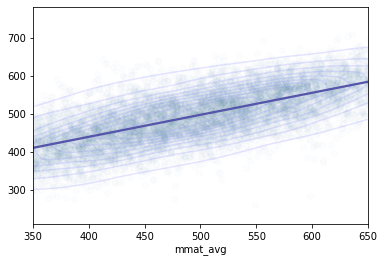

In [307]:
sns.kdeplot(x=y_test, y=predictions, color='#9999FF', alpha=0.25);
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.01}, line_kws={'color':'#5555AA'});
plt.xlim(350,650);

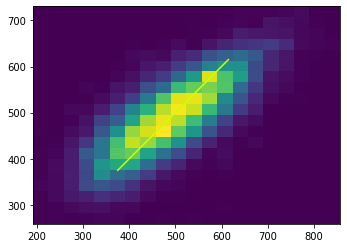

In [308]:
graph, xedges, yedges = np.histogram2d(y_test, predictions, bins=20)
graph = graph.T
plt.imshow(graph, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]);
x=np.arange(375,625,10)
plt.plot(x,x,color='#CCFF00');

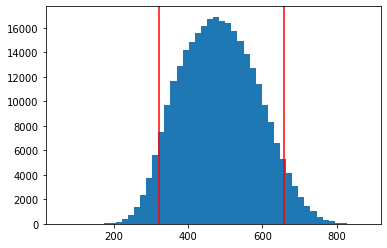

In [309]:
plt.hist(student['mmat_avg'], bins=50);
plt.axvline(student['mmat_avg'].quantile(0.05), color='r');
plt.axvline(student['mmat_avg'].quantile(0.95), color='r');

In [310]:
import statsmodels.api as sm

X_train_Sm = sm.add_constant(X_train)
ls = sm.OLS(y_train, X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     1450.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:46:05   Log-Likelihood:            -5.0503e+05
No. Observations:               90000   AIC:                         1.010e+06
Df Residuals:                   89913   BIC:                         1.011e+06
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [311]:
x_matrix = sm.add_constant(X_test)
prediction_CI = ls.get_prediction(x_matrix)
prediction_CI = prediction_CI.summary_frame(alpha=0.20)

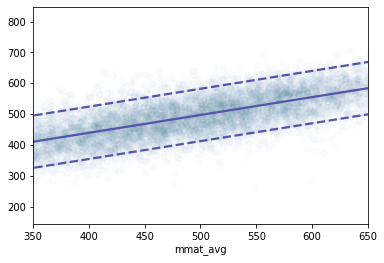

In [312]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.01}, line_kws={'color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
plt.xlim(350,650);

In [313]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [314]:
school['IDCNTRY'] = school['IDCNTRY'].astype(str)

In [315]:
school_sub_set = school[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg']].dropna()

In [316]:
X = school_sub_set[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage','socio_background']]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

grade  acad_hours  IDCNTRY_158  IDCNTRY_196  IDCNTRY_246  IDCNTRY_250  \
1      8   919.41667            0            0            0            0   
2      8  1000.00000            0            0            0            0   
3      8  1045.00000            0            0            0            0   
4      8   910.00000            0            0            0            0   
6      8  1000.00000            0            0            0            0   

   IDCNTRY_268  IDCNTRY_344  IDCNTRY_348  IDCNTRY_36  IDCNTRY_364  \
1            0            0            0           1            0   
2            0            0            0           1            0   
3            0            0            0           1            0   
4            0            0            0           1            0   
6            0            0            0           1            0   

   IDCNTRY_372  IDCNTRY_376  IDCNTRY_380  IDCNTRY_392  IDCNTRY_398  \
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
6            0            0            0            0            0   

   IDCNTRY_400  IDCNTRY_410  IDCNTRY_414  IDCNTRY_422  IDCNTRY_440  \
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
6            0            0            0            0            0   

   IDCNTRY_458  IDCNTRY_48  IDCNTRY_504  IDCNTRY_512  IDCNTRY_554  \
1            0           0            0            0            0   
2            0           0            0            0            0   
3            0           0            0            0            0   
4            0           0            0            0            0   
6            0           0            0            0            0   

   IDCNTRY_578  IDCNTRY_620  IDCNTRY_634  IDCNTRY_642  IDCNTRY_643  \
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
6            0            0            0            0            0   

   IDCNTRY_643001  IDCNTRY_682  IDCNTRY_702  IDCNTRY_710  IDCNTRY_710003  \
1               0            0            0            0               0   
2               0            0            0            0               0   
3               0            0            0            0               0   
4               0            0            0            0               0   
6               0            0            0            0               0   

   IDCNTRY_710004  IDCNTRY_752  IDCNTRY_784  IDCNTRY_7841  IDCNTRY_7842  \
1               0            0            0             0             0   
2               0            0            0             0             0   
3               0            0            0             0             0   
4               0            0            0             0             0   
6               0            0            0             0             0   

   IDCNTRY_792  IDCNTRY_818  IDCNTRY_840  IDCNTRY_9132  IDCNTRY_9133  \
1            0            0            0             0             0   
2            0            0            0             0             0   
3            0            0            0             0             0   
4            0            0            0             0             0   
6            0            0            0             0             0   

   IDCNTRY_926  disc_prob_Minor Problems  \
1            0                         0   
2            0          

In [317]:
Y = school_sub_set['mmat_avg']

In [318]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4701, 57)
(3134, 57)
(4701,)
(3134,)


In [319]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [320]:
print(model.intercept_)

378.75918663463005


In [321]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

Coefficient
grade                                                 12.714656
acad_hours                                             0.006942
IDCNTRY_158                                          148.124352
IDCNTRY_196                                           25.114848
IDCNTRY_246                                           47.274187
IDCNTRY_250                                           34.996932
IDCNTRY_268                                            0.000103
IDCNTRY_344                                          131.246699
IDCNTRY_348                                           70.965742
IDCNTRY_36                                            57.779613
IDCNTRY_364                                            4.918957
IDCNTRY_372                                           62.510032
IDCNTRY_376                                           57.220551
IDCNTRY_380                                           46.008692
IDCNTRY_392                                          127.031268
IDCNTRY_398                                           16.003520
IDCNTRY_400                                          -18.667815
IDCNTRY_410                                          135.565282
IDCNTRY_414                                          -43.380645
IDCNTRY_422                                          -17.712792
IDCNTRY_440                                           36.297228
IDCNTRY_458                                           46.547890
IDCNTRY_48                                            19.474309
IDCNTRY_504                                          -35.176895
IDCNTRY_512                                          -45.548962
IDCNTRY_554                                           30.400760
IDCNTRY_578                                           30.607526
IDCNTRY_620                                           59.664273
IDCNTRY_634                                          -20.029635
IDCNTRY_642                                           24.334429
IDCNTRY_643                                           77.011063
IDCNTRY_643001                                       102.010553
IDCNTRY_682                                          -60.059642
IDCNTRY_702                                          143.703871
IDCNTRY_710                                          -17.583992
IDCNTRY_710003                                        -8.507392
IDCNTRY_710004                                         8.198514
IDCNTRY_752                                           43.434876
IDCNTRY_784                                           -3.455049
IDCNTRY_7841                                          46.635593
IDCNTRY_7842                                         -29.071831
IDCNTRY_792                                           46.876383
IDCNTRY_818                                          -19.674852
IDCNTRY_840                                           68.545364
IDCNTRY_9132                                          62.198292
IDCNTRY_9133                                          86.329196
IDCNTRY_926                                           56.706884
disc_prob_Minor Problems                             -11.261875
disc_prob_Moderate to Severe Problems                -30.097427
acad_emph_Medium Emphasis                            -20.395504
acad_emph_Very High Emphasis                          26.131303
math_shortage_Affected A Lot                          -1.980890
math_shortage_Not Affected                             3.585303
sci_shortage_Affected A Lot                           -4.234232
sci_shortage_Not Affected                              2.307162
socio_background_More Disadvantaged                  -42.907478
socio_background_Neither More Affluent nor More...   -16.673787

In [322]:
predictions = model.predict(X_test)

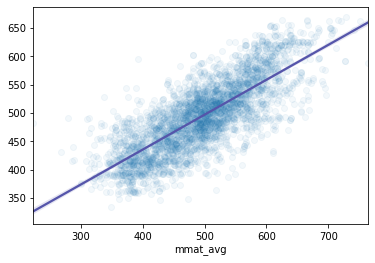

In [323]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.05}, line_kws={'color':'#5555AA'});

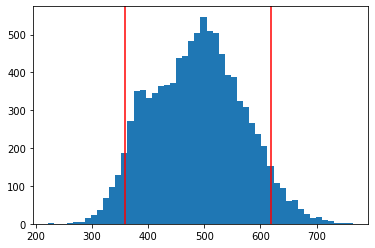

In [324]:
plt.hist(school['mmat_avg'], bins=50);
plt.axvline(school['mmat_avg'].quantile(0.05), color='r');
plt.axvline(school['mmat_avg'].quantile(0.95), color='r');

In [325]:
import statsmodels.api as sm

X_train_Sm = sm.add_constant(X_train)
ls = sm.OLS(y_train, X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     141.9
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:46:08   Log-Likelihood:                -24915.
No. Observations:                4701   AIC:                         4.994e+04
Df Residuals:                    4644   BIC:                         5.031e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [326]:
x_matrix = sm.add_constant(X_test)
prediction_CI = ls.get_prediction(x_matrix)
prediction_CI = prediction_CI.summary_frame(alpha=0.20)

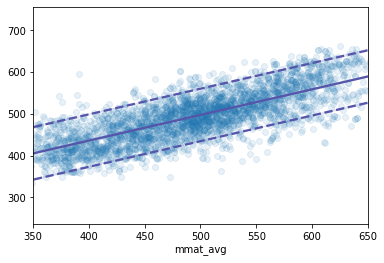

In [327]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.1}, line_kws={'color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
plt.xlim(350,650);

In [328]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [329]:
math_teach['IDCNTRY'] = math_teach['IDCNTRY'].astype(str)

In [330]:
math_teach_sub_set = math_teach[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','mmat_avg']].dropna()

In [331]:
X = math_teach_sub_set[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
0        16.0                1.0                 3.0              2.0   
2        22.0                1.0                 2.0              3.0   
3         3.0                1.0                 3.0              2.0   
5        16.0                2.0                 2.0              3.0   
7         1.0                2.0                 1.0              1.0   

   style_discussion  style_link_previous  style_procedures  \
0               3.0                  2.0               2.0   
2               2.0                  3.0               2.0   
3               2.0                  3.0               2.0   
5               2.0                  3.0               3.0   
7               2.0                  2.0               2.0   

   style_express_ideas  class_time  stud_explain_new  stud_explain_solve  \
0                  3.0       210.0               3.0                 1.0   
2                  2.0       200.0               3.0                 3.0   
3                  2.0       228.0               3.0                 3.0   
5                  3.0       240.0               2.0                 2.0   
7                  2.0       250.0               3.0                 3.0   

   stud_memorize  stud_practice  stud_apply  stud_class_work  \
0            1.0            2.0         2.0              1.0   
2            3.0            3.0         3.0              3.0   
3            1.0            3.0         2.0              2.0   
5            1.0            2.0         3.0              2.0   
7            2.0            2.0         2.0              3.0   

   stud_heterogeneous  stud_homogenous  computer_class  hw_freq  hw_time  \
0                 2.0              1.0             0.0      2.0     60.0   
2                 0.0              1.0             1.0      2.0     30.0   
3                 2.0              1.0             0.0      1.0     30.0   
5                 2.0              2.0             0.0      2.0     30.0   
7                 1.0              1.0             1.0      2.0     30.0   

   hw_self_correct  hw_graded  assess_observe  assess_ask  assess_short  \
0              0.0        0.0             1.0         1.0           1.0   
2              1.0        2.0             2.0         2.0           2.0   
3              1.0        0.0             2.0         2.0           0.0   
5              1.0        1.0             1.0         1.0           2.0   
7              1.0        0.0             2.0         2.0           2.0   

   assess_long  assess_projects  school_acad_focus_score  \
0          2.0              0.0                 13.12465   
2          2.0              0.0                 10.35236   
3          1.0              1.0                 10.65284   
5          2.0              1.0                 13.86227   
7          0.0              0.0                 10.95225   

   limited_by_needs_score  school_safe_score  job_satisfaction_score  \
0                12.67245           10.58171                10.25874   
2                11.28828           12.56459                11.74559   
3                 9.11668            9.18523                10.82008   
5                 9.11668           11.78998                11.74559   
7                 8.15603           10.58171                10.25874   

   study_stem  study_edu  IDCNTRY_158  IDCNTRY_196  IDCNTRY_246  IDCNTRY_250  \
0           1          1            0            0            0            0   
2           1          0            0            0            0            0   
3           1          1            0            0            0            0   
5           1          1            0            0            0            0   
7           0          1            0            0            0            0   

   IDCNTRY_268  IDCNTRY_344  IDCNTRY_348  IDCNTRY_36  IDCNTRY_364  \
0            0            0            0           1            0   
2            0            0 

In [332]:
Y = math_teach_sub_set['mmat_avg']

In [333]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3049, 88)
(1307, 88)
(3049,)
(1307,)


In [334]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [335]:
print(model.intercept_)

332.2720262758373


In [336]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

Coefficient
experience                      0.028558
style_daily_lives             -11.304789
style_explain_work              3.958862
style_challenge                12.258394
style_discussion               -1.406712
style_link_previous            -0.112383
style_procedures                3.924571
style_express_ideas             0.732846
class_time                     -0.036326
stud_explain_new                2.141261
stud_explain_solve             -3.034688
stud_memorize                  -6.507720
stud_practice                  -0.301477
stud_apply                      3.201417
stud_class_work                -3.423927
stud_heterogeneous             -3.018872
stud_homogenous                 0.162264
computer_class                 -0.868214
hw_freq                         4.350022
hw_time                         0.397103
hw_self_correct                 5.001305
hw_graded                      -7.444831
assess_observe                 -5.054595
assess_ask                      1.707022
assess_short                   -5.112873
assess_long                     8.468329
assess_projects                -2.069019
school_acad_focus_score         6.397565
limited_by_needs_score          9.996265
school_safe_score               0.939486
job_satisfaction_score         -2.916266
study_stem                     18.408122
study_edu                       0.720603
IDCNTRY_158                   136.356408
IDCNTRY_196                    51.550750
IDCNTRY_246                    29.231258
IDCNTRY_250                    18.324644
IDCNTRY_268                    -0.436446
IDCNTRY_344                   101.980124
IDCNTRY_348                    58.691487
IDCNTRY_36                     69.969112
IDCNTRY_364                    17.906817
IDCNTRY_372                    32.484783
IDCNTRY_376                    37.982963
IDCNTRY_380                    17.564620
IDCNTRY_392                   116.963245
IDCNTRY_398                    27.347462
IDCNTRY_400                    -4.060599
IDCNTRY_410                   133.679041
IDCNTRY_414                   -25.280688
IDCNTRY_422                   -34.590977
IDCNTRY_440                    49.516311
IDCNTRY_458                    55.727461
IDCNTRY_48                     17.276961
IDCNTRY_504                   -13.018475
IDCNTRY_512                    19.099121
IDCNTRY_554                    24.750357
IDCNTRY_578                    33.062998
IDCNTRY_620                    51.614618
IDCNTRY_634                     4.991028
IDCNTRY_642                    11.998559
IDCNTRY_643                    83.798454
IDCNTRY_643001                118.603443
IDCNTRY_682                   -23.533566
IDCNTRY_702                   141.265562
IDCNTRY_710                     4.897557
IDCNTRY_710003                -57.135328
IDCNTRY_710004                 35.959600
IDCNTRY_752                    35.384076
IDCNTRY_784                     7.719059
IDCNTRY_7841                   58.083110
IDCNTRY_7842                  -24.800485
IDCNTRY_792                    64.333499
IDCNTRY_818                   -21.817565
IDCNTRY_840                    67.166482
IDCNTRY_9132                   84.770431
IDCNTRY_9133                   78.130840
IDCNTRY_926                    17.922467
pd_hours_6–15 hours            12.809182
pd_hours_Less than 6 hours      5.654786
pd_hours_More than 35 hours    -3.875238
pd_hours_None                  -2.416986
edu_level_ISCED Level 3       -53.852521
edu_level_ISCED Level 4       -64.946059
edu_level_ISCED Level 5       -62.593622
edu_level_ISCED Level 6       -55.732139
edu_level_ISCED Level 7       -40.513588
edu_level_ISCED Level 8       -41.409187

In [337]:
predictions = model.predict(X_test)

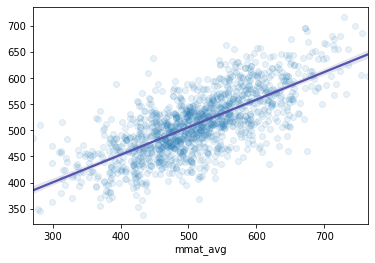

In [338]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.1}, line_kws={'color':'#5555AA'});

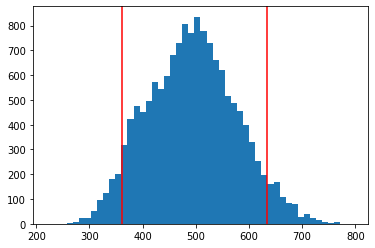

In [339]:
plt.hist(math_teach['mmat_avg'], bins=50);
plt.axvline(math_teach['mmat_avg'].quantile(0.05), color='r');
plt.axvline(math_teach['mmat_avg'].quantile(0.95), color='r');

In [340]:
import statsmodels.api as sm

X_train_Sm = sm.add_constant(X_train)
ls = sm.OLS(y_train, X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     40.02
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:46:10   Log-Likelihood:                -16584.
No. Observations:                3049   AIC:                         3.335e+04
Df Residuals:                    2960   BIC:                         3.388e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [341]:
x_matrix = sm.add_constant(X_test)
prediction_CI = ls.get_prediction(x_matrix)
prediction_CI = prediction_CI.summary_frame(alpha=0.20)

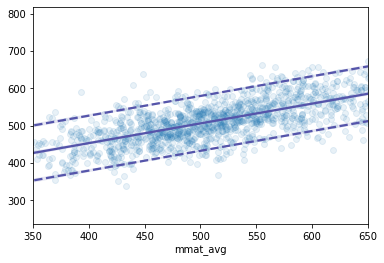

In [342]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.1}, line_kws={'color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
plt.xlim(350,650);

In [9]:
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [10]:
sci_teach['IDCNTRY'] = sci_teach['IDCNTRY'].astype(str)

In [11]:
sci_teach_sub_set = sci_teach[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','ssci_avg']].dropna()

In [12]:
X = sci_teach_sub_set[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
0        16.0                2.0                 3.0              2.0   
2         4.0                1.0                 1.0              1.0   
3        15.0                3.0                 3.0              1.0   
4        14.0                2.0                 2.0              1.0   
5         6.0                1.0                 3.0              1.0   

   style_discussion  style_link_previous  style_procedures  \
0               3.0                  2.0               3.0   
2               2.0                  2.0               0.0   
3               2.0                  3.0               1.0   
4               1.0                  1.0               0.0   
5               3.0                  3.0               2.0   

   style_express_ideas  class_time  stud_explain_new  stud_observe_phenom  \
0                  3.0       140.0               2.0                  2.0   
2                  2.0       250.0               3.0                  0.0   
3                  3.0       200.0               3.0                  2.0   
4                  3.0       200.0               3.0                  2.0   
5                  2.0       200.0               2.0                  2.0   

   stud_demo_exp  stud_plan_exp  stud_conduct_exp  stud_present  \
0            2.0            1.0               1.0           1.0   
2            2.0            2.0               2.0           2.0   
3            3.0            2.0               2.0           2.0   
4            1.0            2.0               1.0           2.0   
5            1.0            1.0               2.0           1.0   

   stud_interpret  stud_use_evid  stud_read_text  stud_memorize  \
0             2.0            1.0             3.0            2.0   
2             2.0            2.0             2.0            3.0   
3             2.0            2.0             3.0            3.0   
4             2.0            2.0             1.0            0.0   
5             2.0            2.0             2.0            3.0   

   stud_formulas  stud_field  stud_heterogeneous  stud_homogenous  \
0            1.0         1.0                 2.0              1.0   
2            2.0         1.0                 1.0              2.0   
3            1.0         1.0                 3.0              1.0   
4            3.0         1.0                 1.0              3.0   
5            3.0         1.0                 2.0              2.0   

   computer_class  hw_freq  hw_time  hw_self_correct  hw_graded  \
0             0.0      2.0     30.0              2.0        1.0   
2             0.0      1.0     60.0              1.0        0.0   
3             1.0      1.0     30.0              0.0        1.0   
4             1.0      1.0     30.0              0.0        0.0   
5             1.0      2.0     15.0              0.0        0.0   

   assess_observe  assess_ask  assess_short  assess_long  assess_projects  \
0             2.0         2.0           1.0          1.0              1.0   
2             2.0         2.0           2.0          2.0              0.0   
3             2.0         2.0           2.0          2.0              2.0   
4             2.0         2.0           1.0          1.0              1.0   
5             1.0         2.0           1.0          1.0              1.0   

   school_acad_focus_score  limited_by_needs_score  school_safe_score  \
0                  8.84690                10.14509            9.18523   
2                  8.54651                 9.11668            8.39631   
3                 12.15607                 7.67828           11.14932   
4                 10.95225                 9.61910            9.18523   
5                  7.30893                 9.61910            9.18523   

   job_satisfaction_score  study_stem  study_edu  IDCNTRY_158  IDCNTRY_196  \
0                 6.74486           1          1            0            0   
2                 7.21969           1         

In [13]:
Y = sci_teach_sub_set['ssci_avg']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5478, 94)
(2348, 94)
(5478,)
(2348,)


In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [16]:
print(model.intercept_)

408.1532716632345


In [17]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

Coefficient
experience                      0.123295
style_daily_lives              -1.842093
style_explain_work              7.101142
style_challenge                 5.849273
style_discussion               -0.106622
style_link_previous             3.861837
style_procedures               -3.861584
style_express_ideas             2.273696
class_time                     -0.101938
stud_explain_new               -4.200307
stud_observe_phenom            -1.528129
stud_demo_exp                  -3.479376
stud_plan_exp                   1.409709
stud_conduct_exp               -1.265031
stud_present                   -1.562354
stud_interpret                  4.992145
stud_use_evid                   2.645698
stud_read_text                 -2.598403
stud_memorize                  -2.148525
stud_formulas                   4.693768
stud_field                     -4.212036
stud_heterogeneous             -2.049775
stud_homogenous                -1.703986
computer_class                  0.812080
hw_freq                        -2.616174
hw_time                         0.061031
hw_self_correct                 1.665963
hw_graded                      -4.361759
assess_observe                 -6.345687
assess_ask                      5.248806
assess_short                    0.989414
assess_long                     5.008920
assess_projects                -2.258367
school_acad_focus_score         8.042462
limited_by_needs_score          7.113460
school_safe_score               1.080775
job_satisfaction_score         -3.021519
study_stem                     23.108922
study_edu                      -1.933070
IDCNTRY_158                    90.450521
IDCNTRY_196                    -3.750779
IDCNTRY_246                    37.566854
IDCNTRY_250                   -13.940779
IDCNTRY_268                   -46.378435
IDCNTRY_344                     2.725272
IDCNTRY_348                    34.094523
IDCNTRY_36                     61.534138
IDCNTRY_364                   -15.854008
IDCNTRY_372                    27.297723
IDCNTRY_376                    32.212646
IDCNTRY_380                    -3.051764
IDCNTRY_392                    74.399822
IDCNTRY_398                   -22.857169
IDCNTRY_400                   -14.299445
IDCNTRY_410                    71.941951
IDCNTRY_414                   -24.379453
IDCNTRY_422                   -94.882631
IDCNTRY_440                    11.655710
IDCNTRY_458                     7.504712
IDCNTRY_48                     24.205355
IDCNTRY_504                   -68.427236
IDCNTRY_512                     4.698560
IDCNTRY_554                    29.134731
IDCNTRY_578                     5.403285
IDCNTRY_620                    38.668276
IDCNTRY_634                    -6.401249
IDCNTRY_642                   -10.180980
IDCNTRY_643                    49.435345
IDCNTRY_643001                 60.920748
IDCNTRY_682                   -17.767642
IDCNTRY_702                   104.839521
IDCNTRY_710                   -20.366468
IDCNTRY_710003                 14.608095
IDCNTRY_710004                 16.849233
IDCNTRY_752                    16.421804
IDCNTRY_784                   -13.155451
IDCNTRY_7841                   47.564199
IDCNTRY_7842                  -65.807507
IDCNTRY_792                    59.961993
IDCNTRY_818                   -81.622060
IDCNTRY_840                    62.900123
IDCNTRY_9132                   33.512356
IDCNTRY_9133                   41.517305
IDCNTRY_926                    -5.929078
pd_hours_6–15 hours            -1.980591
pd_hours_Less than 6 hours      5.661110
pd_hours_More than 35 hours    -7.604460
pd_hours_None                  -2.521517
edu_level_ISCED Level 3       -71.455286
edu_level_ISCED Level 4       -58.936164
edu_level_ISCED Level 5       -94.331722
edu_level_ISCED Level 6       -74.762166
edu_level_ISCED Level 7       -63.269491
edu_level_ISCED Level 8       -50.000595

In [18]:
predictions = model.predict(X_test)

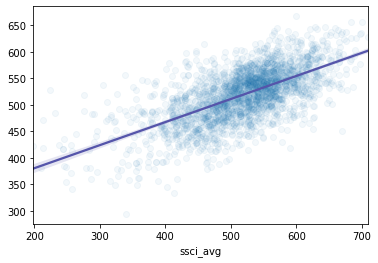

In [19]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.05}, line_kws={'color':'#5555AA'});

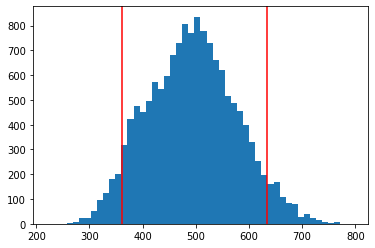

In [20]:
plt.hist(math_teach['mmat_avg'], bins=50);
plt.axvline(math_teach['mmat_avg'].quantile(0.05), color='r');
plt.axvline(math_teach['mmat_avg'].quantile(0.95), color='r');

In [38]:
import statsmodels.api as sm

X_train_Sm = sm.add_constant(X_train)
ls = sm.OLS(y_train, X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               ssci_avg   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     49.90
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:29:22   Log-Likelihood:                -29727.
No. Observations:                5478   AIC:                         5.964e+04
Df Residuals:                    5383   BIC:                         6.027e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [39]:
x_matrix = sm.add_constant(X_test)
prediction_CI = ls.get_prediction(x_matrix)
prediction_CI = prediction_CI.summary_frame(alpha=0.20)

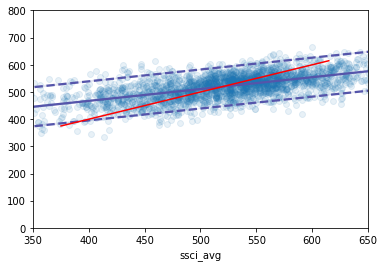

In [64]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.1}, line_kws={'color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
sns.regplot(x=y_test, y=prediction_CI.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#5555AA'});
x=np.arange(375,625,10)
plt.plot(x,x,color='#FF0000');
plt.xlim(350,650);
plt.ylim(0,800);

In [358]:
school['socio_background'].value_counts()

More Affluent                                   3173
More Disadvantaged                              2880
Neither More Affluent nor More Disadvantaged    2631
Name: socio_background, dtype: int64

In [359]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [360]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [361]:
new_set = school.set_index(['IDCNTRY','IDSCHOOL']).join(math_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']]
                                                        .join(sci_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']], 
                                                              lsuffix="_math", rsuffix="_sci")).dropna()

In [362]:
new_set.reset_index(inplace=True)
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)

In [363]:
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
print(X.shape)
print(y.shape)

(5801, 10)
(5801,)


In [364]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [365]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 50, random_state=0, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [366]:
predictions = clf.predict(X_test)

In [367]:
(y_test == predictions).mean()

0.6391042204995694

In [368]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(int)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [369]:
from xgboost import XGBClassifier
# Create a classifier
xgb = XGBClassifier(booster='gbtree', random_state=42, eval_metric="rmse", num_class=3, n_estimators=500)
# Fit the classifier with the training data
xgb.fit(X_train,y_train)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [370]:
predictions_xgb = xgb.predict(X_test)

In [371]:
(y_test == predictions_xgb).mean()

0.6373815676141258

[Return to Top of Data Modeling](#data_modeling)

<div id='classification_models'></div>

## Classification Models

In [372]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
knn = KNeighborsClassifier(n_neighbors=13, weights = 'distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13, weights='distance')

In [374]:
predictions_knn = knn.predict(X_test)

In [375]:
(y_test == predictions_knn).mean()

0.5305770887166236

In [376]:
(predictions == predictions_xgb).mean()

0.772609819121447

In [377]:
(predictions_knn == predictions_xgb).mean()

0.595176571920758

In [378]:
(predictions_knn == predictions).mean()

0.6037898363479759

In [379]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 440,
 'More Disadvantaged': 356,
 'Neither More Affluent nor More Disadvantaged': 365}

In [380]:
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 477,
 'More Disadvantaged': 381,
 'Neither More Affluent nor More Disadvantaged': 303}

In [381]:
unique, counts = np.unique(predictions_xgb, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 463,
 'More Disadvantaged': 373,
 'Neither More Affluent nor More Disadvantaged': 325}

In [382]:
output = pd.DataFrame()
output['Expected Output'] = y_test
output['RF Output'] = predictions
output['XGB Output'] = predictions_xgb
output['KNN Output'] = predictions_knn
output.head(20)

Expected Output  \
3737                            More Disadvantaged   
1103                            More Disadvantaged   
812                             More Disadvantaged   
1632                                 More Affluent   
1128                                 More Affluent   
1412                            More Disadvantaged   
712                             More Disadvantaged   
4464                                 More Affluent   
177   Neither More Affluent nor More Disadvantaged   
3599                                 More Affluent   
4437  Neither More Affluent nor More Disadvantaged   
1244                            More Disadvantaged   
1448  Neither More Affluent nor More Disadvantaged   
3783                                 More Affluent   
4680                                 More Affluent   
1117                            More Disadvantaged   
5282                            More Disadvantaged   
2164                                 More Affluent   
787   Neither More Affluent nor More Disadvantaged   
624   Neither More Affluent nor More Disadvantaged   

                                         RF Output  \
3737  Neither More Affluent nor More Disadvantaged   
1103                            More Disadvantaged   
812                             More Disadvantaged   
1632  Neither More Affluent nor More Disadvantaged   
1128                                 More Affluent   
1412                            More Disadvantaged   
712   Neither More Affluent nor More Disadvantaged   
4464                                 More Affluent   
177   Neither More Affluent nor More Disadvantaged   
3599                                 More Affluent   
4437                                 More Affluent   
1244                            More Disadvantaged   
1448  Neither More Affluent nor More Disadvantaged   
3783  Neither More Affluent nor More Disadvantaged   
4680                                 More Affluent   
1117                                 More Affluent   
5282                            More Disadvantaged   
2164                                 More Affluent   
787   Neither More Affluent nor More Disadvantaged   
624                             More Disadvantaged   

                                        XGB Output  \
3737  Neither More Affluent nor More Disadvantaged   
1103                            More Disadvantaged   
812                             More Disadvantaged   
1632  Neither More Affluent nor More Disadvantaged   
1128                                 More Affluent   
1412                            More Disadvantaged   
712                             More Disadvantaged   
4464                                 More Affluent   
177   Neither More Affluent nor More Disadvantaged   
3599                                 More Affluent   
4437                            More Disadvantaged   
1244  Neither More Affluent nor More Disadvantaged   
1448  Neither More Affluent nor More Disadvantaged   
3783  Neither More Affluent nor More Disadvantaged   
4680                            More Disadvantaged   
1117                            More Disadvantaged   
5282                            More Disadvantaged   
2164                                 More Affluent   
787                             More Disadvantaged   
624   Neither More Affluent nor More Disadvantaged   

                                        KNN Output  
3737  Neither More Affluent nor More Disadvantaged  
1103  Neither More Affluent nor More Disadvantaged  
812                                  More Affluent  
1632  Neither More Affluent nor More Disadvantaged  
1128                            More Disadvantaged  
1412                            More Disadvantaged  
712                             More Disadvantaged  
4464                                 More Affluent  
177   Neither More Affluent nor More Disadvantaged  
3599  Neither More Affluent nor More Disadvantaged  
4437                                 More Afflu

[Return to Top of Data Modeling](#data_modeling)

<div id='recommendation_engine'></div>

## Recommendation Engine

In [65]:
stud_ach

IDCNTRY  test_book  IDSCHOOL  IDCLASS    IDSTUD  grade   language  \
0          7842         11      5001   500102  50010201      8    English   
1          7842         12      5001   500102  50010202      8    English   
2          7842         13      5001   500102  50010203      8    English   
3          7842         14      5001   500102  50010204      8    English   
4          7842          2      5001   500102  50010207      8    English   
...         ...        ...       ...      ...       ...    ...        ...   
295448   710004          3      5520   552004  55200422      9  Afrikaans   
295449   710004          4      5520   552004  55200423      9  Afrikaans   
295450   710004          5      5520   552004  55200424      9  Afrikaans   
295451   710004          6      5520   552004  55200425      9  Afrikaans   
295452   710004          7      5520   552004  55200426      9  Afrikaans   

           sex    age  MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
0         Male  13.58          NaN          NaN          NaN          NaN   
1         Male  13.75          NaN          NaN          NaN          NaN   
2         Male  13.50          NaN          NaN          NaN          NaN   
3         Male  14.00          0.0          0.0          1.0          0.0   
4         Male  13.33          NaN          NaN          NaN          NaN   
...        ...    ...          ...          ...          ...          ...   
295448  Female  14.75          NaN          NaN          NaN          NaN   
295449    Male  15.17          NaN          NaN          NaN          NaN   
295450    Male  15.42          NaN          NaN          NaN          NaN   
295451    Male  15.33          NaN          NaN          NaN          NaN   
295452    Male  15.58          NaN          NaN          NaN          NaN   

        MP52063_val  MP52072_val  MP52146_val  MP52092_val  MP52046_val  \
0               NaN          NaN          NaN          NaN          NaN   
1               NaN          NaN          NaN          NaN          NaN   
2               NaN          NaN          NaN          NaN          NaN   
3               1.0          1.0          1.0          0.0          1.0   
4               NaN          NaN          NaN          NaN          NaN   
...             ...          ...          ...          ...          ...   
295448          NaN          NaN          NaN          NaN          NaN   
295449          NaN          NaN          NaN          NaN          NaN   
295450          NaN          NaN          NaN          NaN          NaN   
295451          NaN          NaN          NaN          NaN          NaN   
295452          NaN          NaN          NaN          NaN          NaN   

        MP52083_val  MP52082_val  MP52161_val  MP52418_val  MP72007_val  \
0               NaN          NaN          NaN          NaN          NaN   
1               NaN          NaN          NaN          NaN          NaN   
2               NaN          NaN          NaN          NaN          NaN   
3               0.0          1.0          0.0          0.0          NaN   
4               NaN          NaN          NaN          NaN          1.0   
...             ...          ...          ...          ...          ...   
295448          NaN          NaN          NaN          NaN          NaN   
295449          NaN          NaN          NaN          NaN          NaN   
295450          NaN          NaN          NaN          NaN          NaN   
295451          NaN          NaN          NaN          NaN          NaN   
295452          NaN          NaN          NaN          NaN          NaN   

        MP72025_val  MP72017_val  MP72190_val  MP72068_val  MP72076_val  \
0               NaN          NaN          NaN          NaN          NaN   
1               NaN          NaN          NaN          NaN          NaN   
2               NaN          NaN          NaN          NaN          NaN   
3               NaN          NaN          NaN          N

In [66]:
item_values = pd.concat([stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].mean(),stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].count()], axis=1).rename(columns={0:'val',1:'count'})

In [67]:
item_values.index = item_values.reset_index()['index'].apply(lambda x: x[:-4])
item_values

val  count
index                   
MP52024  0.486831  44576
MP52058  0.260319  43270
MP52125  0.403707  44614
MP52229  0.509726  41948
MP52063  0.449207  44563
...           ...    ...
SP72210  0.494443  36708
SP72249  0.380294  36435
SP72323  0.526143  35994
SP72368  0.609267  36516
SP72303  0.359555  35569

[386 rows x 2 columns]

In [68]:
file_name = 'T19_G8_Item Information/T19_G8_Item Information.xlsx'
math_items = pd.read_excel(file_name, sheet_name='MAT').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]
sci_items = pd.read_excel(file_name, sheet_name='SCI').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]

In [69]:
user_item = stud_ach.set_index(['IDCNTRY','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_val' in col]]

In [70]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
7842    50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710004  55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
7842    50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          1.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710004  55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
7842    50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          1.0          0.0          1.0          0.0   
        50010207          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710004  55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
7842    50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          NaN          NaN   
        50010203          NaN          NaN          NaN          NaN   
        50010204          0.0          NaN          NaN          NaN   
        50010207          NaN          1.0          0.0          0.0   
...                       ...          ...          ...          ...   
710004  55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
7842    50010201          NaN          NaN          NaN          NaN   
        50010202          NaN          NaN          Na

In [71]:
user_item = user_item[pd.DataFrame(user_item.index)[0].apply(lambda x: x[0]<1000).values]

In [72]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
784     50020101          NaN          NaN          NaN          NaN   
        50020102          NaN          NaN          NaN          NaN   
        50020103          NaN          NaN          NaN          NaN   
        50020104          NaN          NaN          NaN          NaN   
        50020105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
784     50020101          NaN          NaN          NaN          NaN   
        50020102          NaN          NaN          NaN          NaN   
        50020103          NaN          NaN          NaN          NaN   
        50020104          NaN          NaN          NaN          NaN   
        50020105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
784     50020101          NaN          NaN          NaN          NaN   
        50020102          NaN          NaN          NaN          NaN   
        50020103          NaN          NaN          NaN          NaN   
        50020104          NaN          NaN          NaN          NaN   
        50020105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
784     50020101          NaN          NaN          NaN          NaN   
        50020102          NaN          NaN          NaN          NaN   
        50020103          NaN          NaN          NaN          NaN   
        50020104          NaN          NaN          NaN          NaN   
        50020105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
784     50020101          NaN          NaN          NaN          NaN   
        50020102          NaN          NaN          Na

In [73]:
user_id = (710, 55200422)
user_item.loc[user_id,:]

MP52024_val   NaN
MP52058_val   NaN
MP52125_val   NaN
MP52229_val   NaN
MP52063_val   NaN
               ..
SP72210_val   NaN
SP72249_val   NaN
SP72323_val   NaN
SP72368_val   NaN
SP72303_val   NaN
Name: (710, 55200422), Length: 386, dtype: float64

In [74]:
%%time
similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna().sort_values(ascending=False).head(10).index
user_item.loc[similar_users,:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 33.5 s


MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
504     52360316          NaN          NaN          NaN          NaN   
752     50510525          NaN          NaN          NaN          NaN   
36      50370711          NaN          NaN          NaN          NaN   
578     50910526          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
926     51670224          NaN          NaN          NaN          NaN   
504     51240423          NaN          NaN          NaN          NaN   
926     50250319          NaN          NaN          NaN          NaN   
410     50850201          NaN          NaN          NaN          NaN   
348     51450111          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
504     52360316          NaN          NaN          NaN          NaN   
752     50510525          NaN          NaN          NaN          NaN   
36      50370711          NaN          NaN          NaN          NaN   
578     50910526          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
926     51670224          NaN          NaN          NaN          NaN   
504     51240423          NaN          NaN          NaN          NaN   
926     50250319          NaN          NaN          NaN          NaN   
410     50850201          NaN          NaN          NaN          NaN   
348     51450111          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
504     52360316          NaN          NaN          NaN          NaN   
752     50510525          NaN          NaN          NaN          NaN   
36      50370711          NaN          NaN          NaN          NaN   
578     50910526          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
926     51670224          NaN          NaN          NaN          NaN   
504     51240423          NaN          NaN          NaN          NaN   
926     50250319          NaN          NaN          NaN          NaN   
410     50850201          NaN          NaN          NaN          NaN   
348     51450111          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
504     52360316          NaN          0.0          0.0          NaN   
752     50510525          NaN          0.0          1.0          0.0   
36      50370711          NaN          NaN          NaN          NaN   
578     50910526          NaN          NaN          NaN          NaN   
840     52090207          NaN          0.0          0.0          0.0   
926     51670224          NaN          NaN          NaN          NaN   
504     51240423          NaN          1.0          0.0          1.0   
926     50250319          NaN          NaN          NaN          NaN   
410     50850201          NaN          NaN          NaN          NaN   
348     51450111          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
504     52360316          NaN          0.0          1.0          NaN   
752     50510525          1.0          1.0          1.0          1.0   
36      50370711          NaN          NaN          NaN          NaN   
578     50910526          NaN          NaN          NaN          NaN   
840     52090207          1.0          1.0          0.0          NaN   
926     51670224          NaN          NaN          Na

In [75]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users
    
    '''
    # compute similarity of each user to the provided user
    similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna()
    # sort by similarity
    similar_users.sort_values(ascending=False, inplace=True)
    # create list of just the ids
    most_similar_users = list(similar_users.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [76]:
def get_item_info(item_ids, math_items=math_items, sci_items=sci_items):
    '''
    gathers the info of the test items with given ids
    
    INPUT:
    item_ids - (list) a list of item ids
    math_items - (pandas dataframe) dataframe containing all math item information
    sci_items - (pandas dataframe) dataframe containing all science item information
    
    OUTPUT:
    item_info - (list of lists) a list of item information associated with the list of item ids 
                    (this is identified by the title column)
    '''
    item_info = []
    
    # gathers the info for any item id that is included in the list of test ids
    for item in item_ids:
        if item[0] == 'M':
            for match in list(math_items.loc[[_ for _ in math_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))
        elif item[0] =='S':
            for match in list(sci_items.loc[[_ for _ in sci_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))

    return item_info # Return the article names associated with list of article ids

In [77]:
def get_user_items(user_id, user_item=user_item):
    '''    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    item_ids - (list) a list of the items ids completed by the user
    item_info - (list) a list of test item info associated with the list of item ids 
    
    Description:
    Provides a list of the item ids and item information that have been seen by a user
    '''
    # gathers all of the article ids with which the user has already interacted
    item_ids = list(user_item.columns[np.where(user_item.loc[user_id,:].apply(lambda x: x == x))].astype(str))
    # gets the article names for those same articles
    item_info = get_item_info(item_ids)
    
    return item_ids, item_info # return the ids and information

In [78]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    # create an empty set to store the recommendations
    recs = set()
    # gather the article ids for the previous articles from our target user
    user_item_list = get_user_items(user_id)[0]
    # identify all similar users, ranked from most similar
    similar_users = find_similar_users(user_id)
    # for each user in the similarity list
    for sim_user in similar_users:
        # gather the article ides for the previous articles for this particular similar user
        sim_user_articles = get_user_items(sim_user)[0]
        # find the new articles that our target user had not read yet
        new_items = np.setdiff1d(sim_user_articles, user_item_list)
        # for each of the new items to recommend
        for item in new_items:
            # if there are already enough recommendations
            if len(recs) >= m:
                # stop looking for more recommendations
                break
            # otherwise, if there are not enough recommendations yet
            else:
                # add the item to the set of recommendations
                recs.add(item)
        # at the end of a similar user, if there are enough recommendations, stop looking at other users
        if len(recs) >= m:
                break
        
    return list(recs) # return your recommendations for this user_id

In [79]:
item_values.loc[[x[:-4] for x in user_user_recs(user_id)],:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


val  count
index                   
MP72180  0.404411  35548
MP72025  0.440308  36261
MP72103  0.423963  35739
MP72007  0.164425  36582
MP72068  0.591841  36694
MP72121  0.554089  35081
SP72072  0.499374  36770
SP72029  0.514507  36810
MP72098  0.269845  33145
MP72076  0.410426  36255

In [80]:
pd.DataFrame(user_item.count(axis=1),columns=['items'])

items
IDCNTRY IDSTUD         
784     50020101     53
        50020102     44
        50020103     50
        50020104     52
        50020105     32
...                 ...
710     55200422     51
        55200423     52
        55200424     51
        55200425     49
        55200426     56

[259800 rows x 1 columns]

In [81]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    sorts users by similarity to target user and total activity so that collaborative filtering is as productive as possible
    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    index (IDCNTRY, IDSTUD) - is a neighbor user_id (information to differentiate users)
                    similarity - measure of the similarity of each user to the provided user_id
                    items - the number of items completed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a matrix that measures similiarity
    similarity = pd.DataFrame(user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna(), columns=['similarity'])
    # count the total interactions for each user (measure of level of activity)
    interactions = pd.DataFrame(user_item.count(axis=1),columns=['items'])
    # join the similarity ratings with the user interaction cout
    neighbors_df = similarity.join(interactions) 
    # sort the values by similarity and then by the number of user_interactions
    neighbors_df.sort_values(by=['similarity','items'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [82]:
get_top_sorted_users(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


similarity  items
IDCNTRY IDSTUD                     
504     52360316    1.000000     20
752     50510525    0.890871     57
36      50370711    0.846114     52
578     50910526    0.769800     27
840     52090207    0.755929     36
...                      ...    ...
710     50010110   -0.844097     51
818     51240304   -1.000000     38
504     51770125   -1.000000     15
364     51010113   -1.000000     36
578     50970102   -1.000000     20

[56475 rows x 2 columns]

In [83]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by item id
    rec_names - (list) a list of recommendations for the user by item information
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds items the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total item interactions 
    before choosing those with fewer item interactions.

    * Choose articles with the items with the lowest average performance (most difficult questions) 
    before choosing those with higher average performance (easier questions). 
   
    '''
    # create an empty set for the recommendations
    recs = []
    # sort all test items by difficulty for use ranking
    top_items = item_values.sort_values(by=['count'], ascending=False).sort_values(by=['val']).index.tolist()
    # gets the items already assessed by the target user
    user_item_list = get_user_items(user_id)[0]
    # gathers a list of users similar to the target user (sorted by similarity and level of activity)
    similar_users = get_top_sorted_users(user_id).index.tolist()
    # go through each individual user
    for sim_user in similar_users:
        if len(recs) >= m:
            break
        else:
            # get the similar user's items
            sim_user_items = get_user_items(sim_user)[0]
            # gather only items new to the target user
            new_items = [x[:-4] for x in np.setdiff1d(sim_user_items, user_item_list)]
            # create a list of the new items
            new_list = [x for x in top_items if x in new_items]
            # keep adding items to the recommendations until we reach the recommendation limit
            for item in new_list:
                if len(recs) >= m:
                    break
                else:
                    recs.append(item)
                    user_item_list.append(item)
            
    
    # find all of the names of the articles
    rec_info  = get_item_info(recs)
    
    return recs, rec_info

In [84]:
%%time
user_user_recs_part2(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 34.5 s


(['SP72900',
  'MP72007',
  'MP72098',
  'SP72148',
  'SP72244',
  'SP72301',
  'MP72180',
  'MP72076',
  'SP72200',
  'MP72103'],
 ['Biology: Characteristics and Life Processes of Organisms (Applying) --> Classify animals based on a single characteristic',
  'Biology: Characteristics and Life Processes of Organisms (Reasoning) --> Identify the characteristic used to classify animals',
  'Number: Integers (Knowing) --> Statements for all values of integer a (DERIVED)',
  'Number: Integers (Knowing) --> Statements for all values of integer a - A',
  'Number: Integers (Knowing) --> Statements for all values of integer a - B',
  'Number: Integers (Knowing) --> Statements for all values of integer a - C',
  'Number: Integers (Knowing) --> Statements for all values of integer a - D',
  'Number: Integers (Knowing) --> Statements for all values of integer a - E',
  'Algebra: Expressions, Operations, and Equations (Applying) --> Value of x given perimeter of triangle ABC',
  'Chemistry: Proper

In [118]:
def FunkSVD(assess_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    assess_mat - (numpy array) a matrix with users as rows, assessment items as columns, and scores as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    item_mat - (numpy array) a latent feature by assessment item matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = assess_mat.shape[0] # number of users in the matrix
    n_items = assess_mat.shape[1] # number of assessment items in the matrix
    num_scores = n_users * n_items # total number of scores in the matrix
    
    # initialize the user and assessment item matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    item_mat = np.random.rand(latent_features,n_items) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_items):
                # if the rating exists
                if assess_mat[i, j] >= 0:
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    err = assess_mat[i, j] - user_mat[i,:].dot(item_mat[:,j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i,k] += learning_rate * (2*err*item_mat[k,j])
                        item_mat[k,j] += learning_rate * (2*err*user_mat[i,k])
        # print results for iteration
        if (iteration+1)%(int(iters/10)) == 0:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
        if iteration > 0 and old_sse < sse_accum:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
            break
    return user_mat, item_mat 

In [119]:
def user_item_predict(user_id, item_id):
    '''
    docstring
    
    INPUT:
    user_id - (tuple of integers)
    item_id - (str)
    
    OUTPUT:
    prediction - (float) predicted score for the user on the requested assessment item with item_id
    '''
    user_item_subset = pd.concat([user_item[user_item.index == user_id],user_item[user_item.index != user_id].sample(999)])
    assess_mat = np.matrix(user_item_subset)
    user_mat, item_mat = FunkSVD(assess_mat, latent_features=5, learning_rate = 0.001, iters = 1500)
    preds = user_mat.dot(item_mat)
    return(preds[0,item_id])

In [ ]:
user_item_predict(user_id, item_id=0)

Optimization Statistics
Iterations | Mean Squared Error 
150 		 0.021919
300 		 0.020368
450 		 0.019768
600 		 0.019521
750 		 0.019391


In [ ]:
list(user_item.columns).index('MP52229_val')

[Return to Top](#top)

<div id='evaluate_results'></div>

# Evaluate Results

[Return to Top](#top)

<div id='deploy_model'></div>

# Deploy Model